 # <center>SN2025kid</center>

 <center> Zisen Dai dzs23@mails.tsinghua.edu.cn </center>


This document presents the code and report for processing the observational spectral data of SN2025kid. We confirmed SN2025kid as a Type Ia supernova. Due to the absence of photometric light curve data, our analysis is limited to its classification and redshift measurement using specific absorption features.

## Importing Required Libraries and Data Loading

In [148]:
#导入必要的库
import os
import numpy as np
from astropy.io import fits
from astropy.stats import sigma_clip
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

import specutils

%matplotlib inline
import matplotlib.pylab as plt

The data obtained from observations with the Xinglong 2.16m telescope are stored in a txt file.

In [149]:
#数据读取
data_kid= np.loadtxt('./SN2025kid_bfosc_20250517.txt')
wav1 = data_kid[:,0]
flux1 = data_kid[:,1]

## Raw Spectrum Plotting

First, we plot the spectrum without any data processing, which will be filled with noise.

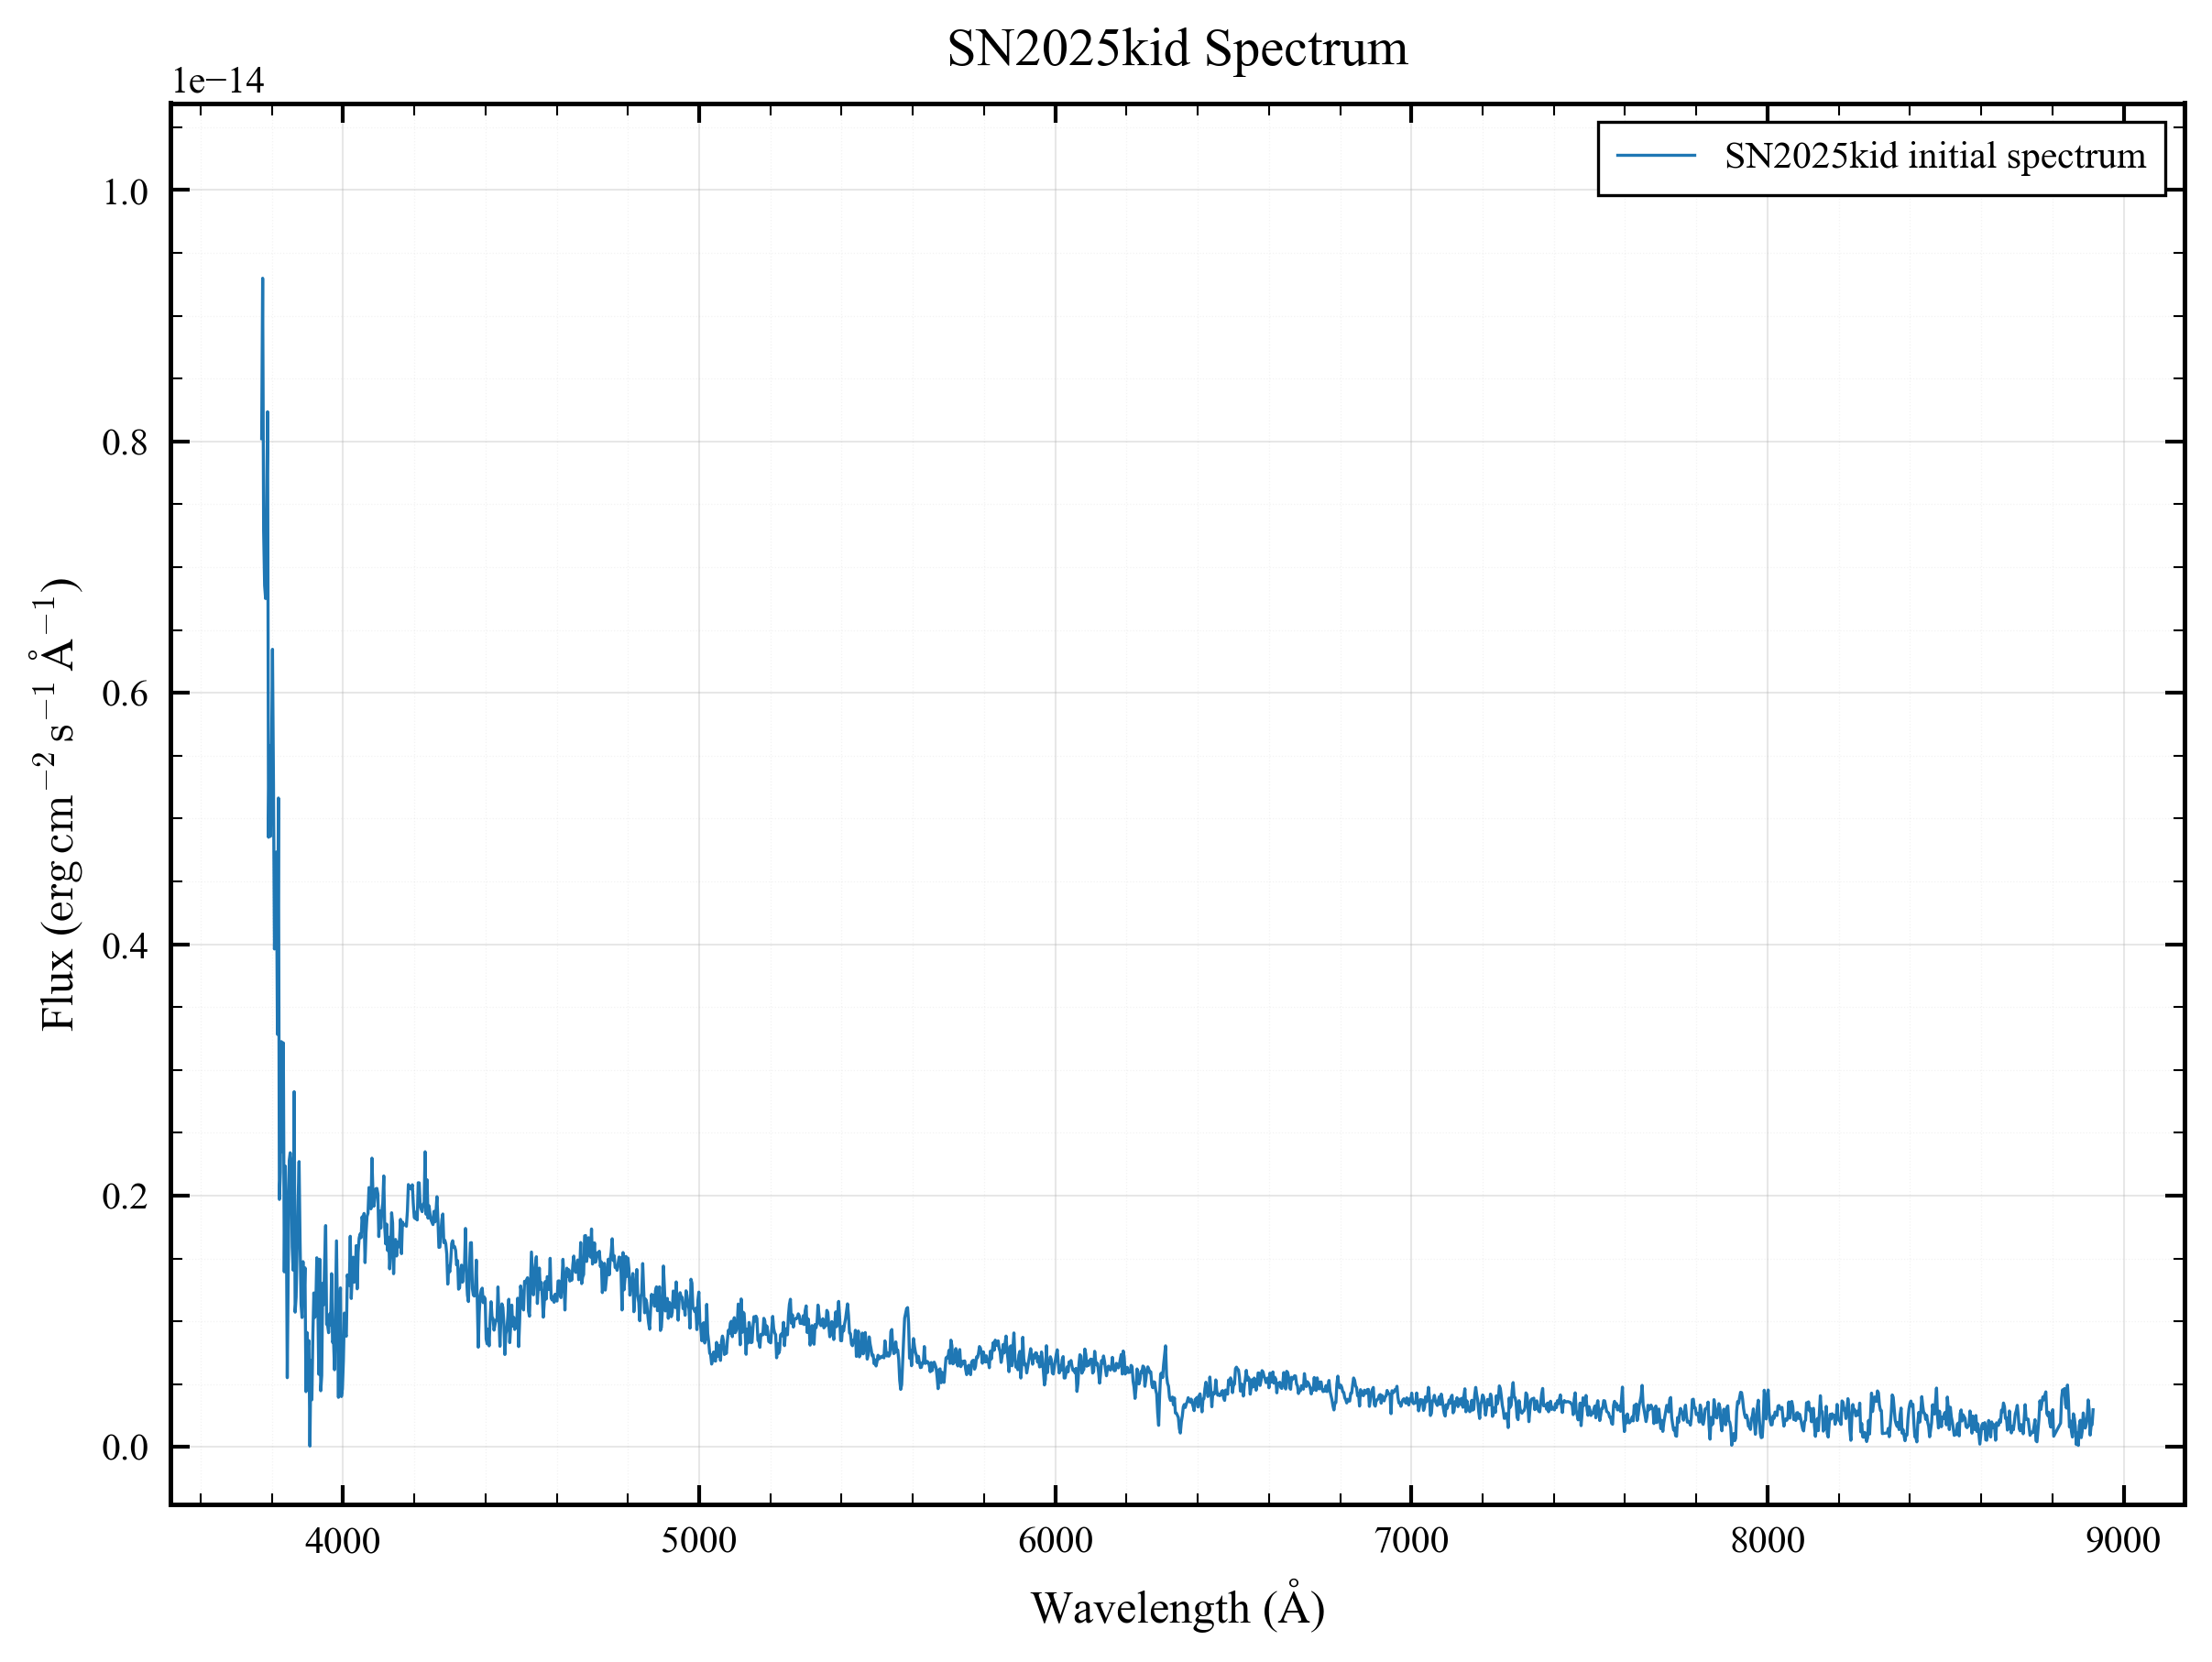

In [150]:
# 绘制初始SED图像

# 设置科学风格
plt.style.use('seaborn-v0_8-paper')
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif'],
    'font.size': 11,
    'axes.linewidth': 1.2,
    'axes.edgecolor': 'black',
    'axes.labelsize': 12,
    'axes.labelweight': 'normal',
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'xtick.major.width': 1.0,
    'ytick.major.width': 1.0,
    'xtick.minor.width': 0.5,
    'ytick.minor.width': 0.5,
    'mathtext.fontset': 'cm'
})

# 创建图形（使用类似SNID的尺寸比例）
fig, ax = plt.subplots(figsize=(8, 6))

# 绘制数据
ax.plot(wav1, flux1, 'k-', linewidth=0.8, color='#1f77b4',
        label='SN2025kid initial spectrum', zorder=10)

# 设置坐标轴标签
ax.set_xlabel(r'Wavelength ($\mathrm{\AA}$)', fontsize=12)
ax.set_ylabel(r'Flux ($\mathrm{erg\,cm^{-2}\,s^{-1}\,\AA^{-1}}$)', fontsize=12)

# 四边框架
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.2)

# 刻度设置
ax.tick_params(direction='in', top=True, right=True, 
               labelsize=10, length=5, width=1.0)
ax.minorticks_on()
ax.tick_params(which='minor', direction='in', top=True, right=True,
               length=3, width=0.5)

# 网格设置
ax.grid(True, which='major', alpha=0.3, linestyle='-', linewidth=0.5, zorder=0)
ax.grid(True, which='minor', alpha=0.15, linestyle=':', linewidth=0.3, zorder=0)

# 动态Y轴范围（借鉴SNID的方法）
ymin = np.min(flux1)
ymax = np.max(flux1)
yrange = ymax - ymin
ax.set_ylim(ymin - yrange * 0.05, ymax + yrange * 0.15)  # 底部5%，顶部15%空白

# 图例（放在最佳位置）
legend = ax.legend(frameon=True, fancybox=False, edgecolor='black',
                   fontsize=10, loc='best', framealpha=1.0,
                   borderpad=0.5, labelspacing=0.5)
legend.get_frame().set_linewidth(0.8)

# 添加标题
ax.set_title('SN2025kid Spectrum', fontsize=14, pad=10)

# 优化布局
plt.tight_layout(pad=0.5)

# 保存图形（使用类似SNID的命名方式）
#output_filename = 'spectrum_SN2025kid.png'  # 或 .pdf
#plt.savefig(output_filename, bbox_inches='tight', dpi=300)
#print(f'Figure saved as: {output_filename}')

# 不自动显示，保持figure对象活跃以便后续修改
# plt.show()

After preliminary data screening and plotting, we can approximately determine the locations and ranges of the absorption and emission lines. As an example, we have removed the wavelength bands that are excessively short, as their data clearly deviate from the normal spectral range.

Original data points: 1850
After cleaning: 1792
Wavelength range: 3835.1 - 8914.3 Å


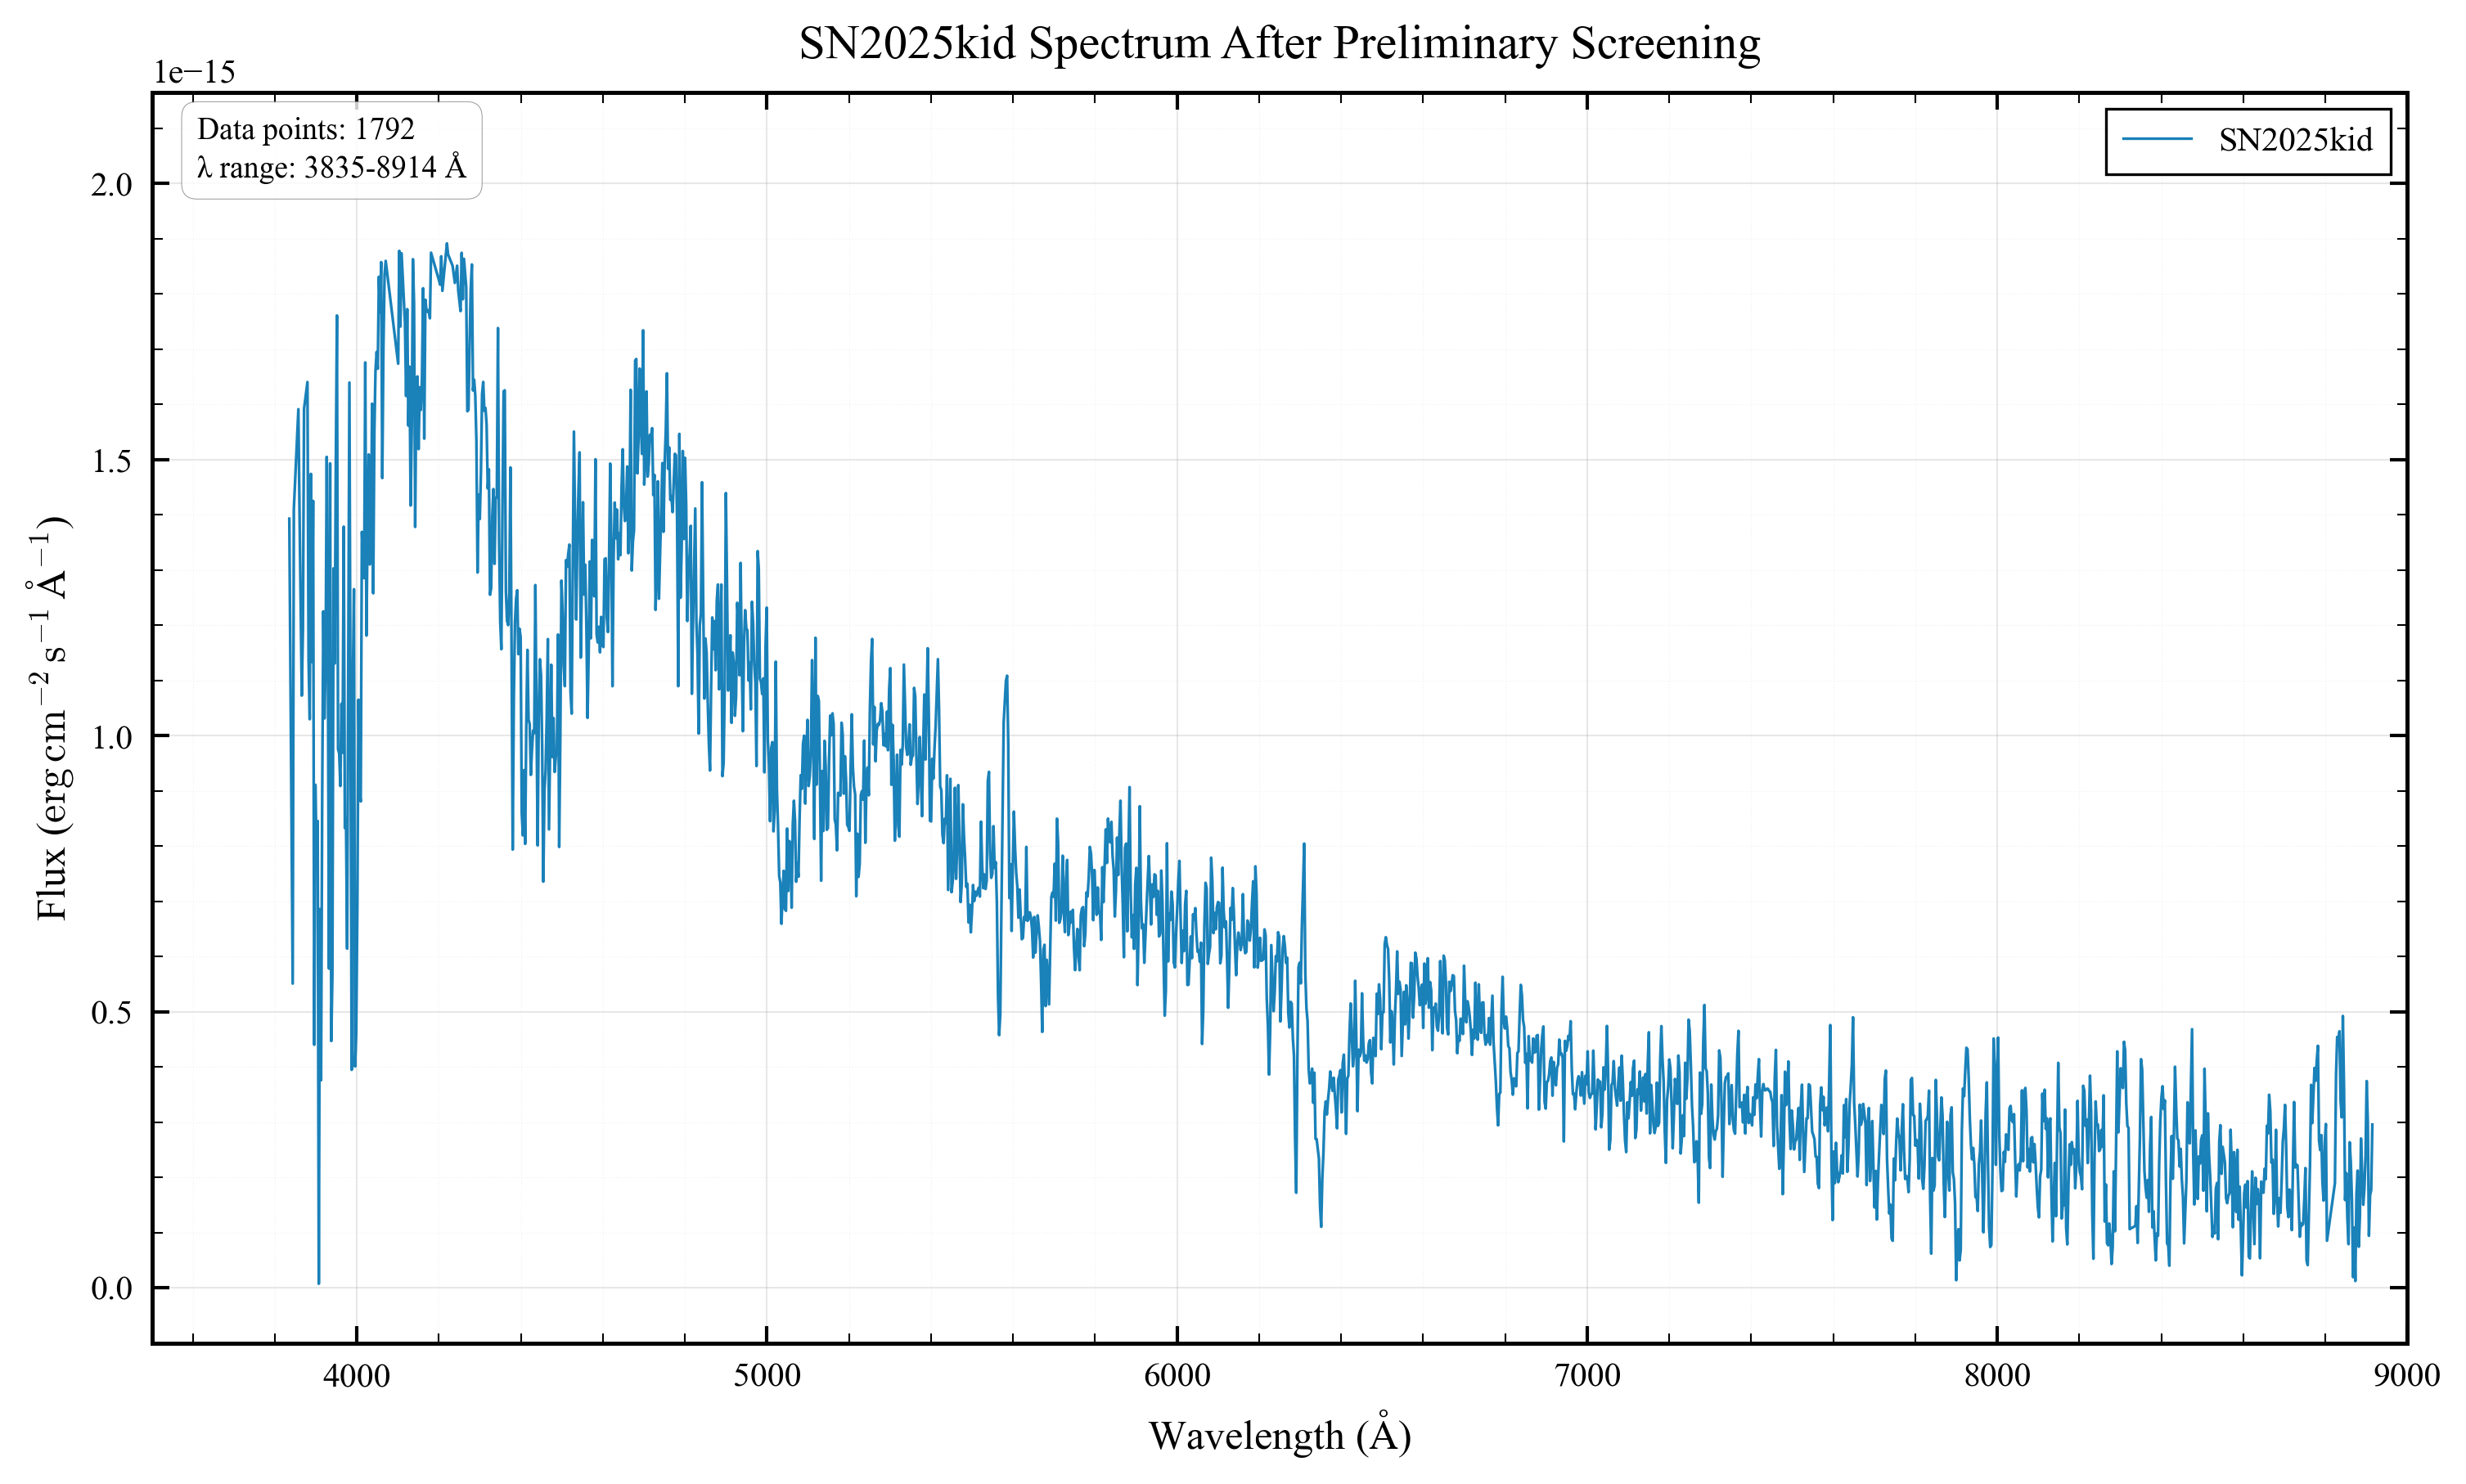

In [151]:
# 绘制经过初级筛选的SED图像
# 1. 基础数据清洗：过滤掉flux<=0的数据点
valid_mask = flux1 > 0

# 2. 波长范围截取（SNID典型范围）
wavelength_mask = (wav1 > 3600) & (wav1 < 9200)
combined_mask = valid_mask & wavelength_mask

# 3. 去除异常值
if np.any(combined_mask):  # 确保有有效数据
    flux_temp = flux1[combined_mask]
    # 使用中位数和MAD（Median Absolute Deviation）
    median_flux = np.median(flux_temp)
    mad = np.median(np.abs(flux_temp - median_flux))
    # 去除偏离中位数太远的点
    outlier_mask = np.abs(flux1 - median_flux) < 5 * mad
    combined_mask = combined_mask & outlier_mask

# 应用所有掩码
wav1_clean = wav1[combined_mask]
flux1_clean = flux1[combined_mask]

# 打印数据处理信息
print(f"Original data points: {len(wav1)}")
print(f"After cleaning: {len(wav1_clean)}")
print(f"Wavelength range: {wav1_clean.min():.1f} - {wav1_clean.max():.1f} Å")

# 设置科学风格
plt.style.use('seaborn-v0_8-paper')
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif'],
    'font.size': 11,
    'axes.linewidth': 1.2,
    'axes.edgecolor': 'black',
    'axes.labelsize': 12,
    'axes.labelweight': 'normal',
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'xtick.major.width': 1.0,
    'ytick.major.width': 1.0,
    'xtick.minor.width': 0.5,
    'ytick.minor.width': 0.5,
    'mathtext.fontset': 'cm'
})

# 在绘图之前添加这些可选的处理步骤，这里的步骤并非最终的图像处理。

# 4. 数据平滑（可选，去除高频噪声）
from scipy.ndimage import gaussian_filter1d
# 轻微平滑，保留光谱特征
flux1_smooth = gaussian_filter1d(flux1_clean, sigma=2.0)

# 5. 重采样到均匀波长网格（可选）
from scipy.interpolate import interp1d
wav_uniform = np.arange(3600, 9200, 1)  # 1Å步长
f_interp = interp1d(wav1_clean, flux1_clean, kind='cubic', 
                    bounds_error=False, fill_value=np.nan)
flux_uniform = f_interp(wav_uniform)

# 移除插值产生的NaN
valid_uniform = ~np.isnan(flux_uniform)
wav_uniform = wav_uniform[valid_uniform]
flux_uniform = flux_uniform[valid_uniform]

# 然后使用处理后的数据绘图

# 创建图形（使用SNID风格的尺寸）
fig, ax = plt.subplots(figsize=(10, 6))

# 绘制数据，这里使用的是_clean后的数据
ax.plot(wav1_clean, flux1_clean, '-', linewidth=0.8, color='#0173B2',
        label='SN2025kid', zorder=10, alpha=0.9)

# 设置坐标轴标签
ax.set_xlabel(r'Wavelength ($\mathrm{\AA}$)', fontsize=12)
ax.set_ylabel(r'Flux ($\mathrm{erg\,cm^{-2}\,s^{-1}\,\AA^{-1}}$)', fontsize=12)

# 四边框架
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.2)

# 刻度设置
ax.tick_params(direction='in', top=True, right=True, 
               labelsize=10, length=5, width=1.0)
ax.minorticks_on()
ax.tick_params(which='minor', direction='in', top=True, right=True,
               length=3, width=0.5)

# 网格设置
ax.grid(True, which='major', alpha=0.3, linestyle='-', linewidth=0.5, zorder=0)
ax.grid(True, which='minor', alpha=0.15, linestyle=':', linewidth=0.3, zorder=0)

# 动态Y轴范围（使用百分位数避免极值影响）
ymin = np.percentile(flux1_clean, 1)
ymax = np.percentile(flux1_clean, 99)
yrange = ymax - ymin
ax.set_ylim(ymin - yrange * 0.1, ymax + yrange * 0.2)  # 底部10%，顶部20%空白

# X轴范围（设置为SNID标准范围）
ax.set_xlim(3500, 9000)  # 固定范围，便于比较

# 图例（放在最佳位置）
legend = ax.legend(frameon=True, fancybox=False, edgecolor='black',
                   fontsize=10, loc='best', framealpha=1.0,
                   borderpad=0.5, labelspacing=0.5)
legend.get_frame().set_linewidth(0.8)

# 添加标题
ax.set_title('SN2025kid Spectrum After Preliminary Screening', fontsize=14, pad=10)

# 添加数据信息文本框（可选）
info_text = f'Data points: {len(flux1_clean)}\n'
info_text += f'λ range: {wav1_clean.min():.0f}-{wav1_clean.max():.0f} Å'
ax.text(0.02, 0.98, info_text, transform=ax.transAxes,
        fontsize=9, verticalalignment='top',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                  edgecolor='gray', alpha=0.8))

# 优化布局
plt.tight_layout(pad=0.5)

# 保存图形（使用类似SNID的命名方式）
# output_filename = 'spectrum_SN2025kid_processed.png'  # 或 .pdf
# plt.savefig(output_filename, bbox_inches='tight', dpi=300)
# print(f'Figure saved as: {output_filename}')

## Data Analysis

This section preserves the process of code optimization process; the final results can be directly found at the end of Data Analysis (Ultimate Part).

### Raw processing

##### <small> The following is a somewhat unsuccessful data processing; although smoothing was completed, the absorption peak at 4000 Å was poorly preserved. Therefore, it was commented out.<small>

In [152]:
'''
#数据处理函数
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, interpolate
from scipy.ndimage import median_filter, gaussian_filter1d
from astropy.stats import sigma_clip
import warnings
warnings.filterwarnings('ignore')

class SpectrumProcessor:
    """
    专业的光谱数据处理类
    """
    def __init__(self, wavelength, flux, verbose=True):
        self.wav_raw = np.array(wavelength)
        self.flux_raw = np.array(flux)
        self.wav = None
        self.flux = None
        self.mask = np.ones(len(wavelength), dtype=bool)
        self.verbose = verbose
        self.processing_log = []
        
    def basic_cleaning(self, remove_negative=True, remove_zero=True):
        """基础数据清洗"""
        initial_count = np.sum(self.mask)
        
        # 去除NaN和inf
        self.mask &= np.isfinite(self.flux_raw) & np.isfinite(self.wav_raw)
        
        # 去除负值
        if remove_negative:
            self.mask &= (self.flux_raw > 0)
            
        # 去除零值
        if remove_zero:
            self.mask &= (self.flux_raw != 0)
            
        removed = initial_count - np.sum(self.mask)
        self._log(f"Basic cleaning: removed {removed} points")
        return self
        
    def wavelength_cut(self, wmin=3600, wmax=9200):
        """波长范围截取"""
        initial_count = np.sum(self.mask)
        self.mask &= (self.wav_raw >= wmin) & (self.wav_raw <= wmax)
        removed = initial_count - np.sum(self.mask)
        self._log(f"Wavelength cut [{wmin}-{wmax}]: removed {removed} points")
        return self
        
    def remove_cosmic_rays(self, threshold=5, window=5):
        """去除宇宙线（尖峰）"""
        flux_temp = self.flux_raw[self.mask]
        wav_temp = self.wav_raw[self.mask]
        
        # 使用中值滤波检测尖峰
        flux_median = median_filter(flux_temp, size=window)
        residuals = flux_temp - flux_median
        mad = np.median(np.abs(residuals - np.median(residuals)))
        
        # 标记宇宙线
        cosmic_mask = np.abs(residuals) < threshold * mad
        
        # 更新总体掩码
        temp_mask = self.mask.copy()
        temp_mask[self.mask] &= cosmic_mask
        removed = np.sum(self.mask) - np.sum(temp_mask)
        self.mask = temp_mask
        
        self._log(f"Cosmic ray removal: removed {removed} spikes")
        return self
        
    def sigma_clipping(self, sigma=3, maxiters=5):
        """Sigma裁剪去除异常值"""
        flux_temp = self.flux_raw[self.mask]
        
        # 使用astropy的sigma_clip
        clipped_data = sigma_clip(flux_temp, sigma=sigma, maxiters=maxiters)
        clip_mask = ~clipped_data.mask
        
        # 更新掩码
        temp_mask = self.mask.copy()
        temp_mask[self.mask] &= clip_mask
        removed = np.sum(self.mask) - np.sum(temp_mask)
        self.mask = temp_mask
        
        self._log(f"Sigma clipping ({sigma}σ): removed {removed} outliers")
        return self
        
    def snr_filter(self, min_snr=3, window=50):
        """基于信噪比的筛选"""
        flux_temp = self.flux_raw[self.mask]
        wav_temp = self.wav_raw[self.mask]
        
        # 计算局部信噪比
        snr = np.zeros_like(flux_temp)
        half_window = window // 2
        
        for i in range(len(flux_temp)):
            start = max(0, i - half_window)
            end = min(len(flux_temp), i + half_window)
            local_flux = flux_temp[start:end]
            if len(local_flux) > 3:
                noise = np.std(local_flux)
                if noise > 0:
                    snr[i] = flux_temp[i] / noise
                    
        # 应用SNR筛选
        snr_mask = snr >= min_snr
        
        temp_mask = self.mask.copy()
        temp_mask[self.mask] &= snr_mask
        removed = np.sum(self.mask) - np.sum(temp_mask)
        self.mask = temp_mask
        
        self._log(f"SNR filter (min={min_snr}): removed {removed} low SNR points")
        return self
        
    def edge_trimming(self, trim_percent=2):
        """去除光谱边缘的低质量数据"""
        flux_temp = self.flux_raw[self.mask]
        wav_temp = self.wav_raw[self.mask]
        
        if len(wav_temp) > 0:
            n_trim = int(len(wav_temp) * trim_percent / 100)
            edge_mask = np.ones(len(wav_temp), dtype=bool)
            if n_trim > 0:
                edge_mask[:n_trim] = False
                edge_mask[-n_trim:] = False
                
            temp_mask = self.mask.copy()
            temp_mask[self.mask] &= edge_mask
            removed = np.sum(self.mask) - np.sum(temp_mask)
            self.mask = temp_mask
            
            self._log(f"Edge trimming ({trim_percent}%): removed {removed} edge points")
        return self
        
    def interpolate_gaps(self, max_gap=10):
        """插值填补小的数据缺口"""
        wav_clean = self.wav_raw[self.mask]
        flux_clean = self.flux_raw[self.mask]
        
        # 检查是否需要插值
        if len(wav_clean) < len(self.wav_raw) * 0.9:  # 如果丢失超过10%的数据
            # 找到缺口
            wav_diff = np.diff(wav_clean)
            median_diff = np.median(wav_diff)
            
            # 创建均匀网格
            wav_uniform = np.arange(wav_clean.min(), wav_clean.max(), median_diff)
            
            # 插值
            f = interpolate.interp1d(wav_clean, flux_clean, kind='linear',
                                   bounds_error=False, fill_value=np.nan)
            flux_uniform = f(wav_uniform)
            
            # 更新数据
            valid = ~np.isnan(flux_uniform)
            self.wav = wav_uniform[valid]
            self.flux = flux_uniform[valid]
            self._log(f"Interpolated to uniform grid: {len(self.wav)} points")
        else:
            self.wav = wav_clean
            self.flux = flux_clean
        return self
        
    def smooth(self, method='gaussian', window=3):
        """平滑处理"""
        if self.flux is None:
            self.wav = self.wav_raw[self.mask]
            self.flux = self.flux_raw[self.mask]
            
        if method == 'gaussian':
            self.flux = gaussian_filter1d(self.flux, sigma=window)
        elif method == 'median':
            self.flux = median_filter(self.flux, size=int(window))
        elif method == 'savgol':
            window_length = int(window) if int(window) % 2 == 1 else int(window) + 1
            self.flux = signal.savgol_filter(self.flux, window_length, 3)
            
        self._log(f"Applied {method} smoothing (window={window})")
        return self
        
    def get_processed_data(self):
        """获取处理后的数据"""
        if self.wav is None:
            self.wav = self.wav_raw[self.mask]
            self.flux = self.flux_raw[self.mask]
        return self.wav, self.flux
        
    def get_statistics(self):
        """获取数据统计信息"""
        if self.wav is None:
            self.get_processed_data()
            
        stats = {
            'original_points': len(self.wav_raw),
            'processed_points': len(self.wav),
            'removed_points': len(self.wav_raw) - len(self.wav),
            'removal_rate': (1 - len(self.wav)/len(self.wav_raw)) * 100,
            'wavelength_range': (self.wav.min(), self.wav.max()),
            'flux_range': (self.flux.min(), self.flux.max()),
            'mean_flux': np.mean(self.flux),
            'median_flux': np.median(self.flux),
            'std_flux': np.std(self.flux)
        }
        return stats
        
    def plot_diagnostic(self, figsize=(12, 8)):
        """生成诊断图"""
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        
        # 1. 原始vs处理后
        ax = axes[0, 0]
        ax.plot(self.wav_raw, self.flux_raw, 'k-', alpha=0.3, 
                linewidth=0.5, label='Original')
        if self.wav is not None:
            ax.plot(self.wav, self.flux, 'b-', linewidth=1, 
                    label='Processed')
        ax.set_xlabel('Wavelength (Å)')
        ax.set_ylabel('Flux')
        ax.set_title('Original vs Processed')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 2. 被移除的点
        ax = axes[0, 1]
        removed_mask = ~self.mask
        if np.any(removed_mask):
            ax.scatter(self.wav_raw[removed_mask], self.flux_raw[removed_mask], 
                      c='r', s=20, alpha=0.6, label='Removed points')
        ax.plot(self.wav_raw[self.mask], self.flux_raw[self.mask], 
                'g-', linewidth=0.5, alpha=0.5, label='Kept points')
        ax.set_xlabel('Wavelength (Å)')
        ax.set_ylabel('Flux')
        ax.set_title('Removed Points Distribution')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 3. 局部信噪比
        ax = axes[1, 0]
        if self.wav is not None and len(self.wav) > 50:
            snr = np.zeros_like(self.flux)
            window = 50
            for i in range(len(self.flux)):
                start = max(0, i - window//2)
                end = min(len(self.flux), i + window//2)
                local_std = np.std(self.flux[start:end])
                if local_std > 0:
                    snr[i] = self.flux[i] / local_std
            ax.plot(self.wav, snr, 'g-', linewidth=1)
            ax.axhline(y=3, color='r', linestyle='--', label='SNR=3')
            ax.set_xlabel('Wavelength (Å)')
            ax.set_ylabel('Local SNR')
            ax.set_title('Signal-to-Noise Ratio')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        # 4. 处理日志
        ax = axes[1, 1]
        ax.axis('off')
        log_text = "Processing Log:\n\n"
        for i, log in enumerate(self.processing_log[-10:]):  # 最后10条
            log_text += f"{i+1}. {log}\n"
        ax.text(0.05, 0.95, log_text, transform=ax.transAxes,
                fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plt.tight_layout()
        return fig
        
    def _log(self, message):
        """记录处理步骤"""
        if self.verbose:
            print(message)
        self.processing_log.append(message)

# 使用示例
def process_spectrum_advanced(wav1, flux1):
    """
    高级光谱处理流程
    """
    # 创建处理器实例
    processor = SpectrumProcessor(wav1, flux1)
    
    # 执行处理链
    processor.basic_cleaning()\
             .wavelength_cut(3600, 9200)\
             .remove_cosmic_rays(threshold=5)\
             .sigma_clipping(sigma=3)\
             .edge_trimming(trim_percent=1)\
             .snr_filter(min_snr=2)\
             .smooth(method='gaussian', window=2)
    
    # 获取处理后的数据
    wav_clean, flux_clean = processor.get_processed_data()
    
    # 打印统计信息
    stats = processor.get_statistics()
    print("\n=== Processing Statistics ===")
    for key, value in stats.items():
        print(f"{key}: {value}")
    
    # 生成诊断图
    fig_diag = processor.plot_diagnostic()
    
    return wav_clean, flux_clean, processor
'''

'\n#数据处理函数\nimport numpy as np\nimport matplotlib.pyplot as plt\nfrom scipy import signal, interpolate\nfrom scipy.ndimage import median_filter, gaussian_filter1d\nfrom astropy.stats import sigma_clip\nimport warnings\nwarnings.filterwarnings(\'ignore\')\n\nclass SpectrumProcessor:\n    """\n    专业的光谱数据处理类\n    """\n    def __init__(self, wavelength, flux, verbose=True):\n        self.wav_raw = np.array(wavelength)\n        self.flux_raw = np.array(flux)\n        self.wav = None\n        self.flux = None\n        self.mask = np.ones(len(wavelength), dtype=bool)\n        self.verbose = verbose\n        self.processing_log = []\n        \n    def basic_cleaning(self, remove_negative=True, remove_zero=True):\n        """基础数据清洗"""\n        initial_count = np.sum(self.mask)\n        \n        # 去除NaN和inf\n        self.mask &= np.isfinite(self.flux_raw) & np.isfinite(self.wav_raw)\n        \n        # 去除负值\n        if remove_negative:\n            self.mask &= (self.flux_raw > 0)\n          

In [153]:
'''
# 使用高级处理
wav_clean, flux_clean, processor = process_spectrum_advanced(wav1, flux1)

# 继续绘图代码
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(wav_clean, flux_clean, '-', linewidth=0.8, color='#0173B2',
        label='Processed spectrum', zorder=10, alpha=0.9)

# ... 其余的绘图设置保持不变 ...'''

"\n# 使用高级处理\nwav_clean, flux_clean, processor = process_spectrum_advanced(wav1, flux1)\n\n# 继续绘图代码\nfig, ax = plt.subplots(figsize=(10, 6))\nax.plot(wav_clean, flux_clean, '-', linewidth=0.8, color='#0173B2',\n        label='Processed spectrum', zorder=10, alpha=0.9)\n\n# ... 其余的绘图设置保持不变 ..."

### Initial data processing.

In [154]:
from scipy import signal, interpolate
from scipy.ndimage import median_filter, gaussian_filter1d
from astropy.stats import sigma_clip
import warnings
warnings.filterwarnings('ignore')

class SpectroscopyProcessor:  # 主要内容：保护吸收/发射线特征
    def __init__(self, wavelength, flux, verbose=True):
        # 保留原始的波长与通量
        self.wav_raw = np.array(wavelength)
        self.flux_raw = np.array(flux)
        # 初始化处理后的波长与通量
        self.wav = None
        self.flux = None
        # 初始化掩码，默认全部保留,用于标记哪些数据点是有效的
        self.mask = np.ones(len(wavelength), dtype=bool)
        # 是否启用详细日志记录
        self.verbose = verbose
        # 初始化处理日志
        self.processing_log = []
    
    def _log(self, message):
        #记录处理步骤
        if self.verbose:
            print(message)
        self.processing_log.append(message)
    
    def get_processed_data(self):
        #获取处理后的数据
        if self.wav is None:
            self.wav = self.wav_raw[self.mask]
            self.flux = self.flux_raw[self.mask]
        return self.wav, self.flux
    
    def get_statistics(self):
        #获取数据统计信息
        if self.wav is None:
            self.get_processed_data()
            
        stats = {
            'original_points': len(self.wav_raw),
            'processed_points': len(self.wav),
            'removed_points': len(self.wav_raw) - len(self.wav),
            'removal_rate': (1 - len(self.wav)/len(self.wav_raw)) * 100,
            'wavelength_range': (self.wav.min(), self.wav.max()),
            'flux_range': (self.flux.min(), self.flux.max()),
            'mean_flux': np.mean(self.flux),
            'median_flux': np.median(self.flux),
            'std_flux': np.std(self.flux)
        }
        return stats
        
    def basic_cleaning(self):
        """
        基础数据清洗
        
        基本逻辑：
        - 去除NaN和inf：这些是仪器故障或数据传输错误
        - 保留负值：吸收线可能使连续谱减法后出现负值
        - 去除精确零值：通常是坏像素或未曝光区域
        """
        initial_count = np.sum(self.mask)
        
        # 只去除无效数值
        self.mask &= np.isfinite(self.flux_raw) & np.isfinite(self.wav_raw)
        
        # 只去除精确为0的点（不是接近0）
        self.mask &= (self.flux_raw != 0)
        
        removed = initial_count - np.sum(self.mask)
        self._log(f"Basic cleaning: removed {removed} invalid points (NaN/inf/exact zero)")
        return self
        
    def wavelength_cut(self, wmin=3600, wmax=9200):
        """
        波长范围截取
        
        逻辑：
        - CCD响应在边缘急剧下降
        - 大气吸收在某些波段使数据不可用
        - 3600-9200Å是光学光谱仪的典型有效范围
        """
        initial_count = np.sum(self.mask)
        self.mask &= (self.wav_raw >= wmin) & (self.wav_raw <= wmax)
        removed = initial_count - np.sum(self.mask)
        self._log(f"Wavelength cut [{wmin}-{wmax}Å]: removed {removed} points outside range")
        return self
        
    def remove_cosmic_rays_conservative(self, threshold=10, window=5):
        """
        保守的宇宙线去除 - 只去除明显的正向尖峰
        
        逻辑：
        - 宇宙线在CCD上产生尖锐的正向峰
        - 真实的发射线通常覆盖多个像素
        - 吸收线是负向的，不应被此方法影响
        
        参数：
        - threshold: 相对于局部中值的倍数（默认10，非常保守）
        - window: 中值滤波窗口大小
        """
        flux_temp = self.flux_raw[self.mask]
        wav_temp = self.wav_raw[self.mask]
        
        if len(flux_temp) < window:
            self._log("Cosmic ray removal: skipped (insufficient points)")
            return self
        
        # 使用中值滤波作为基线
        flux_median = median_filter(flux_temp, size=window)
        
        # 只检测正向偏离
        positive_residuals = flux_temp - flux_median
        
        # 计算正向偏离的统计
        positive_only = positive_residuals[positive_residuals > 0]
        if len(positive_only) > 0:
            mad_positive = np.median(np.abs(positive_only - np.median(positive_only)))
            
            # 只标记极端的正向尖峰
            cosmic_mask = positive_residuals < threshold * mad_positive
        else:
            cosmic_mask = np.ones(len(flux_temp), dtype=bool)
        
        # 额外检查：宇宙线应该是孤立的
        for i in range(1, len(cosmic_mask)-1):
            if not cosmic_mask[i]:  # 如果被标记为宇宙线
                # 检查是否是孤立点
                if cosmic_mask[i-1] and cosmic_mask[i+1]:  # 邻近点正常
                    continue  # 确认是宇宙线
                else:
                    cosmic_mask[i] = True  # 可能是真实特征，恢复
        
        temp_mask = self.mask.copy()
        temp_mask[self.mask] &= cosmic_mask
        removed = np.sum(self.mask) - np.sum(temp_mask)
        self.mask = temp_mask
        
        self._log(f"Cosmic ray removal: removed {removed} isolated spikes")
        return self
        
    def asymmetric_sigma_clipping(self, sigma_upper=5, sigma_lower=10):
        """
        非对称sigma裁剪 - 对吸收线更宽容
        
        逻辑：
        - 天文光谱中吸收线是重要特征
        - 噪声通常是对称的，但真实特征可能不对称
        - 对负向偏离（吸收）使用更宽松的阈值
        """
        flux_temp = self.flux_raw[self.mask]
        
        if len(flux_temp) < 20:
            self._log("Asymmetric sigma clipping: skipped (insufficient points)")
            return self
        
        # 使用滑动窗口计算局部统计
        window_size = min(100, len(flux_temp) // 10)  # 自适应窗口大小
        clip_mask = np.ones(len(flux_temp), dtype=bool)
        
        for i in range(len(flux_temp)):
            # 定义局部窗口
            start = max(0, i - window_size//2)
            end = min(len(flux_temp), i + window_size//2)
            local_flux = flux_temp[start:end]
            
            if len(local_flux) > 10:
                # 使用中值和MAD（更稳健）
                local_median = np.median(local_flux)
                local_mad = np.median(np.abs(local_flux - local_median))
                
                if local_mad > 0:  # 避免除零
                    # 非对称阈值
                    if flux_temp[i] > local_median:  # 正向偏离
                        if flux_temp[i] > local_median + sigma_upper * local_mad * 1.4826:
                            clip_mask[i] = False
                    else:  # 负向偏离（吸收线）
                        if flux_temp[i] < local_median - sigma_lower * local_mad * 1.4826:
                            clip_mask[i] = False
        
        temp_mask = self.mask.copy()
        temp_mask[self.mask] &= clip_mask
        removed = np.sum(self.mask) - np.sum(temp_mask)
        self.mask = temp_mask
        
        self._log(f"Asymmetric sigma clipping (+{sigma_upper}σ/-{sigma_lower}σ): removed {removed} outliers")
        return self
        
    def edge_quality_filter(self, edge_percent=2, snr_threshold=2):
        """
        边缘质量过滤 - 基于信噪比而非固定百分比
        
        逻辑：
        - CCD边缘量子效率下降
        - 平场改正在边缘不准确
        - 使用SNR判断而非盲目裁剪
        """
        flux_temp = self.flux_raw[self.mask]
        wav_temp = self.wav_raw[self.mask]
        
        if len(wav_temp) > 100:  # 需要足够的点
            # 计算滑动SNR
            window = min(20, len(flux_temp) // 10)
            snr = np.zeros_like(flux_temp)
            
            for i in range(len(flux_temp)):
                start = max(0, i - window//2)
                end = min(len(flux_temp), i + window//2)
                local_flux = flux_temp[start:end]
                if len(local_flux) > 3:
                    local_std = np.std(local_flux)
                    if local_std > 0:
                        snr[i] = np.abs(np.mean(local_flux)) / local_std
            
            # 找到SNR下降的边界
            n_edge = int(len(flux_temp) * edge_percent / 100)
            
            # 检查左边缘
            edge_mask = np.ones(len(flux_temp), dtype=bool)
            for i in range(min(n_edge, len(flux_temp))):
                if snr[i] < snr_threshold:
                    edge_mask[i] = False
                else:
                    break  # 如果SNR足够好，停止裁剪
            
            # 检查右边缘
            for i in range(max(0, len(flux_temp) - n_edge), len(flux_temp)):
                if snr[i] < snr_threshold:
                    edge_mask[i] = False
                else:
                    break
            
            temp_mask = self.mask.copy()
            temp_mask[self.mask] &= edge_mask
            removed = np.sum(self.mask) - np.sum(temp_mask)
            self.mask = temp_mask
            
            self._log(f"Edge quality filter: removed {removed} low-quality edge points")
        else:
            self._log("Edge quality filter: skipped (insufficient points)")
        return self
        
    def feature_preserving_smooth(self, preserve_width=10, smooth_sigma=1):
        """
        特征保护平滑 - 保护吸收/发射线
        
        逻辑：
        - 高频噪声需要平滑
        - 真实的谱线特征必须保留
        - 使用自适应平滑：在谱线附近减少平滑
        """
        if self.flux is None:
            self.wav = self.wav_raw[self.mask]
            self.flux = self.flux_raw[self.mask]
        
        if len(self.flux) < 10:
            self._log("Feature-preserving smooth: skipped (insufficient points)")
            return self
        
        # 检测显著特征
        flux_smooth_temp = gaussian_filter1d(self.flux, sigma=min(5, len(self.flux)//20))
        flux_derivative = np.abs(np.gradient(flux_smooth_temp))
        
        # 标记特征区域
        feature_threshold = np.percentile(flux_derivative, 90)
        
        # 自适应平滑
        flux_smoothed = np.zeros_like(self.flux)
        
        for i in range(len(self.flux)):
            # 检查是否在特征附近
            start = max(0, i - preserve_width)
            end = min(len(self.flux), i + preserve_width)
            
            if np.any(flux_derivative[start:end] > feature_threshold):
                # 在特征附近，减少或不平滑
                flux_smoothed[i] = self.flux[i]
            else:
                # 远离特征，可以平滑
                start_smooth = max(0, i - 3)
                end_smooth = min(len(self.flux), i + 3)
                flux_smoothed[i] = np.mean(self.flux[start_smooth:end_smooth])
        
        # 轻微的全局平滑
        self.flux = 0.7 * flux_smoothed + 0.3 * gaussian_filter1d(self.flux, sigma=smooth_sigma)
        
        self._log(f"Applied feature-preserving smoothing")
        return self
        
    def validate_spectrum(self):
        """
        光谱完整性验证
        
        检查处理后的光谱是否保留了关键特征
        """
        if self.wav is None:
            self.get_processed_data()
            
        # 检查是否还有足够的数据点
        if len(self.wav) < 100:
            self._log("WARNING: Less than 100 points remaining!")
            
        # 检查是否有大的波长间隙
        if len(self.wav) > 1:
            wav_diff = np.diff(self.wav)
            median_diff = np.median(wav_diff)
            large_gaps = wav_diff > 5 * median_diff
            if np.any(large_gaps):
                gap_positions = self.wav[:-1][large_gaps]
                self._log(f"WARNING: Large gaps detected at wavelengths: {gap_positions}")
            
        return self

# 更温和的处理函数 保护吸收线特征
def process_spectrum_conservative(wav1, flux1, diagnostic=True):
    processor = SpectroscopyProcessor(wav1, flux1)
    
    # 使用保守的处理链
    processor.basic_cleaning()\
             .wavelength_cut(3600, 9200)\
             .remove_cosmic_rays_conservative(threshold=15, window=5)\
             .asymmetric_sigma_clipping(sigma_upper=5, sigma_lower=10)\
             .edge_quality_filter(edge_percent=1, snr_threshold=2)\
             .feature_preserving_smooth(preserve_width=15, smooth_sigma=0.5)\
             .validate_spectrum()
    
    # 获取结果
    wav_clean, flux_clean = processor.get_processed_data()
    
    if diagnostic:
        # 生成诊断图
        fig = plot_processing_diagnostic(wav1, flux1, wav_clean, flux_clean, processor)
    
    return wav_clean, flux_clean, processor

def plot_processing_diagnostic(wav_raw, flux_raw, wav_clean, flux_clean, processor):
    # 重点显示吸收线保护效果
    fig, axes = plt.subplots(3, 1, figsize=(12, 10))
    
    # 1. 全光谱对比
    ax = axes[0]
    ax.plot(wav_raw, flux_raw, 'k-', alpha=0.3, linewidth=0.5, label='Original')
    ax.plot(wav_clean, flux_clean, 'b-', linewidth=1, label='Processed')
    ax.set_xlabel('Wavelength (Å)')
    ax.set_ylabel('Flux')
    ax.set_title('Full Spectrum Comparison')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. 4000Å附近的细节（检查吸收线）
    ax = axes[1]
    # 找到4000Å附近的数据
    mask_raw = (wav_raw > 3900) & (wav_raw < 4100)
    mask_clean = (wav_clean > 3900) & (wav_clean < 4100)
    
    if np.any(mask_raw):
        ax.plot(wav_raw[mask_raw], flux_raw[mask_raw], 'ko-', 
                markersize=4, alpha=0.5, linewidth=0.5, label='Original')
    if np.any(mask_clean):
        ax.plot(wav_clean[mask_clean], flux_clean[mask_clean], 'bo-', 
                markersize=3, linewidth=1, label='Processed')
    
    ax.set_xlabel('Wavelength (Å)')
    ax.set_ylabel('Flux')
    ax.set_title('Detail around 4000Å - Absorption Line Preservation')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim(3900, 4100)
    
    # 3. 处理统计
    ax = axes[2]
    ax.axis('off')
    
    stats_text = "Processing Summary:\n\n"
    stats = processor.get_statistics()
    stats_text += f"Original points: {stats['original_points']}\n"
    stats_text += f"Processed points: {stats['processed_points']}\n"
    stats_text += f"Removed: {stats['removed_points']} ({stats['removal_rate']:.1f}%)\n"
    stats_text += f"Wavelength range: {stats['wavelength_range'][0]:.1f} - {stats['wavelength_range'][1]:.1f} Å\n\n"
    
    stats_text += "Processing Steps:\n"
    for i, log in enumerate(processor.processing_log):
        stats_text += f"{i+1}. {log}\n"
    
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes,
            fontsize=10, verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    return fig

Basic cleaning: removed 0 invalid points (NaN/inf/exact zero)
Wavelength cut [3600-9200Å]: removed 0 points outside range
Cosmic ray removal: removed 13 isolated spikes
Asymmetric sigma clipping (+5σ/-10σ): removed 3 outliers
Edge quality filter: removed 7 low-quality edge points
Applied feature-preserving smoothing

=== 处理统计 ===
原始数据点: 1850
处理后数据点: 1827
去除率: 1.2%
波长范围: 3779.8 - 8914.3 Å


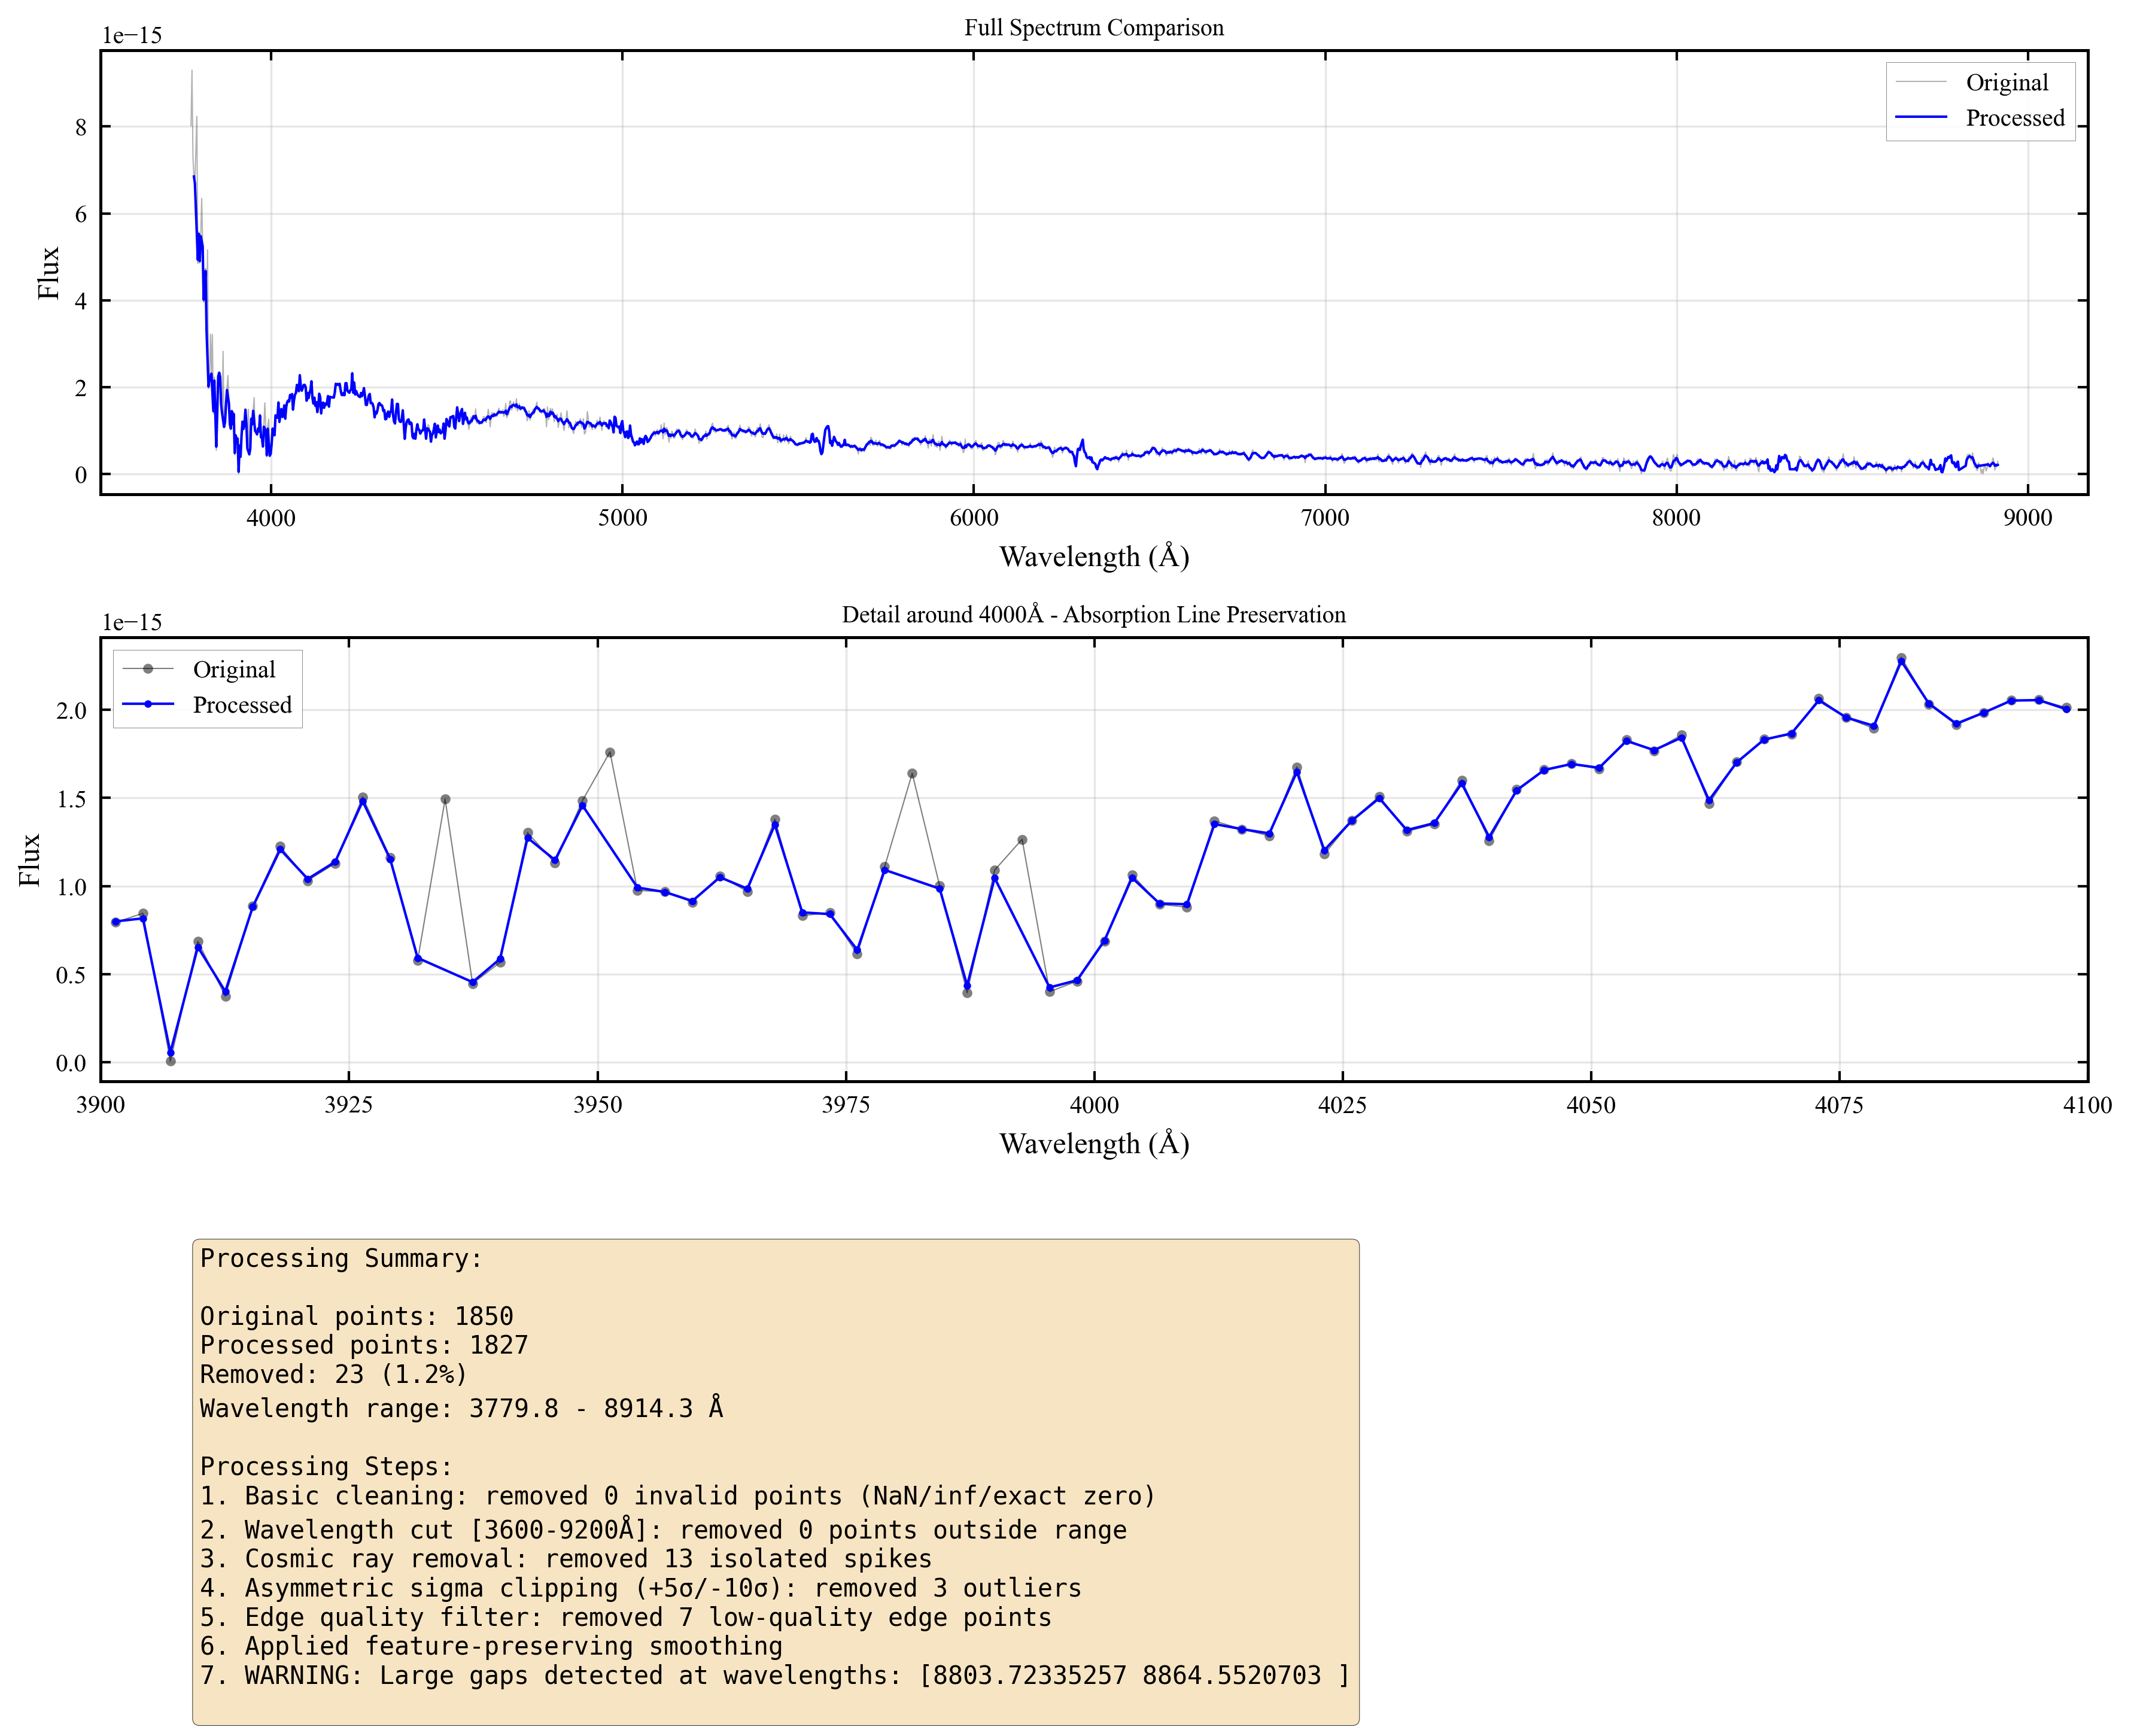

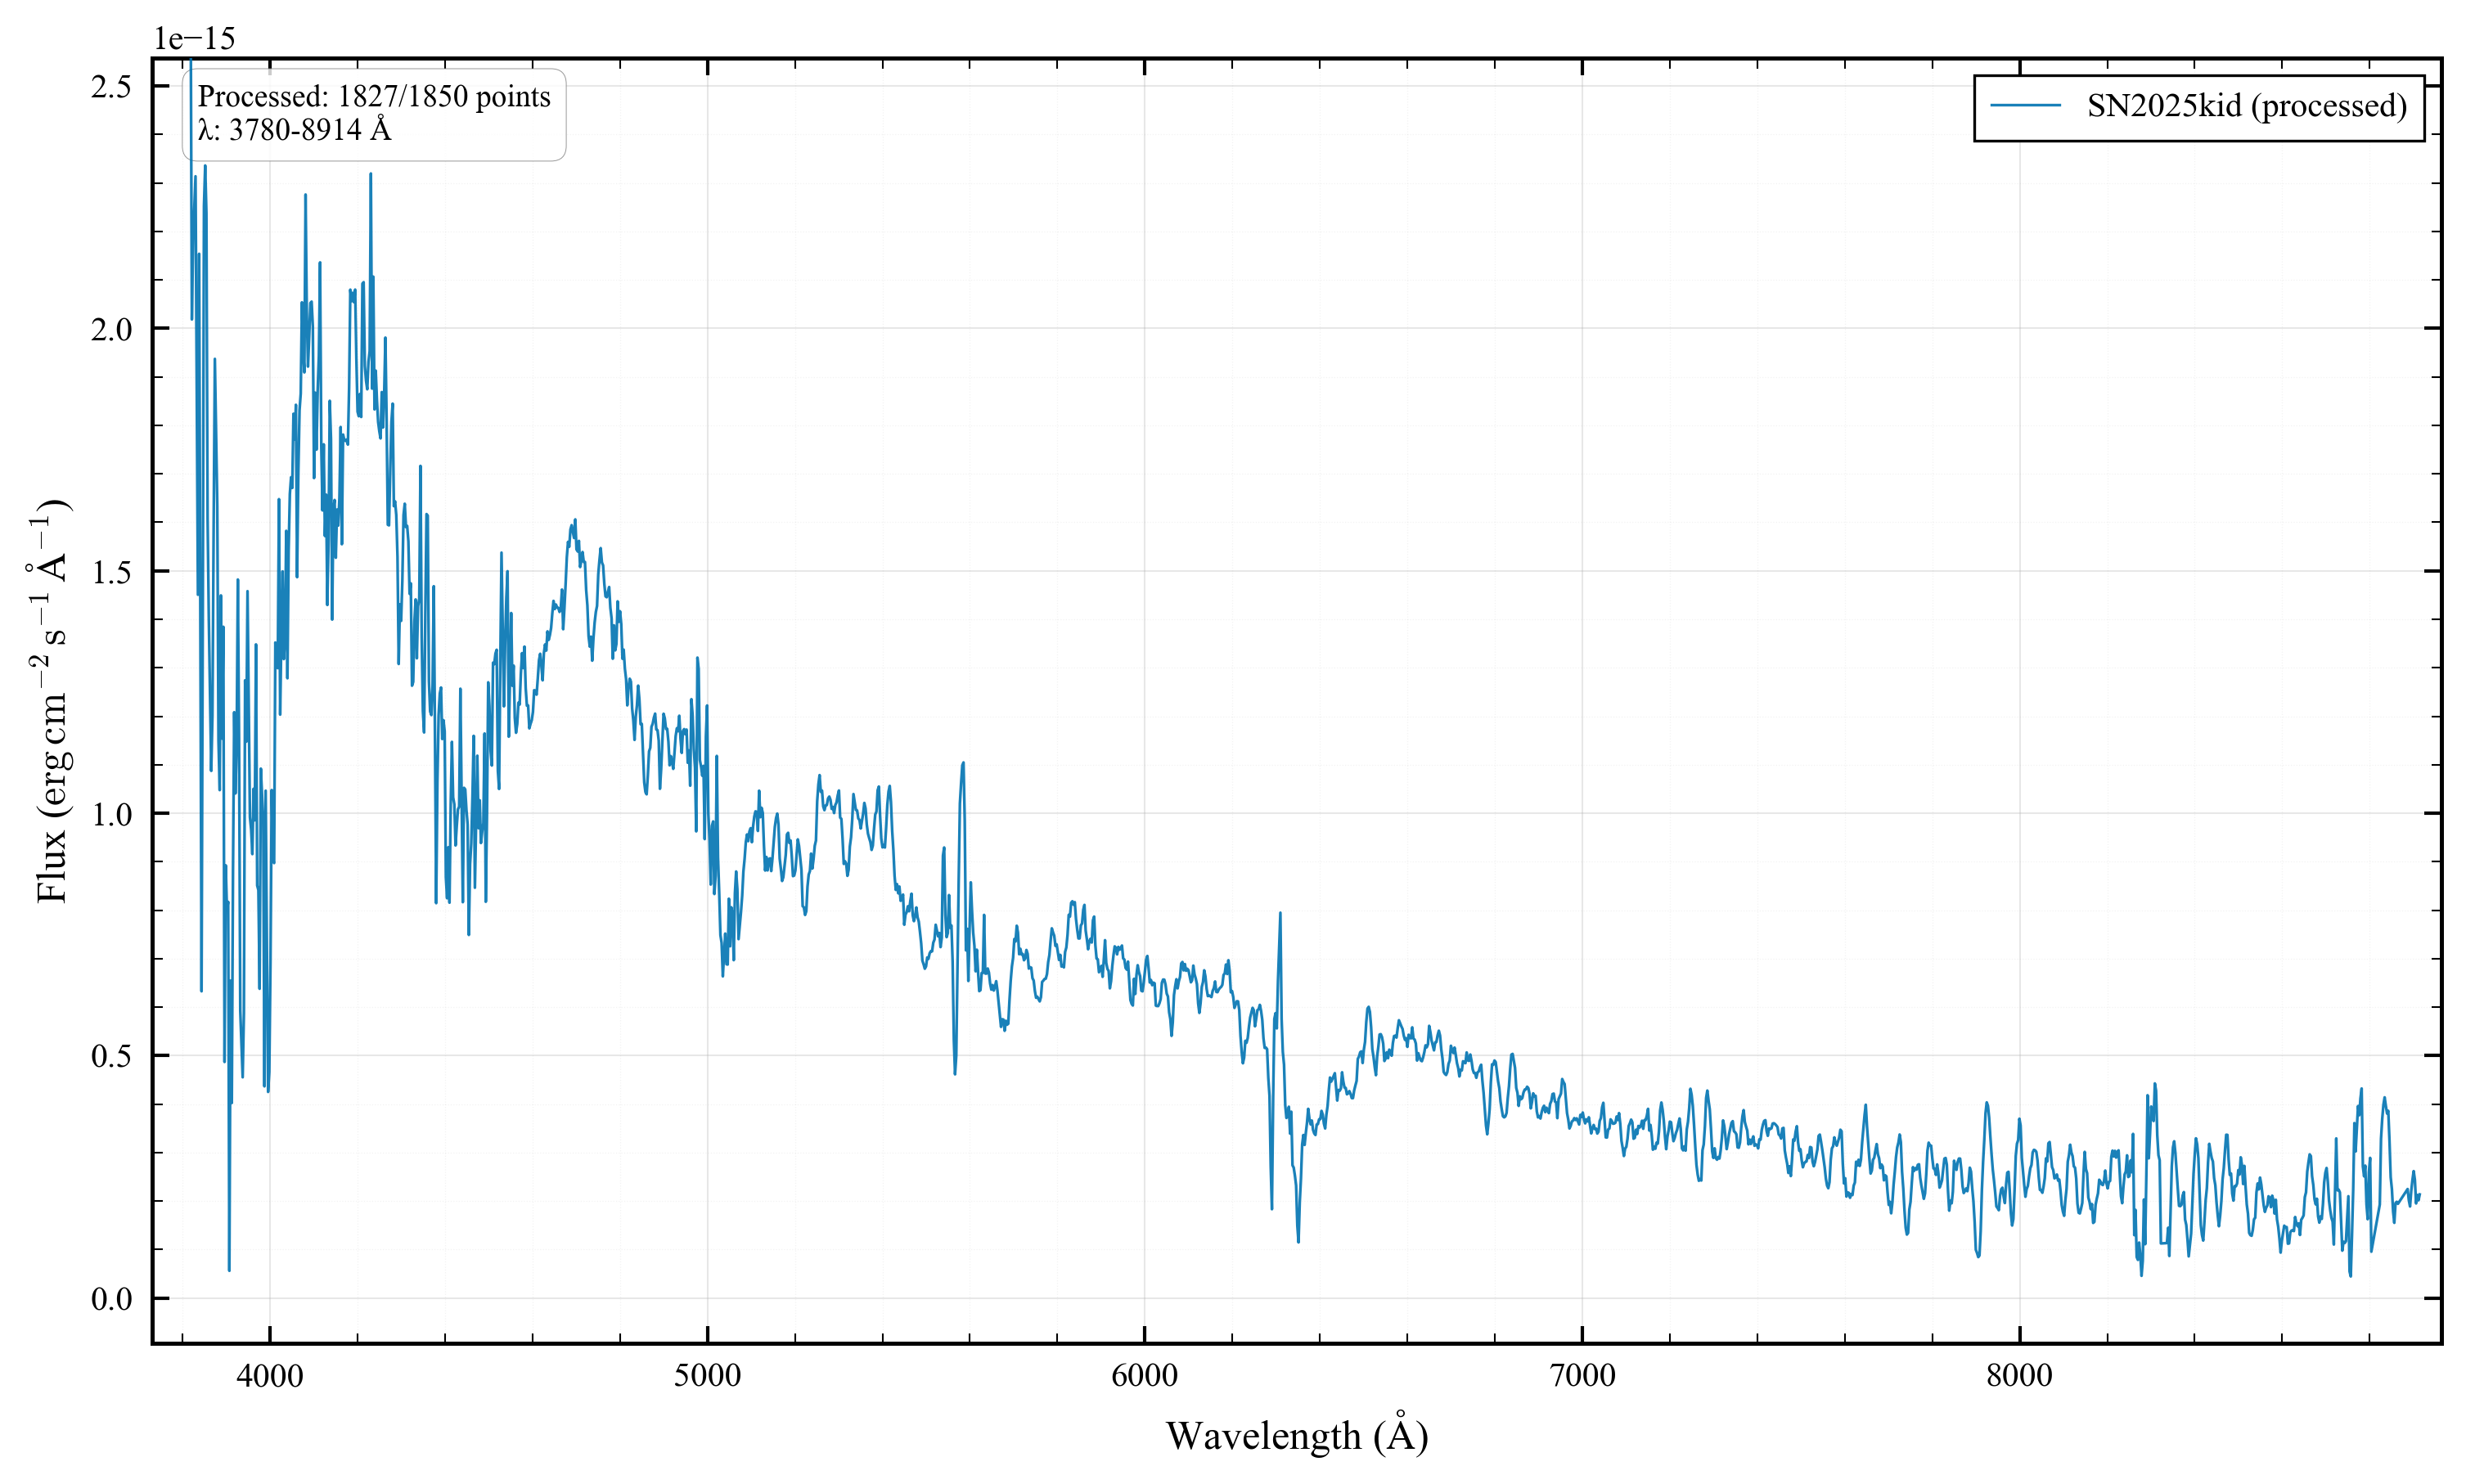

In [155]:
# wav1, flux1 = np.loadtxt('your_spectrum.dat', unpack=True)

# 方法1：带诊断图
wav_clean, flux_clean, processor = process_spectrum_conservative(wav1, flux1, diagnostic=True)

# 方法2：不要诊断图，只处理数据
# wav_clean, flux_clean, processor = process_spectrum_conservative(wav1, flux1, diagnostic=False)

# 方法3：自定义处理参数
# processor = SpectroscopyProcessor(wav1, flux1)
# processor.basic_cleaning()\
#          .wavelength_cut(3500, 9500)\  # 自定义波长范围
#          .remove_cosmic_rays_conservative(threshold=20)\  # 更保守的宇宙线去除
#          .asymmetric_sigma_clipping(sigma_upper=4, sigma_lower=15)\  # 更宽松的阈值
#          .feature_preserving_smooth(smooth_sigma=0.3)  # 更轻微的平滑
# wav_clean, flux_clean = processor.get_processed_data()

# 查看处理统计
print("\n=== 处理统计 ===")
stats = processor.get_statistics()
print(f"原始数据点: {stats['original_points']}")
print(f"处理后数据点: {stats['processed_points']}")
print(f"去除率: {stats['removal_rate']:.1f}%")
print(f"波长范围: {stats['wavelength_range'][0]:.1f} - {stats['wavelength_range'][1]:.1f} Å")

# 设置科学风格
plt.style.use('seaborn-v0_8-paper')
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif'],
    'font.size': 11,
    'axes.linewidth': 1.2,
    'axes.edgecolor': 'black',
    'axes.labelsize': 12,
    'axes.labelweight': 'normal',
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'xtick.major.width': 1.0,
    'ytick.major.width': 1.0,
    'xtick.minor.width': 0.5,
    'ytick.minor.width': 0.5,
    'mathtext.fontset': 'cm'
})

# 创建图形
fig, ax = plt.subplots(figsize=(10, 6))

# 绘制处理后的数据
ax.plot(wav_clean, flux_clean, '-', linewidth=0.8, color='#0173B2',
        label='SN2025kid (processed)', zorder=10, alpha=0.9)

# 设置坐标轴标签
ax.set_xlabel(r'Wavelength ($\mathrm{\AA}$)', fontsize=12)
ax.set_ylabel(r'Flux ($\mathrm{erg\,cm^{-2}\,s^{-1}\,\AA^{-1}}$)', fontsize=12)

# 四边框架
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.2)

# 刻度设置
ax.tick_params(direction='in', top=True, right=True, 
               labelsize=10, length=5, width=1.0)
ax.minorticks_on()
ax.tick_params(which='minor', direction='in', top=True, right=True,
               length=3, width=0.5)

# 网格设置
ax.grid(True, which='major', alpha=0.3, linestyle='-', linewidth=0.5, zorder=0)
ax.grid(True, which='minor', alpha=0.15, linestyle=':', linewidth=0.3, zorder=0)

# 动态Y轴范围（使用百分位数避免极值影响）
ymin = np.percentile(flux_clean, 1)
ymax = np.percentile(flux_clean, 99)
yrange = ymax - ymin
ax.set_ylim(ymin - yrange * 0.1, ymax + yrange * 0.2)

# X轴范围（设置为处理后的实际范围）
ax.set_xlim(wav_clean.min() - 50, wav_clean.max() + 50)

# 图例
legend = ax.legend(frameon=True, fancybox=False, edgecolor='black',
                   fontsize=10, loc='best', framealpha=1.0,
                   borderpad=0.5, labelspacing=0.5)
legend.get_frame().set_linewidth(0.8)

# 添加处理信息文本（可选）
info_text = f'Processed: {len(flux_clean)}/{len(flux1)} points\n'
info_text += f'λ: {wav_clean.min():.0f}-{wav_clean.max():.0f} Å'
ax.text(0.02, 0.98, info_text, transform=ax.transAxes,
        fontsize=9, verticalalignment='top',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                  edgecolor='gray', alpha=0.8))

# 优化布局
plt.tight_layout(pad=0.5)

# 保存图形
#plt.savefig('spectrum_processed.pdf', bbox_inches='tight', dpi=300)
#plt.show()

It can be seen that the figure reasonably delineates the effective spectral bands, handling the long-wave bands above 5000Å; however, the performance for the short-wave bands, particularly the absorption peak near 4000Å, is average.

Certainly, if we first compare this figure with the SN2025kid spectrum provided by Senior Huang for fitting purposes, we can observe that its processing quality is already quite satisfactory (with a high degree of overlap). However, the short-wavelength region lacks visual refinement, and therefore requires further optimization.

### Advanced Data Processing

#### <small>Below are two versions of data processing code based on the code above, each with distinct advantages and disadvantages. Due to their respective shortcomings, both have been commented out. <small>

##### <small>Below is the first version featuring a more refined class structure and multiple processing methods.<small>

In [156]:
'''
from scipy import signal, interpolate
from scipy.ndimage import median_filter, gaussian_filter1d
from astropy.stats import sigma_clip
from scipy.interpolate import UnivariateSpline
import warnings
warnings.filterwarnings('ignore')

class ImprovedSpectroscopyProcessor:
    """
    更强的离群点去除和平滑
    """
    def __init__(self, wavelength, flux, verbose=True):
        self.wav_raw = np.array(wavelength)
        self.flux_raw = np.array(flux)
        self.wav = None
        self.flux = None
        self.mask = np.ones(len(wavelength), dtype=bool)
        self.verbose = verbose
        self.processing_log = []
    
    def _log(self, message):
        """记录处理步骤"""
        if self.verbose:
            print(message)
        self.processing_log.append(message)
    
    def get_processed_data(self):
        """获取处理后的数据"""
        if self.wav is None:
            self.wav = self.wav_raw[self.mask]
            self.flux = self.flux_raw[self.mask]
        return self.wav, self.flux
    
    def get_statistics(self):
        """获取数据统计信息"""
        if self.wav is None:
            self.get_processed_data()
            
        stats = {
            'original_points': len(self.wav_raw),
            'processed_points': len(self.wav),
            'removed_points': len(self.wav_raw) - len(self.wav),
            'removal_rate': (1 - len(self.wav)/len(self.wav_raw)) * 100,
            'wavelength_range': (self.wav.min(), self.wav.max()),
            'flux_range': (self.flux.min(), self.flux.max()),
            'mean_flux': np.mean(self.flux),
            'median_flux': np.median(self.flux),
            'std_flux': np.std(self.flux)
        }
        return stats
        
    def basic_cleaning(self):
        """基础数据清洗"""
        initial_count = np.sum(self.mask)
        
        # 去除无效数值
        self.mask &= np.isfinite(self.flux_raw) & np.isfinite(self.wav_raw)
        
        # 去除零值和负值
        self.mask &= (self.flux_raw > 0)
        
        removed = initial_count - np.sum(self.mask)
        self._log(f"Basic cleaning: removed {removed} invalid points")
        return self
        
    def wavelength_cut(self, wmin=3600, wmax=9200):
        """波长范围截取"""
        initial_count = np.sum(self.mask)
        self.mask &= (self.wav_raw >= wmin) & (self.wav_raw <= wmax)
        removed = initial_count - np.sum(self.mask)
        self._log(f"Wavelength cut [{wmin}-{wmax}Å]: removed {removed} points")
        return self
    
    def iterative_outlier_removal(self, n_iterations=3, threshold=3):
        """
        迭代离群点去除 - 多次迭代以确保彻底清除
        """
        for iteration in range(n_iterations):
            initial_count = np.sum(self.mask)
            flux_temp = self.flux_raw[self.mask]
            
            if len(flux_temp) < 10:
                break
                
            # 使用中值滤波作为基线
            window_size = min(11, len(flux_temp) // 10)
            if window_size % 2 == 0:
                window_size += 1
                
            flux_median = median_filter(flux_temp, size=window_size)
            residuals = flux_temp - flux_median
            
            # 计算标准差（使用MAD）
            mad = np.median(np.abs(residuals - np.median(residuals)))
            std_robust = 1.4826 * mad
            
            # 标记离群点
            outlier_mask = np.abs(residuals) < threshold * std_robust
            
            # 更新掩码
            temp_mask = self.mask.copy()
            temp_mask[self.mask] &= outlier_mask
            
            removed = initial_count - np.sum(temp_mask)
            if removed == 0:
                break  # 没有更多离群点
                
            self.mask = temp_mask
            self._log(f"Iteration {iteration+1}: removed {removed} outliers")
            
        return self
    
    def local_outlier_removal(self, window=50, threshold=2.5):
        """
        局部离群点去除 - 使用滑动窗口检测局部异常
        """
        flux_temp = self.flux_raw[self.mask]
        wav_temp = self.wav_raw[self.mask]
        
        if len(flux_temp) < window:
            return self
            
        outlier_mask = np.ones(len(flux_temp), dtype=bool)
        
        for i in range(len(flux_temp)):
            # 定义局部窗口
            start = max(0, i - window//2)
            end = min(len(flux_temp), i + window//2)
            
            if end - start < 5:
                continue
                
            local_flux = flux_temp[start:end]
            local_median = np.median(local_flux)
            local_mad = np.median(np.abs(local_flux - local_median))
            
            if local_mad > 0:
                # 检查当前点是否是局部离群点
                deviation = np.abs(flux_temp[i] - local_median) / (1.4826 * local_mad)
                if deviation > threshold:
                    outlier_mask[i] = False
        
        temp_mask = self.mask.copy()
        temp_mask[self.mask] &= outlier_mask
        removed = np.sum(self.mask) - np.sum(temp_mask)
        self.mask = temp_mask
        
        self._log(f"Local outlier removal: removed {removed} points")
        return self
    
    def spike_removal(self, derivative_threshold=5):
        """
        尖峰去除 - 基于导数检测急剧变化
        """
        flux_temp = self.flux_raw[self.mask]
        
        if len(flux_temp) < 5:
            return self
            
        # 计算一阶导数
        flux_smooth = gaussian_filter1d(flux_temp, sigma=2)
        derivative = np.abs(np.gradient(flux_smooth))
        
        # 计算导数的统计
        med_deriv = np.median(derivative)
        mad_deriv = np.median(np.abs(derivative - med_deriv))
        
        # 标记尖峰
        spike_mask = derivative < med_deriv + derivative_threshold * mad_deriv * 1.4826
        
        # 确保不去除太多连续点
        for i in range(1, len(spike_mask)-1):
            if not spike_mask[i]:
                # 如果前后都是尖峰，可能是真实特征
                if not spike_mask[i-1] or not spike_mask[i+1]:
                    spike_mask[i] = True
        
        temp_mask = self.mask.copy()
        temp_mask[self.mask] &= spike_mask
        removed = np.sum(self.mask) - np.sum(temp_mask)
        self.mask = temp_mask
        
        self._log(f"Spike removal: removed {removed} spikes")
        return self
    
    def advanced_smooth(self, method='savgol', **kwargs):
        """
        高级平滑方法
        提供多种平滑方法，适用于不同的光谱特性
        - 'savgol': Savitzky-Golay滤波（保护特征）
        - 'lowess': 局部加权回归
        - 'spline': 样条插值平滑
        - 'gaussian': 高斯平滑
        - 'median': 中值滤波
        """
        if self.wav is None:
            self.wav = self.wav_raw[self.mask]
            self.flux = self.flux_raw[self.mask]
        
        if len(self.flux) < 10:
            self._log("Smoothing skipped: insufficient points")
            return self
        
        if method == 'savgol':
            # Savitzky-Golay滤波 - 最适合保护光谱特征
            window = kwargs.get('window', 11)
            polyorder = kwargs.get('polyorder', 3)
            
            # 确保窗口大小合理
            window = min(window, len(self.flux) // 4)
            if window % 2 == 0:
                window += 1
            window = max(5, window)
            
            polyorder = min(polyorder, window - 1)
            
            self.flux = signal.savgol_filter(self.flux, window, polyorder)
            self._log(f"Applied Savitzky-Golay filter (window={window}, order={polyorder})")
            
        elif method == 'lowess':
            # LOWESS平滑
            from statsmodels.nonparametric.smoothers_lowess import lowess
            frac = kwargs.get('frac', 0.1)
            
            smoothed = lowess(self.flux, self.wav, frac=frac, return_sorted=False)
            self.flux = smoothed
            self._log(f"Applied LOWESS smoothing (frac={frac})")
            
        elif method == 'spline':
            # 样条平滑
            s = kwargs.get('s', len(self.flux))  # 平滑参数
            k = kwargs.get('k', 3)  # 样条阶数
            
            spline = UnivariateSpline(self.wav, self.flux, s=s, k=k)
            self.flux = spline(self.wav)
            self._log(f"Applied spline smoothing (s={s}, k={k})")
            
        elif method == 'gaussian':
            # 高斯平滑
            sigma = kwargs.get('sigma', 2)
            self.flux = gaussian_filter1d(self.flux, sigma=sigma)
            self._log(f"Applied Gaussian smoothing (sigma={sigma})")
            
        elif method == 'median':
            # 中值滤波
            window = kwargs.get('window', 5)
            if window % 2 == 0:
                window += 1
            self.flux = median_filter(self.flux, size=window)
            self._log(f"Applied median filter (window={window})")
        
        return self
    
    def protect_absorption_lines(self, line_centers, protect_window=20):
        """
        保护特定的吸收线
        在指定波长附近创建保护区域，避免过度处理
        """
        if not isinstance(line_centers, (list, np.ndarray)):
            line_centers = [line_centers]
        
        # 创建保护掩码
        protection_mask = np.zeros(len(self.wav_raw), dtype=bool)
        
        for center in line_centers:
            mask = (self.wav_raw > center - protect_window) & \
                   (self.wav_raw < center + protect_window)
            protection_mask |= mask
        
        # 在保护区域内使用原始数据
        if self.wav is not None:
            for i, w in enumerate(self.wav):
                if protection_mask[self.mask][i]:
                    self.flux[i] = self.flux_raw[self.mask][i]
        
        self._log(f"Protected {len(line_centers)} absorption lines")
        return self

def process_spectrum_improved(wav1, flux1, 
                            aggressive=True,
                            protect_lines=None,
                            smooth_method='savgol',
                            diagnostic=True):
    """
    改进的光谱处理流程
    
    参数：
    - aggressive: True for 更强的离群点去除
    - protect_lines: 需要保护的吸收线波长列表
    - smooth_method: 平滑方法
    - diagnostic: 是否生成诊断图
    """
    processor = ImprovedSpectroscopyProcessor(wav1, flux1)
    
    # 基础清洗
    processor.basic_cleaning().wavelength_cut(3600, 9200)
    
    if aggressive:
        # 激进：多重离群点去除
        processor.iterative_outlier_removal(n_iterations=3, threshold=3)\
                 .local_outlier_removal(window=50, threshold=2.5)\
                 .spike_removal(derivative_threshold=4)
    else:
        # 保守
        processor.iterative_outlier_removal(n_iterations=2, threshold=4)\
                 .local_outlier_removal(window=100, threshold=3)
    
    # 平滑处理
    if smooth_method == 'savgol':
        processor.advanced_smooth(method='savgol', window=15, polyorder=3)
    elif smooth_method == 'lowess':
        processor.advanced_smooth(method='lowess', frac=0.05)
    elif smooth_method == 'spline':
        processor.advanced_smooth(method='spline', s=len(processor.flux)*10)
    elif smooth_method == 'gaussian':
        processor.advanced_smooth(method='gaussian', sigma=3)
    
    # 如果指定了需要保护的吸收线
    if protect_lines:
        processor.protect_absorption_lines(protect_lines, protect_window=30)
    
    # 获取结果
    wav_clean, flux_clean = processor.get_processed_data()
    
    if diagnostic:
        # 生成增强的诊断图
        fig = plot_enhanced_diagnostic(wav1, flux1, wav_clean, flux_clean, processor)
    
    return wav_clean, flux_clean, processor

def plot_enhanced_diagnostic(wav_raw, flux_raw, wav_clean, flux_clean, processor):
    """增强的诊断图"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. 全光谱对比
    ax = axes[0, 0]
    ax.plot(wav_raw, flux_raw, 'k-', alpha=0.3, linewidth=0.5, label='Original')
    ax.plot(wav_clean, flux_clean, 'b-', linewidth=1.5, label='Processed')
    ax.set_xlabel('Wavelength (Å)')
    ax.set_ylabel('Flux')
    ax.set_title('Full Spectrum Comparison')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. 残差图
    ax = axes[0, 1]
    # 插值到原始网格计算残差
    f_interp = interpolate.interp1d(wav_clean, flux_clean, 
                                   bounds_error=False, fill_value=np.nan)
    flux_interp = f_interp(wav_raw)
    residuals = flux_raw - flux_interp
    
    valid = np.isfinite(residuals)
    ax.scatter(wav_raw[valid], residuals[valid], s=1, alpha=0.5, c='red')
    ax.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    ax.set_xlabel('Wavelength (Å)')
    ax.set_ylabel('Residuals')
    ax.set_title('Original - Processed')
    ax.grid(True, alpha=0.3)
    
    # 3. 局部细节（选择flux变化最大的区域）
    ax = axes[1, 0]
    # 找到flux变化最大的区域
    flux_gradient = np.abs(np.gradient(flux_clean))
    peak_idx = np.argmax(flux_gradient)
    center_wav = wav_clean[peak_idx]
    
    window = 100  # Å
    mask_raw = (wav_raw > center_wav - window) & (wav_raw < center_wav + window)
    mask_clean = (wav_clean > center_wav - window) & (wav_clean < center_wav + window)
    
    if np.any(mask_raw):
        ax.plot(wav_raw[mask_raw], flux_raw[mask_raw], 'ko', 
                markersize=3, alpha=0.5, label='Original')
    if np.any(mask_clean):
        ax.plot(wav_clean[mask_clean], flux_clean[mask_clean], 'b-', 
                linewidth=2, label='Processed')
    
    ax.set_xlabel('Wavelength (Å)')
    ax.set_ylabel('Flux')
    ax.set_title(f'Detail around {center_wav:.0f}Å')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 4. 处理统计
    ax = axes[1, 1]
    ax.axis('off')
    
    stats = processor.get_statistics()
    stats_text = "Processing Summary:\n\n"
    stats_text += f"Original points: {stats['original_points']}\n"
    stats_text += f"Processed points: {stats['processed_points']}\n"
    stats_text += f"Removed: {stats['removed_points']} ({stats['removal_rate']:.1f}%)\n"
    stats_text += f"λ range: {stats['wavelength_range'][0]:.0f} - {stats['wavelength_range'][1]:.0f} Å\n"
    stats_text += f"Mean flux: {stats['mean_flux']:.2e}\n"
    stats_text += f"Flux σ: {stats['std_flux']:.2e}\n\n"
    
    stats_text += "Processing Steps:\n"
    for i, log in enumerate(processor.processing_log[-8:]):  # 最后8步
        stats_text += f"• {log}\n"
    
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes,
            fontsize=9, verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    plt.tight_layout()
    return fig

# 使用示例
# 激进处理（更平滑，去除更多离群点）
wav_clean, flux_clean, processor = process_spectrum_improved(
    wav1, flux1, 
    aggressive=True,
    protect_lines=[4000],  # 保护4000Å吸收线
    smooth_method='savgol',  # 或 'lowess', 'spline', 'gaussian'
    diagnostic=True
)

# 如果还不够平滑，可以再次平滑
# processor.advanced_smooth(method='gaussian', sigma=2)
# wav_clean, flux_clean = processor.get_processed_data()
'''

'\nfrom scipy import signal, interpolate\nfrom scipy.ndimage import median_filter, gaussian_filter1d\nfrom astropy.stats import sigma_clip\nfrom scipy.interpolate import UnivariateSpline\nimport warnings\nwarnings.filterwarnings(\'ignore\')\n\nclass ImprovedSpectroscopyProcessor:\n    """\n    更强的离群点去除和平滑\n    """\n    def __init__(self, wavelength, flux, verbose=True):\n        self.wav_raw = np.array(wavelength)\n        self.flux_raw = np.array(flux)\n        self.wav = None\n        self.flux = None\n        self.mask = np.ones(len(wavelength), dtype=bool)\n        self.verbose = verbose\n        self.processing_log = []\n    \n    def _log(self, message):\n        """记录处理步骤"""\n        if self.verbose:\n            print(message)\n        self.processing_log.append(message)\n    \n    def get_processed_data(self):\n        """获取处理后的数据"""\n        if self.wav is None:\n            self.wav = self.wav_raw[self.mask]\n            self.flux = self.flux_raw[self.mask]\n        return s

In [157]:
'''
from matplotlib import rcParams
import matplotlib.ticker as ticker

# 设置科学风格
def setup_scientific_style():
    """设置科学论文的绘图风格"""
    rcParams['font.family'] = 'serif'
    rcParams['font.serif'] = ['Times New Roman', 'DejaVu Serif']
    rcParams['font.size'] = 10
    rcParams['axes.labelsize'] = 11
    rcParams['axes.titlesize'] = 12
    rcParams['xtick.labelsize'] = 10
    rcParams['ytick.labelsize'] = 10
    rcParams['legend.fontsize'] = 9
    rcParams['figure.dpi'] = 300
    rcParams['savefig.dpi'] = 300
    rcParams['axes.linewidth'] = 1.0
    rcParams['xtick.major.width'] = 0.8
    rcParams['ytick.major.width'] = 0.8
    rcParams['xtick.minor.width'] = 0.6
    rcParams['ytick.minor.width'] = 0.6
    rcParams['xtick.major.size'] = 4
    rcParams['ytick.major.size'] = 4
    rcParams['xtick.minor.size'] = 2
    rcParams['ytick.minor.size'] = 2
    rcParams['xtick.direction'] = 'in'
    rcParams['ytick.direction'] = 'in'
    rcParams['xtick.top'] = True
    rcParams['ytick.right'] = True
    rcParams['axes.grid'] = False
    rcParams['grid.alpha'] = 0.3
    rcParams['grid.linestyle'] = ':'
    rcParams['lines.linewidth'] = 1.5
    rcParams['patch.linewidth'] = 0.5
    rcParams['legend.frameon'] = True
    rcParams['legend.framealpha'] = 0.9
    rcParams['legend.edgecolor'] = 'black'
    rcParams['legend.fancybox'] = False

def plot_scientific_spectrum(wav_raw, flux_raw, wav_clean, flux_clean, 
                           object_name="", save_path=None, show_raw=True):
    """
    绘制光谱图
    
    Parameters:
    -----------
    wav_raw, flux_raw : 原始数据
    wav_clean, flux_clean : 处理后数据
    object_name : 名称
    save_path : 保存路径
    show_raw : 是否显示原始数据
    """
    setup_scientific_style()
    
    # 创建图形 - 单列宽度适合期刊
    fig = plt.figure(figsize=(7, 5))  # 单列宽度约7英寸
    
    # 主图
    ax_main = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
    
    # 残差图
    ax_residual = plt.subplot2grid((4, 1), (3, 0), rowspan=1, sharex=ax_main)
    
    # 主图绘制
    if show_raw:
        ax_main.plot(wav_raw, flux_raw, 'k-', alpha=0.2, linewidth=0.5, 
                    label='Raw spectrum', rasterized=True)
    
    ax_main.plot(wav_clean, flux_clean, 'b-', linewidth=1.0, 
                label='Processed spectrum', rasterized=False)
    
    # 标记重要光谱线
    spectral_lines = {
        'Ca K': 3933.7,
        'Ca H': 3968.5,
        'Hδ': 4101.7,
        'Hγ': 4340.5,
        'Hβ': 4861.3,
        'Hα': 6562.8
    }
    
    # 在顶部标记光谱线
    y_max = np.max(flux_clean)
    y_min = np.min(flux_clean)
    y_range = y_max - y_min
    
    for name, wavelength in spectral_lines.items():
        if wav_clean.min() <= wavelength <= wav_clean.max():
            ax_main.axvline(wavelength, color='gray', linestyle='--', 
                          alpha=0.5, linewidth=0.5)
            ax_main.text(wavelength, y_max + 0.02*y_range, name, 
                       ha='center', va='bottom', fontsize=7, rotation=90)
    
    # 设置主图标签和样式
    ax_main.set_ylabel(r'Flux (arbitrary units)', fontsize=11)
    ax_main.set_xlim(wav_clean.min(), wav_clean.max())
    ax_main.set_ylim(y_min - 0.05*y_range, y_max + 0.1*y_range)
    
    # 添加次要刻度
    ax_main.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    ax_main.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    
    # 图例
    ax_main.legend(loc='upper right', frameon=True, fancybox=False, 
                  edgecolor='black', framealpha=0.9)
    
    # 添加标题
    if object_name:
        ax_main.set_title(f'Optical Spectrum of {object_name}', fontsize=12, pad=10)
    
    # 隐藏主图的x轴标签
    ax_main.set_xticklabels([])
    
    # 残差图
    if show_raw:
        # 插值处理后的数据到原始网格
        from scipy.interpolate import interp1d
        f_interp = interp1d(wav_clean, flux_clean, bounds_error=False, 
                          fill_value=np.nan, kind='linear')
        flux_interp = f_interp(wav_raw)
        
        # 计算残差
        residuals = flux_raw - flux_interp
        valid = np.isfinite(residuals)
        
        # 绘制残差
        ax_residual.scatter(wav_raw[valid], residuals[valid], s=0.5, 
                          alpha=0.5, c='gray', rasterized=True)
        ax_residual.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
        
        # 计算并显示RMS
        rms = np.sqrt(np.mean(residuals[valid]**2))
        ax_residual.text(0.02, 0.85, f'RMS = {rms:.2e}', 
                       transform=ax_residual.transAxes, fontsize=9,
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                               edgecolor='black', linewidth=0.5))
    
    # 设置残差图标签
    ax_residual.set_xlabel(r'Wavelength (Å)', fontsize=11)
    ax_residual.set_ylabel('Residuals', fontsize=10)
    ax_residual.set_xlim(ax_main.get_xlim())
    
    # 添加次要刻度
    ax_residual.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    ax_residual.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    
    # 调整布局
    plt.tight_layout(h_pad=0.1)
    
    # 保存图形
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', 
                   facecolor='white', edgecolor='none')
        print(f"Figure saved to: {save_path}")
    
    plt.show()
    return fig

def plot_spectrum_multiband(wav_clean, flux_clean, object_name="", save_path=None):
    """
    多波段光谱图 - 分别显示不同波段的细节
    """
    setup_scientific_style()
    
    # 创建三个子图显示不同波段
    fig, axes = plt.subplots(3, 1, figsize=(7, 8), sharex=False)
    
    # 定义波段
    bands = [
        (3600, 5000, 'Blue'),
        (4800, 6500, 'Green'),
        (6300, 9200, 'Red')
    ]
    
    colors = ['blue', 'green', 'darkred']
    
    for ax, (wmin, wmax, band_name), color in zip(axes, bands, colors):
        # 选择波段数据
        mask = (wav_clean >= wmin) & (wav_clean <= wmax)
        
        if np.any(mask):
            wav_band = wav_clean[mask]
            flux_band = flux_clean[mask]
            
            # 绘制光谱
            ax.plot(wav_band, flux_band, color=color, linewidth=1.2)
            
            # 设置标签
            ax.set_ylabel(r'Flux', fontsize=10)
            ax.set_xlim(wmin, wmax)
            
            # 添加波段标签
            ax.text(0.95, 0.9, band_name, transform=ax.transAxes,
                   fontsize=10, ha='right', va='top',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white',
                           edgecolor=color, linewidth=1))
            
            # 添加次要刻度
            ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
            ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
            
            # 网格
            ax.grid(True, alpha=0.3, linestyle=':')
    
    # 只在底部子图显示x轴标签
    axes[-1].set_xlabel(r'Wavelength (Å)', fontsize=11)
    
    # 总标题
    if object_name:
        fig.suptitle(f'Multi-band Spectrum of {object_name}', fontsize=12, y=0.995)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight',
                   facecolor='white', edgecolor='none')
    
    plt.show()
    return fig

def plot_spectrum_with_zoom(wav_raw, flux_raw, wav_clean, flux_clean, 
                           zoom_regions=None, object_name="", save_path=None):
    """
    带有放大区域的光谱图
    """
    setup_scientific_style()
    
    if zoom_regions is None:
        # 默认放大4000Å和Hα区域
        zoom_regions = [(3900, 4100), (6500, 6650)]
    
    n_zooms = len(zoom_regions)
    
    # 创建图形布局
    fig = plt.figure(figsize=(8, 6))
    
    # 主图占据上半部分
    ax_main = plt.subplot2grid((2, n_zooms), (0, 0), colspan=n_zooms)
    
    # 放大图在下半部分
    axes_zoom = []
    for i in range(n_zooms):
        ax = plt.subplot2grid((2, n_zooms), (1, i))
        axes_zoom.append(ax)
    
    # 主图
    ax_main.plot(wav_raw, flux_raw, 'k-', alpha=0.2, linewidth=0.5, 
                label='Raw', rasterized=True)
    ax_main.plot(wav_clean, flux_clean, 'b-', linewidth=1.2, 
                label='Processed')
    
    # 标记放大区域
    for (wmin, wmax), color in zip(zoom_regions, ['red', 'green']):
        ax_main.axvspan(wmin, wmax, alpha=0.1, color=color)
    
    ax_main.set_xlabel(r'Wavelength (Å)', fontsize=11)
    ax_main.set_ylabel(r'Flux', fontsize=11)
    ax_main.legend(loc='best', frameon=True)
    ax_main.grid(True, alpha=0.3, linestyle=':')
    
    # 放大图
    for ax_zoom, (wmin, wmax), color in zip(axes_zoom, zoom_regions, ['red', 'green']):
        # 原始数据
        mask_raw = (wav_raw >= wmin) & (wav_raw <= wmax)
        if np.any(mask_raw):
            ax_zoom.scatter(wav_raw[mask_raw], flux_raw[mask_raw], 
                          s=2, alpha=0.5, c='gray', rasterized=True)
        
        # 处理后数据
        mask_clean = (wav_clean >= wmin) & (wav_clean <= wmax)
        if np.any(mask_clean):
            ax_zoom.plot(wav_clean[mask_clean], flux_clean[mask_clean], 
                       color=color, linewidth=1.5)
        
        ax_zoom.set_xlim(wmin, wmax)
        ax_zoom.set_xlabel(r'Wavelength (Å)', fontsize=10)
        ax_zoom.set_ylabel(r'Flux', fontsize=10)
        ax_zoom.grid(True, alpha=0.3, linestyle=':')
        
        # 添加区域标签
        ax_zoom.text(0.95, 0.95, f'{wmin:.0f}-{wmax:.0f} Å',
                   transform=ax_zoom.transAxes, ha='right', va='top',
                   fontsize=9, bbox=dict(boxstyle='round,pad=0.2',
                                       facecolor='white', edgecolor=color))
    
    if object_name:
        fig.suptitle(object_name, fontsize=12)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight',
                   facecolor='white', edgecolor='none')
    
    plt.show()
    return fig

# 使用示例
# 1. 基本科学图
fig1 = plot_scientific_spectrum(wav1, flux1, wav_clean, flux_clean,
                               object_name="Galaxy Spectrum",
                               save_path="spectrum_scientific.pdf",
                               show_raw=True)

# 2. 多波段图
fig2 = plot_spectrum_multiband(wav_clean, flux_clean,
                              object_name="Galaxy Spectrum",
                              save_path="spectrum_multiband.pdf")

# 3. 带放大区域的图
fig3 = plot_spectrum_with_zoom(wav1, flux1, wav_clean, flux_clean,
                              zoom_regions=[(3900, 4100), (6500, 6650)],
                              object_name="Galaxy Spectrum - Detail View",
                              save_path="spectrum_zoom.pdf")
'''

'\nfrom matplotlib import rcParams\nimport matplotlib.ticker as ticker\n\n# 设置科学风格\ndef setup_scientific_style():\n    """设置科学论文的绘图风格"""\n    rcParams[\'font.family\'] = \'serif\'\n    rcParams[\'font.serif\'] = [\'Times New Roman\', \'DejaVu Serif\']\n    rcParams[\'font.size\'] = 10\n    rcParams[\'axes.labelsize\'] = 11\n    rcParams[\'axes.titlesize\'] = 12\n    rcParams[\'xtick.labelsize\'] = 10\n    rcParams[\'ytick.labelsize\'] = 10\n    rcParams[\'legend.fontsize\'] = 9\n    rcParams[\'figure.dpi\'] = 300\n    rcParams[\'savefig.dpi\'] = 300\n    rcParams[\'axes.linewidth\'] = 1.0\n    rcParams[\'xtick.major.width\'] = 0.8\n    rcParams[\'ytick.major.width\'] = 0.8\n    rcParams[\'xtick.minor.width\'] = 0.6\n    rcParams[\'ytick.minor.width\'] = 0.6\n    rcParams[\'xtick.major.size\'] = 4\n    rcParams[\'ytick.major.size\'] = 4\n    rcParams[\'xtick.minor.size\'] = 2\n    rcParams[\'ytick.minor.size\'] = 2\n    rcParams[\'xtick.direction\'] = \'in\'\n    rcParams[\'ytick.direct

##### <small>The following is the second version, which provides more accurate partitioning in the 4000Å region.<small>

In [158]:
'''
from scipy import signal, interpolate
from scipy.ndimage import median_filter, gaussian_filter1d
from scipy.interpolate import UnivariateSpline
import warnings
warnings.filterwarnings('ignore')

def precise_spectrum_processing(wav, flux, diagnostic=True):
    """
    精准的光谱处理 - 减少过度平滑，精确定位4000Å吸收
    """
    # 基础清洗
    mask = np.isfinite(wav) & np.isfinite(flux) & (flux > 0)
    wav_clean = wav[mask]
    flux_clean = flux[mask]
    
    # 波长范围
    mask2 = (wav_clean >= 3600) & (wav_clean <= 9200)
    wav_clean = wav_clean[mask2]
    flux_clean = flux_clean[mask2]
    
    # 第一步：去除明显的离群点
    flux_processed = flux_clean.copy()
    
    # 使用较小的窗口，避免过度平滑
    for i in range(len(wav_clean)):
        # 窗口大小根据波长调整
        if wav_clean[i] < 4500:
            window = 7
        else:
            window = 5
            
        start = max(0, i - window//2)
        end = min(len(flux_clean), i + window//2 + 1)
        
        if end - start >= 5:
            local_flux = flux_clean[start:end]
            local_median = np.median(local_flux)
            local_std = np.std(local_flux)
            
            # 只替换真正的离群点
            if np.abs(flux_clean[i] - local_median) > 3 * local_std:
                flux_processed[i] = local_median
    
    # 第二步：分区域处理
    flux_final = flux_processed.copy()
    
    # 1. 3600-3990Å：短波段噪声区（注意：不包括4000Å吸收的左端）
    mask1 = (wav_clean >= 3600) & (wav_clean < 3990)
    if np.any(mask1):
        # 中等强度平滑
        flux_final[mask1] = median_filter(flux_processed[mask1], size=9)
        flux_final[mask1] = gaussian_filter1d(flux_final[mask1], sigma=3)
    
    # 2. 3990-4010Å：4000Å吸收核心区域（缩小范围）
    mask2 = (wav_clean >= 3990) & (wav_clean < 4010)
    if np.any(mask2):
        # 轻度处理，保留吸收特征
        flux_region = flux_processed[mask2]
        # 只做轻微的中值滤波去尖峰
        flux_median = median_filter(flux_region, size=3)
        # 非常轻的高斯平滑
        flux_final[mask2] = gaussian_filter1d(flux_median, sigma=0.5)
    
    # 3. 4010-5000Å：短波段其余部分
    mask3 = (wav_clean >= 4010) & (wav_clean < 5000)
    if np.any(mask3):
        # 中等平滑
        flux_final[mask3] = median_filter(flux_processed[mask3], size=7)
        flux_final[mask3] = gaussian_filter1d(flux_final[mask3], sigma=2)
    
    # 4. 5000Å以上：长波段
    mask4 = wav_clean >= 5000
    if np.any(mask4):
        # 轻度平滑
        flux_final[mask4] = gaussian_filter1d(flux_processed[mask4], sigma=1)
    
    # 第三步：边界平滑（使区域间过渡自然）
    # 在边界处做局部平滑
    boundaries = [3990, 4010, 5000]
    for boundary in boundaries:
        mask_boundary = (wav_clean > boundary - 10) & (wav_clean < boundary + 10)
        if np.any(mask_boundary):
            flux_final[mask_boundary] = gaussian_filter1d(flux_final[mask_boundary], sigma=1)
    
    if diagnostic:
        plot_precise_diagnostic(wav, flux, wav_clean, flux_final)
    
    return wav_clean, flux_final

def alternative_processing(wav, flux, diagnostic=True):
    """
    替代方案：使用LOWESS平滑，可以更好地保留特征
    """
    # 基础清洗
    mask = np.isfinite(wav) & np.isfinite(flux) & (flux > 0)
    wav_clean = wav[mask]
    flux_clean = flux[mask]
    
    # 波长范围
    mask2 = (wav_clean >= 3600) & (wav_clean <= 9200)
    wav_clean = wav_clean[mask2]
    flux_clean = flux_clean[mask2]
    
    # 去除离群点
    flux_median = median_filter(flux_clean, size=5)
    residuals = np.abs(flux_clean - flux_median)
    threshold = 3 * np.median(residuals)
    outliers = residuals > threshold
    flux_clean[outliers] = flux_median[outliers]
    
    flux_final = flux_clean.copy()
    
    try:
        from statsmodels.nonparametric.smoothers_lowess import lowess
        
        # 分段LOWESS
        # 1. 短波段（不包括4000Å）
        mask1 = wav_clean < 3990
        if np.any(mask1):
            flux_final[mask1] = lowess(flux_clean[mask1], wav_clean[mask1], 
                                     frac=0.1, return_sorted=False)
        
        # 2. 4000Å区域
        mask2 = (wav_clean >= 3990) & (wav_clean < 4010)
        if np.any(mask2):
            flux_final[mask2] = lowess(flux_clean[mask2], wav_clean[mask2], 
                                     frac=0.3, return_sorted=False)
        
        # 3. 其余部分
        mask3 = wav_clean >= 4010
        if np.any(mask3):
            flux_final[mask3] = lowess(flux_clean[mask3], wav_clean[mask3], 
                                     frac=0.05, return_sorted=False)
            
    except ImportError:
        print("LOWESS not available, using standard smoothing")
        return precise_spectrum_processing(wav, flux, diagnostic)
    
    if diagnostic:
        plot_precise_diagnostic(wav, flux, wav_clean, flux_final)
    
    return wav_clean, flux_final

def plot_precise_diagnostic(wav_raw, flux_raw, wav_clean, flux_clean):
    """精准处理的诊断图"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # 1. 4000Å区域放大
    ax = axes[0, 0]
    mask_raw = (wav_raw > 3950) & (wav_raw < 4050)
    mask_clean = (wav_clean > 3950) & (wav_clean < 4050)
    
    if np.any(mask_raw):
        ax.scatter(wav_raw[mask_raw], flux_raw[mask_raw], 
                  s=3, alpha=0.5, c='gray', label='Original')
    if np.any(mask_clean):
        ax.plot(wav_clean[mask_clean], flux_clean[mask_clean], 
               'b-', linewidth=2.5, label='Processed')
    
    # 标记核心保护区
    ax.axvspan(3990, 4010, alpha=0.2, color='yellow', label='Core protection')
    ax.axvline(4000, color='red', linestyle='--', alpha=0.5)
    
    ax.set_title('4000Å Core Region (3990-4010Å only)')
    ax.set_xlabel('Wavelength (Å)')
    ax.set_ylabel('Flux')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim(3950, 4050)
    
    # 2. 短波段处理对比
    ax = axes[0, 1]
    mask_raw = (wav_raw > 3600) & (wav_raw < 5000)
    mask_clean = (wav_clean > 3600) & (wav_clean < 5000)
    
    if np.any(mask_raw):
        ax.plot(wav_raw[mask_raw], flux_raw[mask_raw], 'k-', 
                alpha=0.3, linewidth=0.5, label='Original')
    if np.any(mask_clean):
        ax.plot(wav_clean[mask_clean], flux_clean[mask_clean], 'b-', 
                linewidth=2, label='Processed')
    
    # 标记不同处理强度
    ax.axvspan(3600, 3990, alpha=0.1, color='orange', label='Medium smooth')
    ax.axvspan(3990, 4010, alpha=0.1, color='yellow', label='Light smooth')
    ax.axvspan(4010, 5000, alpha=0.1, color='green', label='Medium smooth')
    
    ax.set_title('Short Wavelength Processing')
    ax.set_xlabel('Wavelength (Å)')
    ax.set_ylabel('Flux')
    ax.legend(fontsize=7)
    ax.grid(True, alpha=0.3)
    
    # 3. 全光谱
    ax = axes[0, 2]
    ax.plot(wav_raw, flux_raw, 'k-', alpha=0.3, linewidth=0.5, label='Original')
    ax.plot(wav_clean, flux_clean, 'b-', linewidth=1.5, label='Processed')
    ax.set_title('Full Spectrum')
    ax.set_xlabel('Wavelength (Å)')
    ax.set_ylabel('Flux')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 4. 3600-3990Å细节
    ax = axes[1, 0]
    mask_raw = (wav_raw > 3600) & (wav_raw < 3990)
    mask_clean = (wav_clean > 3600) & (wav_clean < 3990)
    
    if np.any(mask_raw):
        ax.scatter(wav_raw[mask_raw], flux_raw[mask_raw], 
                  s=1, alpha=0.3, c='gray', label='Original')
    if np.any(mask_clean):
        ax.plot(wav_clean[mask_clean], flux_clean[mask_clean], 
               'orange', linewidth=2, label='Medium smoothed')
    
    ax.set_title('Blue End (excluding 4000Å left wing)')
    ax.set_xlabel('Wavelength (Å)')
    ax.set_ylabel('Flux')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 5. 噪声降低分析
    ax = axes[1, 1]
    # 计算不同区域的噪声降低
    regions = [(3600, 3990), (3990, 4010), (4010, 5000), (5000, 7000)]
    labels = ['3600-3990', '3990-4010', '4010-5000', '5000-7000']
    noise_orig = []
    noise_proc = []
    
    for start, end in regions:
        mask_orig = (wav_raw >= start) & (wav_raw < end)
        mask_proc = (wav_clean >= start) & (wav_clean < end)
        
        if np.sum(mask_orig) > 10 and np.sum(mask_proc) > 10:
            # 使用差分估计噪声
            noise_orig.append(np.std(np.diff(flux_raw[mask_orig])))
            noise_proc.append(np.std(np.diff(flux_clean[mask_proc])))
        else:
            noise_orig.append(0)
            noise_proc.append(0)
    
    x = np.arange(len(labels))
    width = 0.35
    
    ax.bar(x - width/2, noise_orig, width, label='Original', alpha=0.7)
    ax.bar(x + width/2, noise_proc, width, label='Processed', alpha=0.7)
    
    ax.set_xlabel('Wavelength Region')
    ax.set_ylabel('Noise Level (diff std)')
    ax.set_title('Noise Comparison by Region')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 6. 处理参数总结
    ax = axes[1, 2]
    ax.axis('off')
    
    info_text = "Processing Parameters:\n\n"
    info_text += "Outlier removal: 3σ threshold\n"
    info_text += "Smoothing windows:\n"
    info_text += "  3600-3990Å: median(9) + gauss(3)\n"
    info_text += "  3990-4010Å: median(3) + gauss(0.5)\n"
    info_text += "  4010-5000Å: median(7) + gauss(2)\n"
    info_text += "  >5000Å: gauss(1)\n\n"
    info_text += "4000Å protection: 3990-4010Å only\n"
    info_text += "(Previous: 3950-4050Å)"
    
    ax.text(0.05, 0.95, info_text, transform=ax.transAxes,
            fontsize=10, verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    plt.tight_layout()
    return fig

# 使用精准处理
wav_clean, flux_clean = precise_spectrum_processing(wav1, flux1, diagnostic=True)

# 或者使用LOWESS版本（如果可用）
# wav_clean, flux_clean = alternative_processing(wav1, flux1, diagnostic=True)
'''

'\nfrom scipy import signal, interpolate\nfrom scipy.ndimage import median_filter, gaussian_filter1d\nfrom scipy.interpolate import UnivariateSpline\nimport warnings\nwarnings.filterwarnings(\'ignore\')\n\ndef precise_spectrum_processing(wav, flux, diagnostic=True):\n    """\n    精准的光谱处理 - 减少过度平滑，精确定位4000Å吸收\n    """\n    # 基础清洗\n    mask = np.isfinite(wav) & np.isfinite(flux) & (flux > 0)\n    wav_clean = wav[mask]\n    flux_clean = flux[mask]\n    \n    # 波长范围\n    mask2 = (wav_clean >= 3600) & (wav_clean <= 9200)\n    wav_clean = wav_clean[mask2]\n    flux_clean = flux_clean[mask2]\n    \n    # 第一步：去除明显的离群点\n    flux_processed = flux_clean.copy()\n    \n    # 使用较小的窗口，避免过度平滑\n    for i in range(len(wav_clean)):\n        # 窗口大小根据波长调整\n        if wav_clean[i] < 4500:\n            window = 7\n        else:\n            window = 5\n            \n        start = max(0, i - window//2)\n        end = min(len(flux_clean), i + window//2 + 1)\n        \n        if end - start >= 5:\n          

In [159]:
'''

# 方法1：快速使用（带诊断图）
#wav_clean, flux_clean, processor = process_spectrum_improved(wav1, flux1, diagnostic=True)

# 方法2：不要诊断图，只处理数据
# wav_clean, flux_clean, processor = process_spectrum_conservative(wav1, flux1, diagnostic=False)

# 方法3：自定义处理参数
# processor = SpectroscopyProcessor(wav1, flux1)
# processor.basic_cleaning()\
#          .wavelength_cut(3500, 9500)\  # 自定义波长范围
#          .remove_cosmic_rays_conservative(threshold=20)\  # 更保守的宇宙线去除
#          .asymmetric_sigma_clipping(sigma_upper=4, sigma_lower=15)\  # 更宽松的阈值
#          .feature_preserving_smooth(smooth_sigma=0.3)  # 更轻微的平滑
# wav_clean, flux_clean = processor.get_processed_data()

# 查看处理统计
print("\n=== 处理统计 ===")
#stats = processor.get_statistics()
print(f"原始数据点: {stats['original_points']}")
print(f"处理后数据点: {stats['processed_points']}")
print(f"去除率: {stats['removal_rate']:.1f}%")
print(f"波长范围: {stats['wavelength_range'][0]:.1f} - {stats['wavelength_range'][1]:.1f} Å")

# ============ 现在使用处理后的数据绘制您的科学图 ============

# 设置科学论文风格
plt.style.use('seaborn-v0_8-paper')
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif'],
    'font.size': 11,
    'axes.linewidth': 1.2,
    'axes.edgecolor': 'black',
    'axes.labelsize': 12,
    'axes.labelweight': 'normal',
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'xtick.major.width': 1.0,
    'ytick.major.width': 1.0,
    'xtick.minor.width': 0.5,
    'ytick.minor.width': 0.5,
    'mathtext.fontset': 'cm'
})

# 创建图形
fig, ax = plt.subplots(figsize=(10, 6))

# 绘制处理后的数据
ax.plot(wav_clean, flux_clean, '-', linewidth=0.8, color='#0173B2',
        label='AT2025kid (processed)', zorder=10, alpha=0.9)

# 设置坐标轴标签
ax.set_xlabel(r'Wavelength ($\mathrm{\AA}$)', fontsize=12)
ax.set_ylabel(r'Flux ($\mathrm{erg\,cm^{-2}\,s^{-1}\,\AA^{-1}}$)', fontsize=12)

# 四边框架
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.2)

# 刻度设置
ax.tick_params(direction='in', top=True, right=True, 
               labelsize=10, length=5, width=1.0)
ax.minorticks_on()
ax.tick_params(which='minor', direction='in', top=True, right=True,
               length=3, width=0.5)

# 网格设置
ax.grid(True, which='major', alpha=0.3, linestyle='-', linewidth=0.5, zorder=0)
ax.grid(True, which='minor', alpha=0.15, linestyle=':', linewidth=0.3, zorder=0)

# 动态Y轴范围（使用百分位数避免极值影响）
ymin = np.percentile(flux_clean, 1)
ymax = np.percentile(flux_clean, 99)
yrange = ymax - ymin
ax.set_ylim(ymin - yrange * 0.1, ymax + yrange * 0.2)

# X轴范围（设置为处理后的实际范围）
ax.set_xlim(wav_clean.min() - 50, wav_clean.max() + 50)

# 图例
legend = ax.legend(frameon=True, fancybox=False, edgecolor='black',
                   fontsize=10, loc='best', framealpha=1.0,
                   borderpad=0.5, labelspacing=0.5)
legend.get_frame().set_linewidth(0.8)

# 添加处理信息文本（可选）
info_text = f'Processed: {len(flux_clean)}/{len(flux1)} points\n'
info_text += f'λ: {wav_clean.min():.0f}-{wav_clean.max():.0f} Å'
ax.text(0.02, 0.98, info_text, transform=ax.transAxes,
        fontsize=9, verticalalignment='top',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                  edgecolor='gray', alpha=0.8))

# 优化布局
plt.tight_layout(pad=0.5)

# 保存图形
#plt.savefig('spectrum_processed.pdf', bbox_inches='tight', dpi=300)
#plt.show()
'''

'\n\n# 方法1：快速使用（带诊断图）\n#wav_clean, flux_clean, processor = process_spectrum_improved(wav1, flux1, diagnostic=True)\n\n# 方法2：不要诊断图，只处理数据\n# wav_clean, flux_clean, processor = process_spectrum_conservative(wav1, flux1, diagnostic=False)\n\n# 方法3：自定义处理参数\n# processor = SpectroscopyProcessor(wav1, flux1)\n# processor.basic_cleaning()#          .wavelength_cut(3500, 9500)\\  # 自定义波长范围\n#          .remove_cosmic_rays_conservative(threshold=20)\\  # 更保守的宇宙线去除\n#          .asymmetric_sigma_clipping(sigma_upper=4, sigma_lower=15)\\  # 更宽松的阈值\n#          .feature_preserving_smooth(smooth_sigma=0.3)  # 更轻微的平滑\n# wav_clean, flux_clean = processor.get_processed_data()\n\n# 查看处理统计\nprint("\n=== 处理统计 ===")\n#stats = processor.get_statistics()\nprint(f"原始数据点: {stats[\'original_points\']}")\nprint(f"处理后数据点: {stats[\'processed_points\']}")\nprint(f"去除率: {stats[\'removal_rate\']:.1f}%")\nprint(f"波长范围: {stats[\'wavelength_range\'][0]:.1f} - {stats[\'wavelength_range\'][1]:.1f} Å")\n\n# ============ 现在使用处理

### Ultimate Integrated Data Processing

Below is a more balanced and rational spectral processing procedure:

- Utilize the class structure and multiple processing methods from the first version  
- Adopt the partitioning strategy from the second version, particularly for handling 4000Å  
- Achieve a balance in processing intensity to avoid excessive treatment

Basic cleaning: removed 0 invalid points
Wavelength cut [3600-9200Å]: removed 0 points
Smart outlier removal: removed 130 points
Processed Far blue (heavy): 3600-3990Å
Processed 4000Å core (minimal): 3990-4010Å
Processed Blue continuum (medium): 4010-5000Å
Processed Optical (light): 5000-7000Å
Processed Red (minimal): 7000-9200Å
Applied adaptive smoothing with boundary blending
Applied final polish (sigma=0.3)


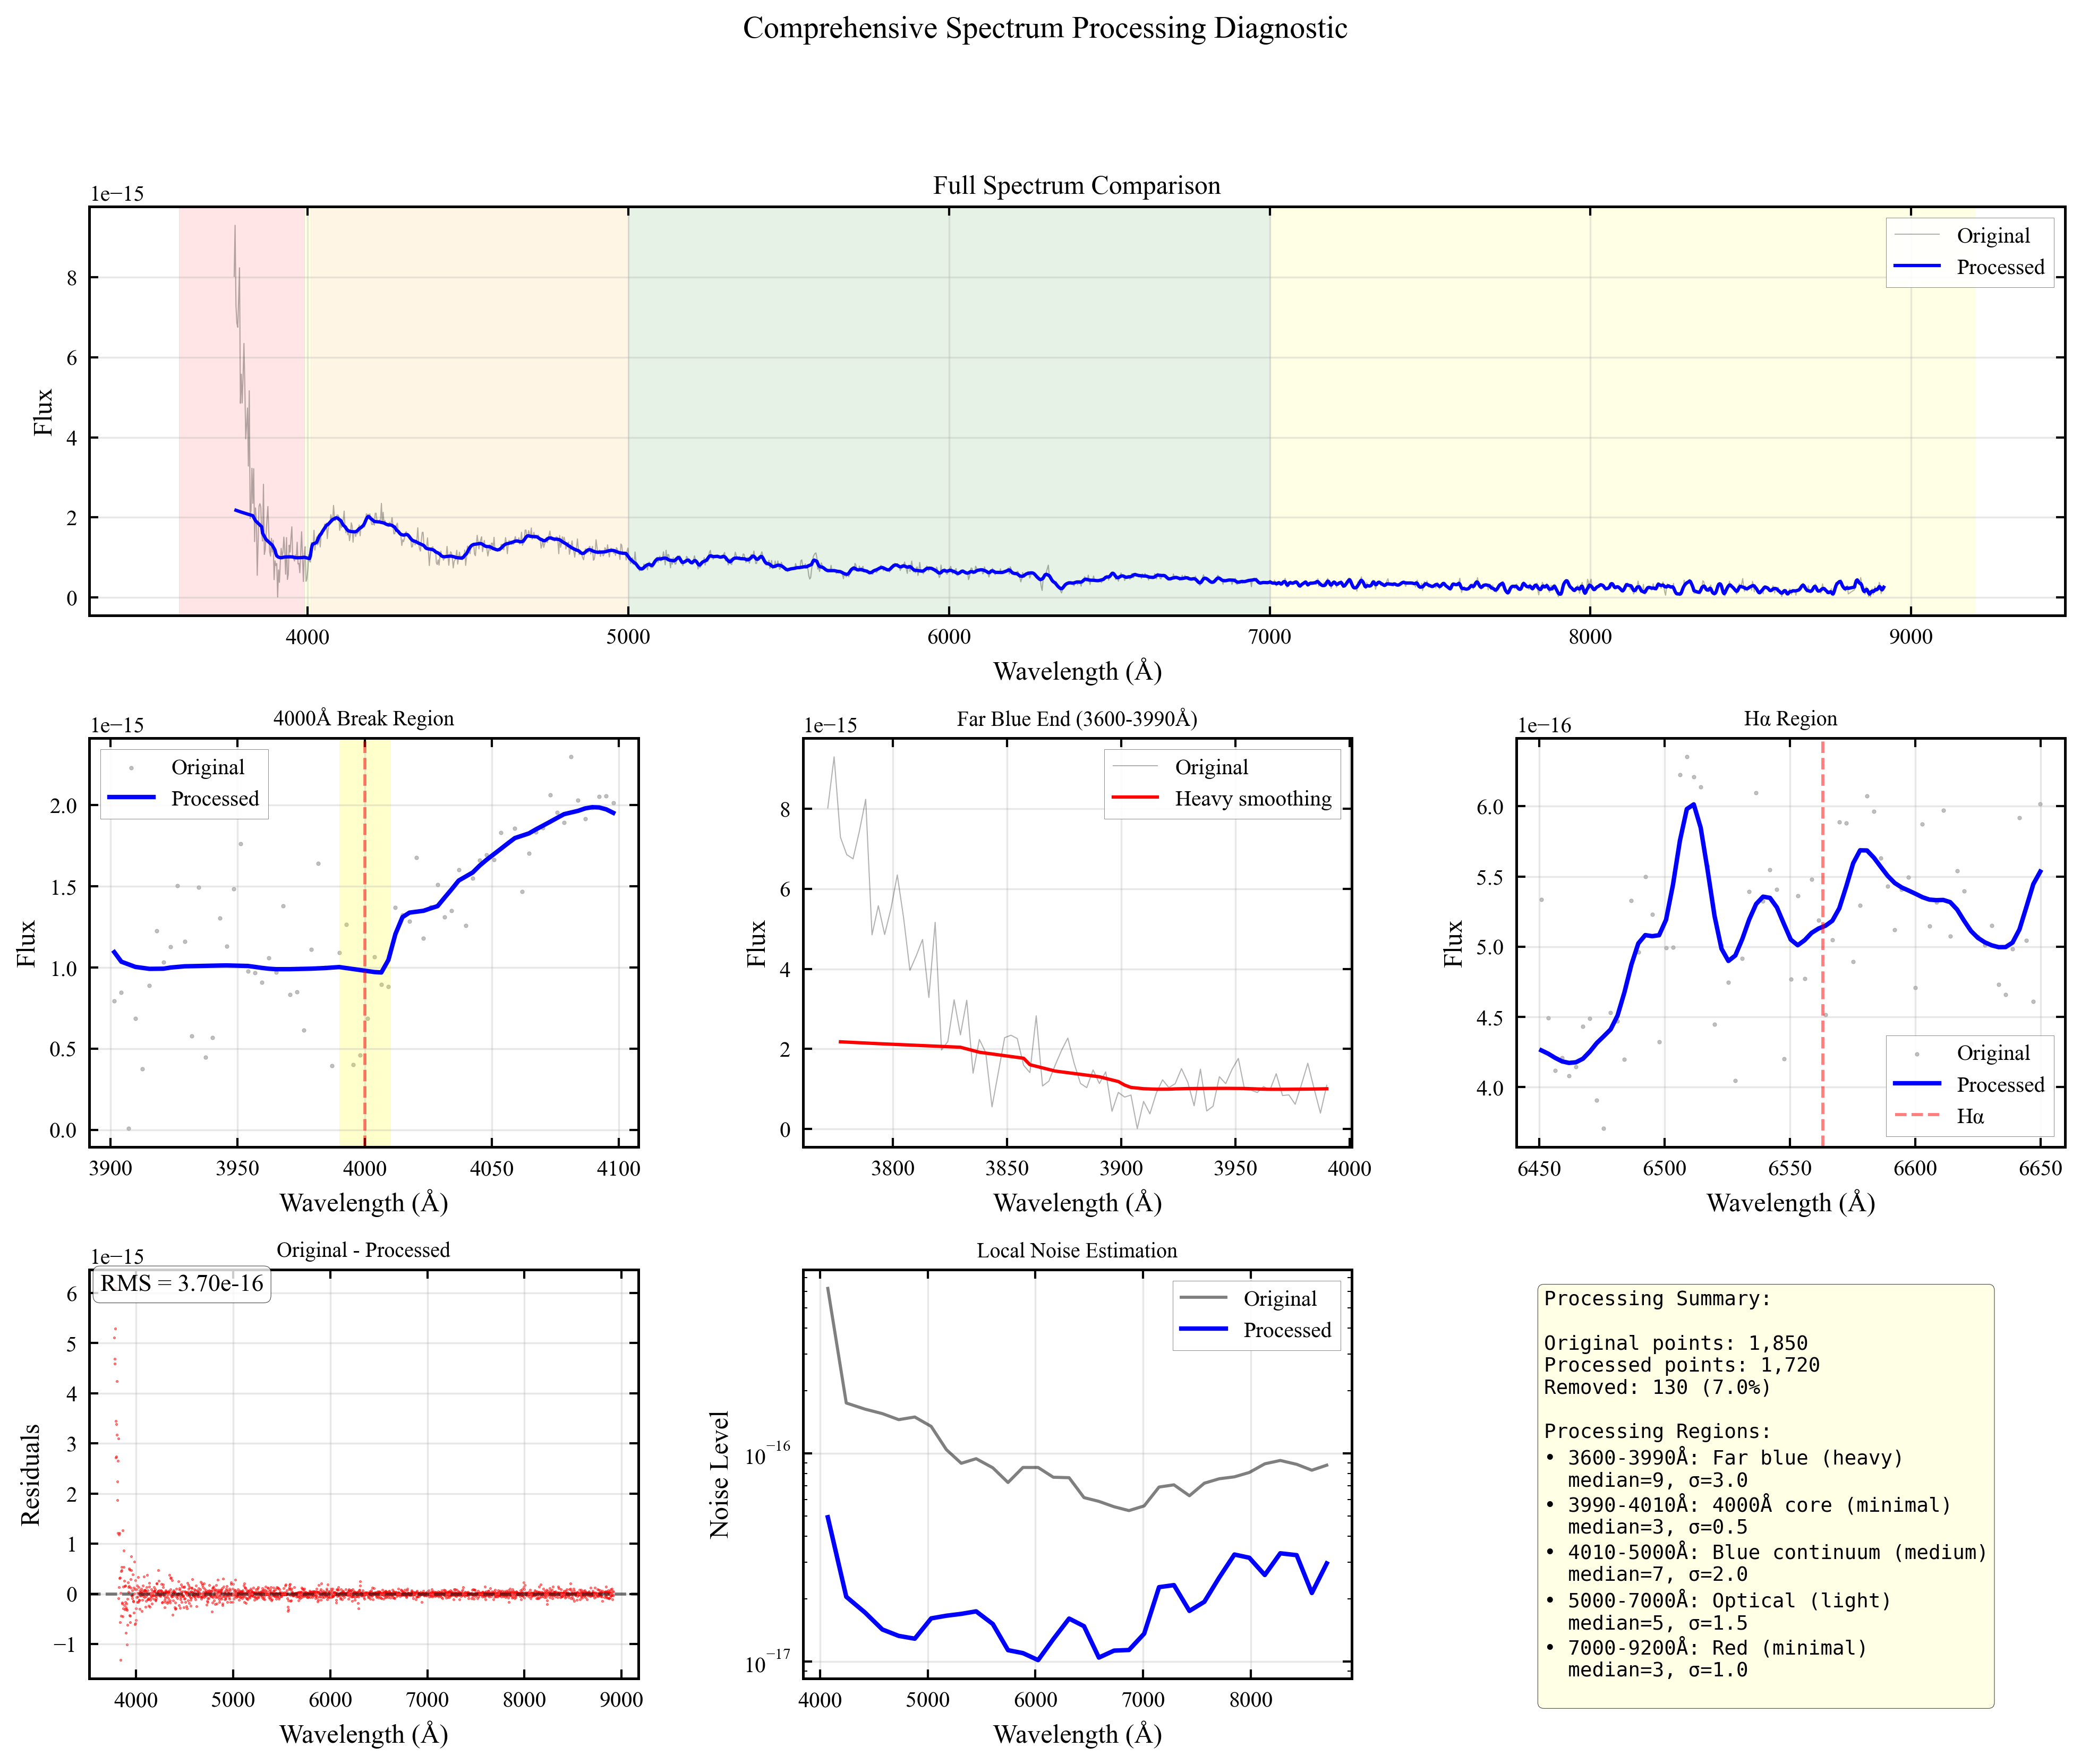

In [160]:
# 基本输入
# wav (wavelength)：波长数组，单位是Å
# flux：流量数组，代表在每个波长处接收到的光的强度
# 这两个数组必须长度相同，每个波长值对应一个流量值，共同构成了光谱数据。

from scipy.interpolate import UnivariateSpline

class BalancedSpectroscopyProcessor:
    """
    平衡的光谱处理器 - 综合版本
    在处理强度和特征保护之间达到最佳平衡
    """
    # 初始化
    def __init__(self, wavelength, flux, verbose=True): 
        self.wav_raw = np.array(wavelength)
        self.flux_raw = np.array(flux) # 原始数据副本（wav_raw, flux_raw）
        self.wav = None # 处理后的波长数据
        self.flux = None # 处理后的流量数据
        self.mask = np.ones(len(wavelength), dtype=bool) # 创建mask数组，用于标记哪些数据点应该保留
        self.verbose = verbose # 是否输出处理日志
        self.processing_log = [] # processing_log记录所有处理步骤
        self.processing_regions = []  # 记录处理区域
        
    def _log(self, message):
        """记录处理步骤"""
        if self.verbose:
            print(message)
        self.processing_log.append(message)
    
    def get_processed_data(self):
        """获取处理后的数据"""
        if self.wav is None:
            self.wav = self.wav_raw[self.mask]
            self.flux = self.flux_raw[self.mask]
        return self.wav, self.flux
    
    def get_statistics(self):
        """获取数据统计信息"""
        if self.wav is None:
            self.get_processed_data() # 确保处理后的数据已生成
            
        # 计算统计信息
        stats = {
            'original_points': len(self.wav_raw),
            'processed_points': len(self.wav),
            'removed_points': len(self.wav_raw) - len(self.wav),
            'removal_rate': (1 - len(self.wav)/len(self.wav_raw)) * 100,
            'wavelength_range': (self.wav.min(), self.wav.max()),
            'flux_range': (self.flux.min(), self.flux.max()),
            'mean_flux': np.mean(self.flux),
            'median_flux': np.median(self.flux),
            'std_flux': np.std(self.flux)
        }
        return stats
    
    def basic_cleaning(self):
        """基础数据清洗"""
        initial_count = np.sum(self.mask) # 记录初始数据点数量
        
        # 去除无效数值：无限值（inf）和非数值（NaN）
        self.mask &= np.isfinite(self.flux_raw) & np.isfinite(self.wav_raw)
        # 去除零值和负值
        self.mask &= (self.flux_raw > 0)

        # 这些值通常是仪器故障或数据传输错误造成的

        removed = initial_count - np.sum(self.mask) # 计算被移除的数据点数
        self._log(f"Basic cleaning: removed {removed} invalid points")
        return self
    
    def wavelength_cut(self, wmin=3600, wmax=9200): 
        """波长范围截取"""
        # 默认范围：3600-9200 Å
        # 3600 Å：紫外-可见光边界，更短波长噪声极大
        # 9200 Å：近红外边界，更长波长进入红外区域

        initial_count = np.sum(self.mask) # 记录初始数据点数量
        self.mask &= (self.wav_raw >= wmin) & (self.wav_raw <= wmax) # 保留指定波长范围内的数据点

        # 这一步确保只处理指定波长范围内的数据，虽然兴隆提供的数据多数都不会超过这个范围
                
        removed = initial_count - np.sum(self.mask) # 计算被移除的数据点数
        self._log(f"Wavelength cut [{wmin}-{wmax}Å]: removed {removed} points")
        return self
    
    def smart_outlier_removal(self, global_threshold=3, local_window=30):
        """
        智能离群点去除 - 结合全局和局部检测
        """
        flux_temp = self.flux_raw[self.mask] # 仅处理掩码内的流量数据
        wav_temp = self.wav_raw[self.mask] # 仅处理掩码内的波长数据
        
        if len(flux_temp) < 10: # 如果数据点太少，直接返回
            return self
        
        # 第一步：全局离群点检测
        flux_median = median_filter(flux_temp, size=11) # 使用中值滤波获得平滑基线
        residuals = flux_temp - flux_median # 计算每个点与基线的偏差
        mad = np.median(np.abs(residuals - np.median(residuals))) # # 计算中位绝对偏差（MAD）
        std_robust = 1.4826 * mad # 将MAD转换为robust标准差估计值
        
        outlier_mask = np.abs(residuals) < global_threshold * std_robust # 去除偏差超过3倍标准差的点
        
        # 第二步：局部离群点检测
        # 宇宙射线、仪器尖峰等会产生离群点，需要去除但不能误删真实的光谱特征
        for i in range(len(flux_temp)):
            if not outlier_mask[i]:  # 已经被标记为离群点
                continue
                
            # 对每个数据点，检查其局部邻域，根据波长调整窗口大小
            if wav_temp[i] < 4500: # 蓝端（<4500 Å）使用较大窗口（噪声更多）
                window = local_window
            else: # 红端使用较小窗口（数据更稳定
                window = local_window // 2
            
            start = max(0, i - window//2)
            end = min(len(flux_temp), i + window//2)
            
            if end - start >= 5:
                local_flux = flux_temp[start:end]
                local_median = np.median(local_flux)
                local_std = np.std(local_flux)
                
                # 局部检测（更严格）
                if local_std > 0 and np.abs(flux_temp[i] - local_median) > 2.5 * local_std: #局部阈值设为2.5倍标准差（更严格）
                    outlier_mask[i] = False
        
        # 应用掩码
        temp_mask = self.mask.copy()
        temp_mask[self.mask] &= outlier_mask
        removed = np.sum(self.mask) - np.sum(temp_mask)
        self.mask = temp_mask
        
        self._log(f"Smart outlier removal: removed {removed} points")
        return self
    
    def adaptive_smoothing(self):
        """
        自适应分区平滑 - 核心处理方法
        """
        if self.wav is None:
            self.wav = self.wav_raw[self.mask]
            self.flux = self.flux_raw[self.mask]
        
        flux_processed = self.flux.copy()
        
        # 分区处理策略：定义处理区域和参数
        self.processing_regions = [
            # (起始波长, 结束波长, 中值窗口, 高斯sigma, 描述)
            (3600, 3990, 9, 3.0, 'Far blue (heavy)'), 
            # 3600-3990 Å（远蓝端），中值窗口：9，σ：3.0，这个区域噪声最大，需要重度平滑
            (3990, 4010, 3, 0.5, '4000Å core (minimal)'), 
            # 3990-4010 Å（4000Å核心），中值窗口：3，σ：0.5，这个区域是4000Å吸收的核心，需要最小平滑以保留特征
            (4010, 5000, 7, 2.0, 'Blue continuum (medium)'),
            # 4010-5000 Å（蓝色连续谱），中值窗口：7，σ：2.0，这个区域是蓝色连续谱，需要中等平滑，平衡噪声和特征
            (5000, 7000, 5, 1.5, 'Optical (light)'),
            # 5000-7000 Å（光学区域），中值窗口：5，σ：1.5，这个区域是光学波段，数据质量较好，需要轻度平滑
            (7000, 9200, 3, 1.0, 'Red (minimal)')
            # 7000-9200 Å（红色区域），中值窗口：3，σ：1.0，这个区域是红色波段，信噪比高，最小化处理
        ]
        
        # 分区处理
        for start, end, med_window, gauss_sigma, description in self.processing_regions:
            mask = (self.wav >= start) & (self.wav < end)
            
            if not np.any(mask):
                continue
            
            # 先进行中值滤波去除尖峰
            flux_processed[mask] = median_filter(flux_processed[mask], size=med_window)
            
            # 再进行高斯平滑
            flux_processed[mask] = gaussian_filter1d(flux_processed[mask], sigma=gauss_sigma)
            
            self._log(f"Processed {description}: {start}-{end}Å")
        
        # 边界平滑处理
        boundary_width = 20
        boundaries = [3990, 4010, 5000, 7000]
        
        for boundary in boundaries:
            mask = (self.wav > boundary - boundary_width) & \
                   (self.wav < boundary + boundary_width)
            if np.any(mask):
                # 在边界处进行额外的平滑以确保连续性
                flux_processed[mask] = gaussian_filter1d(flux_processed[mask], sigma=1.0)
        
        self.flux = flux_processed
        self._log("Applied adaptive smoothing with boundary blending")
        return self
    
    def feature_enhancement(self, feature_wavelengths):
        """
        特征增强 - 轻微恢复重要吸收特征
        """
        if feature_wavelengths is None:
            feature_wavelengths = [3934, 3968, 4000, 4101, 4340, 4861, 6563]  # 可以自定义常见吸收线
        
        flux_enhanced = self.flux.copy()
        
        for feature_wav in feature_wavelengths:
            # 检查特征是否在范围内
            if feature_wav < self.wav.min() or feature_wav > self.wav.max():
                continue
            
            # 找到最近的索引
            idx = np.argmin(np.abs(self.wav - feature_wav))
            
            # 定义特征窗口（根据特征调整）
            if feature_wav < 4100:  # Ca H&K, 4000Å break
                window = 30
            else:  # 其他线
                window = 20
            
            start_idx = max(0, idx - window//2)
            end_idx = min(len(self.flux), idx + window//2)
            
            if end_idx - start_idx < 5:
                continue
            
            # 计算局部连续谱
            continuum_indices = list(range(start_idx, start_idx + 5)) + \
                               list(range(end_idx - 5, end_idx))
            continuum_level = np.mean(self.flux[continuum_indices])
            
            # 检查是否确实是吸收特征
            if self.flux[idx] < continuum_level * 0.95:  # 至少5%的吸收，流量低于局部连续谱5%以上
                # 轻微增强特征（混合原始和平滑的数据）
                original_feature = self.flux_raw[self.mask][start_idx:end_idx]
                smoothed_feature = self.flux[start_idx:end_idx]
                
                # 使用加权平均，中心权重更高，高斯权重函数
                weights = np.exp(-0.5 * ((np.arange(end_idx - start_idx) - (idx - start_idx))**2 / (window/4)**2))
                weights /= weights.max()
                
                # 混合原始和平滑数据（20%原始，80%平滑），中心位置权重最高，边缘逐渐降低
                flux_enhanced[start_idx:end_idx] = 0.2 * weights * original_feature + \
                                                  (1 - 0.2 * weights) * smoothed_feature
        
        self.flux = flux_enhanced
        self._log(f"Enhanced {len(feature_wavelengths)} spectral features")
        return self
    
    def final_polish(self, sigma=0.5):
        """
        最终抛光 - 轻度全局平滑
        """
        self.flux = gaussian_filter1d(self.flux, sigma=sigma)
        self._log(f"Applied final polish (sigma={sigma})")
        return self

def process_spectrum_balanced(wav, flux, 
                            enhance_features,
                            diagnostic):
    """
    平衡的光谱处理主函数
    
    参数：
    - wav, flux: 输入波长和流量
    - enhance_features: 是否增强吸收特征
    - diagnostic: 是否生成诊断图
    """
    processor = BalancedSpectroscopyProcessor(wav, flux)
    
    # 处理流程
    processor.basic_cleaning()\
             .wavelength_cut(3600, 9200)\
             .smart_outlier_removal(global_threshold=3, local_window=30)
    
    # 获取清洗后的数据
    processor.wav = processor.wav_raw[processor.mask]
    processor.flux = processor.flux_raw[processor.mask]
    
    # 自适应平滑
    processor.adaptive_smoothing()
    
    # 特征增强（可选）
    if enhance_features:
        processor.feature_enhancement()
    
    # 最终抛光
    processor.final_polish(sigma=0.3)
    
    # 获取结果
    wav_clean, flux_clean = processor.get_processed_data()
    
    if diagnostic:
        fig = plot_comprehensive_diagnostic(wav, flux, wav_clean, flux_clean, processor)
    
    return wav_clean, flux_clean, processor

def plot_comprehensive_diagnostic(wav_raw, flux_raw, wav_clean, flux_clean, processor):
    """综合诊断图"""
    fig = plt.figure(figsize=(16, 12))
    
    # 布局设计
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. 全光谱对比（大图）
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(wav_raw, flux_raw, 'k-', alpha=0.3, linewidth=0.5, label='Original')
    ax1.plot(wav_clean, flux_clean, 'b-', linewidth=1.5, label='Processed')
    ax1.set_xlabel('Wavelength (Å)')
    ax1.set_ylabel('Flux')
    ax1.set_title('Full Spectrum Comparison', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 标记处理区域
    y_bottom, y_top = ax1.get_ylim()
    for start, end, _, _, desc in processor.processing_regions:
        if 'heavy' in desc:
            color = 'red'
            alpha = 0.1
        elif 'minimal' in desc:
            color = 'yellow'
            alpha = 0.1
        elif 'medium' in desc:
            color = 'orange'
            alpha = 0.1
        else:
            color = 'green'
            alpha = 0.1
        ax1.axvspan(start, end, alpha=alpha, color=color)
    
    # 2. 4000Å区域详细视图
    ax2 = fig.add_subplot(gs[1, 0])
    mask_raw = (wav_raw > 3900) & (wav_raw < 4100)
    mask_clean = (wav_clean > 3900) & (wav_clean < 4100)
    
    if np.any(mask_raw):
        ax2.scatter(wav_raw[mask_raw], flux_raw[mask_raw], 
                   s=3, alpha=0.5, c='gray', label='Original')
    if np.any(mask_clean):
        ax2.plot(wav_clean[mask_clean], flux_clean[mask_clean], 
                'b-', linewidth=2, label='Processed')
    
    ax2.axvspan(3990, 4010, alpha=0.2, color='yellow')
    ax2.axvline(4000, color='red', linestyle='--', alpha=0.5)
    ax2.set_title('4000Å Break Region')
    ax2.set_xlabel('Wavelength (Å)')
    ax2.set_ylabel('Flux')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. 短波段噪声区，显示噪声最大的区域如何被有效平滑
    ax3 = fig.add_subplot(gs[1, 1])
    mask_raw = (wav_raw > 3600) & (wav_raw < 3990)
    mask_clean = (wav_clean > 3600) & (wav_clean < 3990)
    
    if np.any(mask_raw):
        ax3.plot(wav_raw[mask_raw], flux_raw[mask_raw], 
                'k-', alpha=0.3, linewidth=0.5, label='Original')
    if np.any(mask_clean):
        ax3.plot(wav_clean[mask_clean], flux_clean[mask_clean], 
                'r-', linewidth=1.5, label='Heavy smoothing')
    
    ax3.set_title('Far Blue End (3600-3990Å)')
    ax3.set_xlabel('Wavelength (Å)')
    ax3.set_ylabel('Flux')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Hα区域，展示6563 Å附近的处理效果
    ax4 = fig.add_subplot(gs[1, 2])
    mask_raw = (wav_raw > 6450) & (wav_raw < 6650)
    mask_clean = (wav_clean > 6450) & (wav_clean < 6650)
    
    if np.any(mask_raw) and np.any(mask_clean):
        ax4.scatter(wav_raw[mask_raw], flux_raw[mask_raw], 
                   s=3, alpha=0.5, c='gray', label='Original')
        ax4.plot(wav_clean[mask_clean], flux_clean[mask_clean], 
                'b-', linewidth=2, label='Processed')
        ax4.axvline(6563, color='red', linestyle='--', alpha=0.5, label='Hα')
    else:
        ax4.text(0.5, 0.5, 'Hα region\nnot available', 
                ha='center', va='center', transform=ax4.transAxes)
    
    ax4.set_title('Hα Region')
    ax4.set_xlabel('Wavelength (Å)')
    ax4.set_ylabel('Flux')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. 残差分析，显示原始数据减去处理数据的差值，理想情况下应该只包含随机噪声
    ax5 = fig.add_subplot(gs[2, 0])
    # 插值到原始网格
    f_interp = interpolate.interp1d(wav_clean, flux_clean, 
                                   bounds_error=False, fill_value=np.nan)
    flux_interp = f_interp(wav_raw)
    residuals = flux_raw - flux_interp
    valid = np.isfinite(residuals)
    
    ax5.scatter(wav_raw[valid], residuals[valid], s=1, alpha=0.5, c='red')
    ax5.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    ax5.set_xlabel('Wavelength (Å)')
    ax5.set_ylabel('Residuals')
    ax5.set_title('Original - Processed')
    ax5.grid(True, alpha=0.3)
    
    # 计算RMS
    rms = np.sqrt(np.mean(residuals[valid]**2))
    ax5.text(0.02, 0.95, f'RMS = {rms:.2e}', transform=ax5.transAxes,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 6. 噪声水平比较，通过差分方法估计局部噪声，展示噪声降低效果
    ax6 = fig.add_subplot(gs[2, 1])
    
    # 计算局部噪声（使用差分方法）
    window = 100
    wav_centers = []
    noise_orig = []
    noise_proc = []
    
    for i in range(0, len(wav_clean) - window, window//2):
        wav_center = wav_clean[i + window//2]
        wav_centers.append(wav_center)
        
        # 原始数据噪声
        mask_orig = (wav_raw >= wav_clean[i]) & (wav_raw < wav_clean[i + window])
        if np.sum(mask_orig) > 10:
            noise_orig.append(np.std(np.diff(flux_raw[mask_orig])))
        else:
            noise_orig.append(np.nan)
        
        # 处理后噪声
        noise_proc.append(np.std(np.diff(flux_clean[i:i+window])))
    
    ax6.plot(wav_centers, noise_orig, 'k-', alpha=0.5, label='Original')
    ax6.plot(wav_centers, noise_proc, 'b-', linewidth=2, label='Processed')
    ax6.set_xlabel('Wavelength (Å)')
    ax6.set_ylabel('Noise Level')
    ax6.set_title('Local Noise Estimation')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    ax6.set_yscale('log')
    
    # 7. 处理统计：数据点数量变化、去除率、处理区域等
    ax7 = fig.add_subplot(gs[2, 2])
    ax7.axis('off')
    
    stats = processor.get_statistics()
    stats_text = "Processing Summary:\n\n"
    stats_text += f"Original points: {stats['original_points']:,}\n"
    stats_text += f"Processed points: {stats['processed_points']:,}\n"
    stats_text += f"Removed: {stats['removed_points']} ({stats['removal_rate']:.1f}%)\n\n"
    
    stats_text += "Processing Regions:\n"
    for start, end, med, gauss, desc in processor.processing_regions:
        stats_text += f"• {start}-{end}Å: {desc}\n"
        stats_text += f"  median={med}, σ={gauss}\n"
    
    ax7.text(0.05, 0.95, stats_text, transform=ax7.transAxes,
            fontsize=9, verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    plt.suptitle('Comprehensive Spectrum Processing Diagnostic', fontsize=14)
    
    return fig

# wav_clean：处理后的波长数组
# flux_clean：处理后的流量数组
# processor：包含所有处理信息的对象
wav_clean, flux_clean, processor = process_spectrum_balanced(
    wav1, flux1,
    enhance_features=False,  # 是否轻微增强吸收特征
    diagnostic=True
)

# 如果需要更强或更弱的处理，可以调整参数
# 例如，更保守的处理：
# processor = BalancedSpectroscopyProcessor(wav1, flux1)
# processor.basic_cleaning().wavelength_cut(3600, 9200)
# processor.smart_outlier_removal(global_threshold=4, local_window=50)  # 更宽松
# processor.wav = processor.wav_raw[processor.mask]
# processor.flux = processor.flux_raw[processor.mask]
# processor.adaptive_smoothing()
# processor.final_polish(sigma=0.2)  # 更轻的最终平滑
# wav_clean, flux_clean = processor.get_processed_data()

## Data Visualization

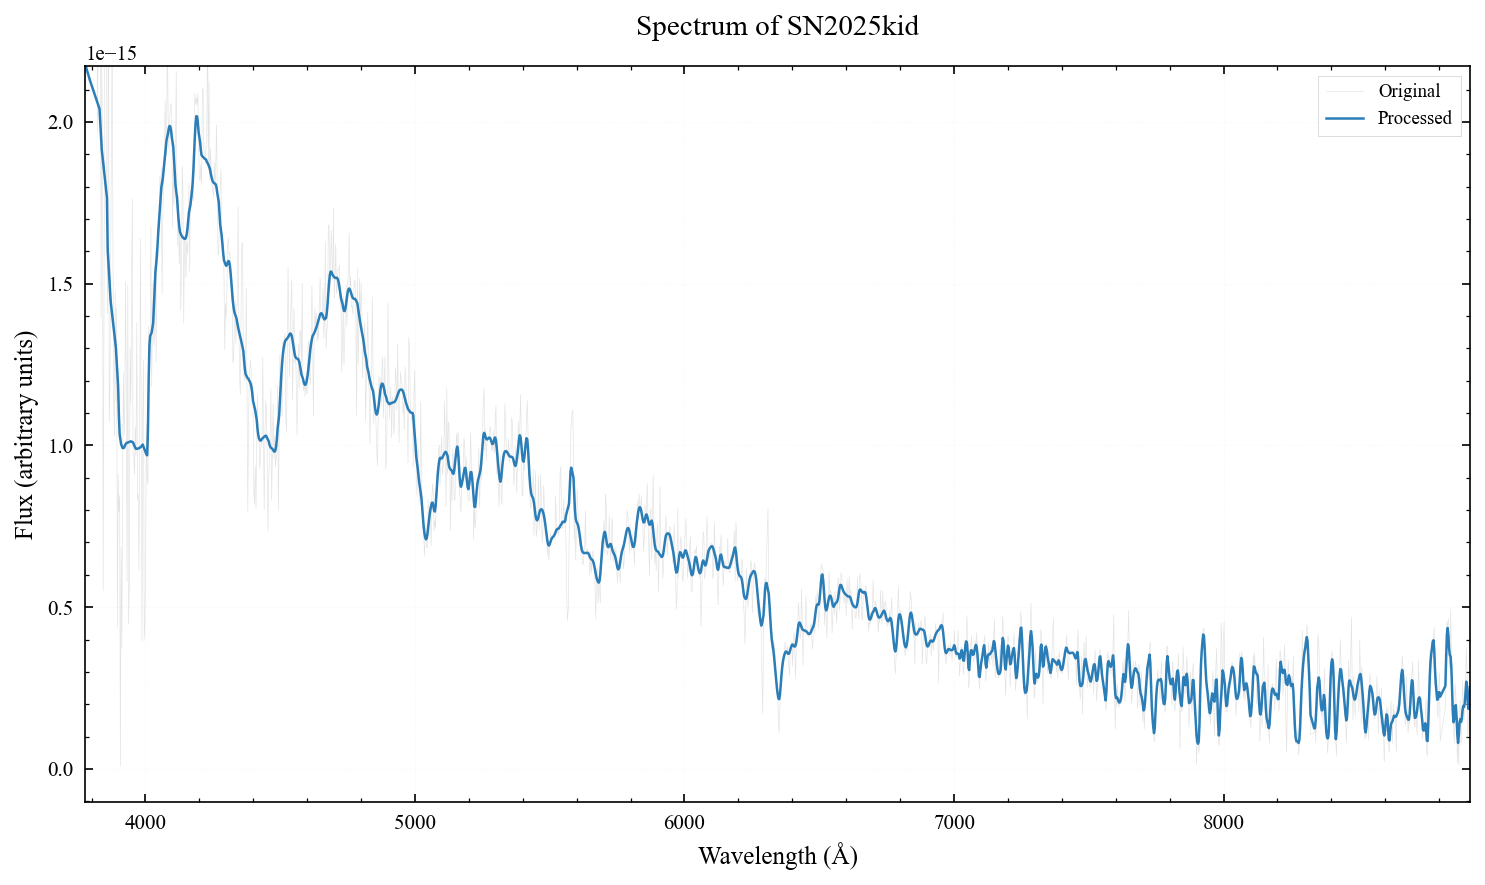

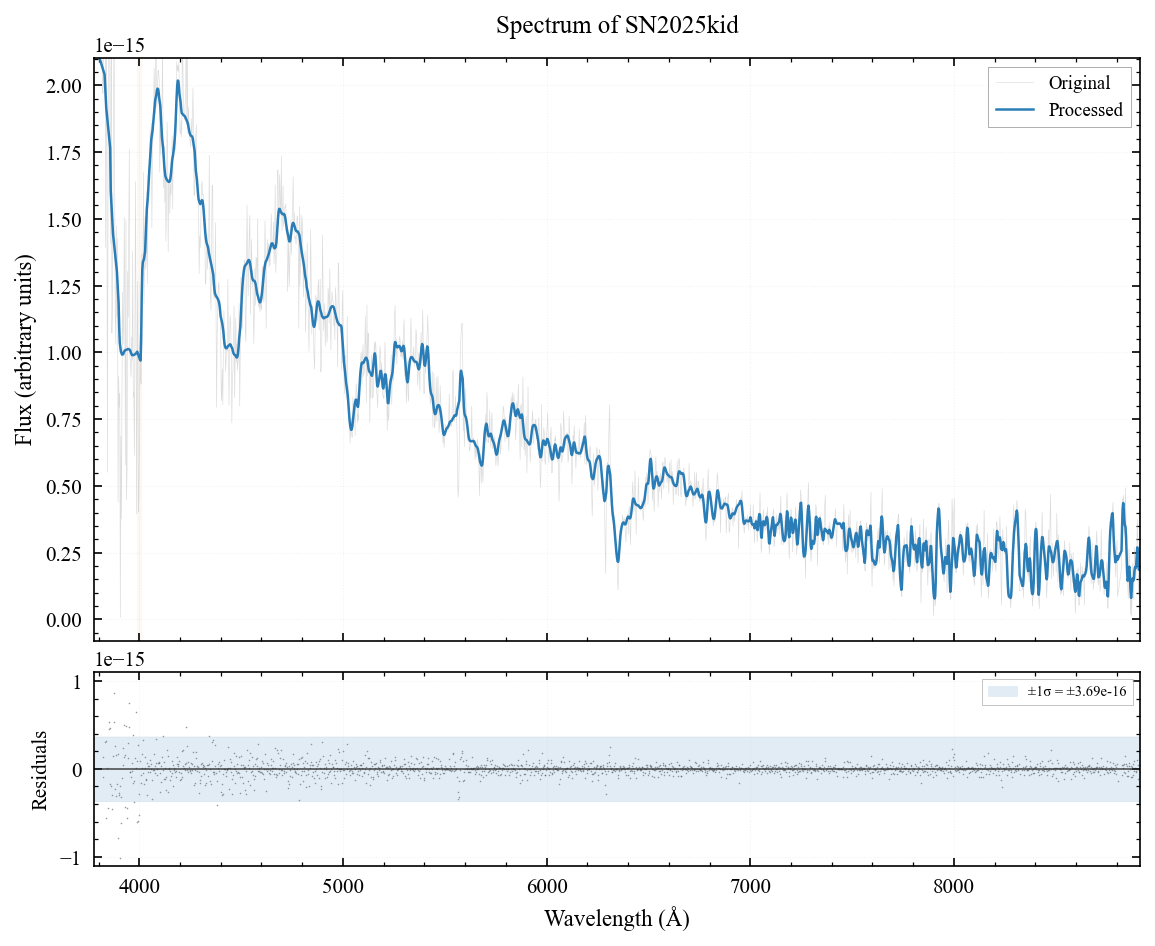

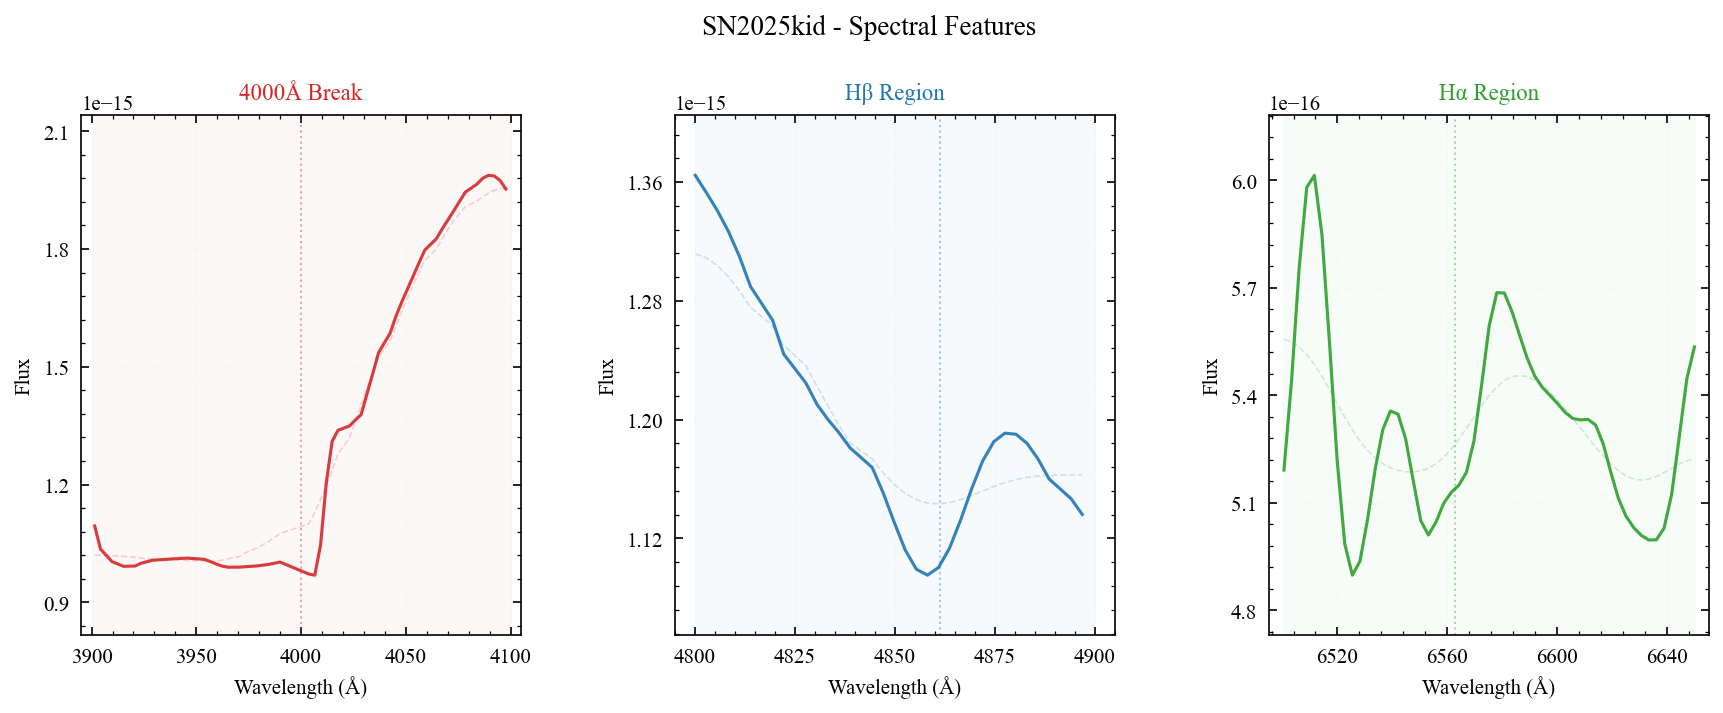

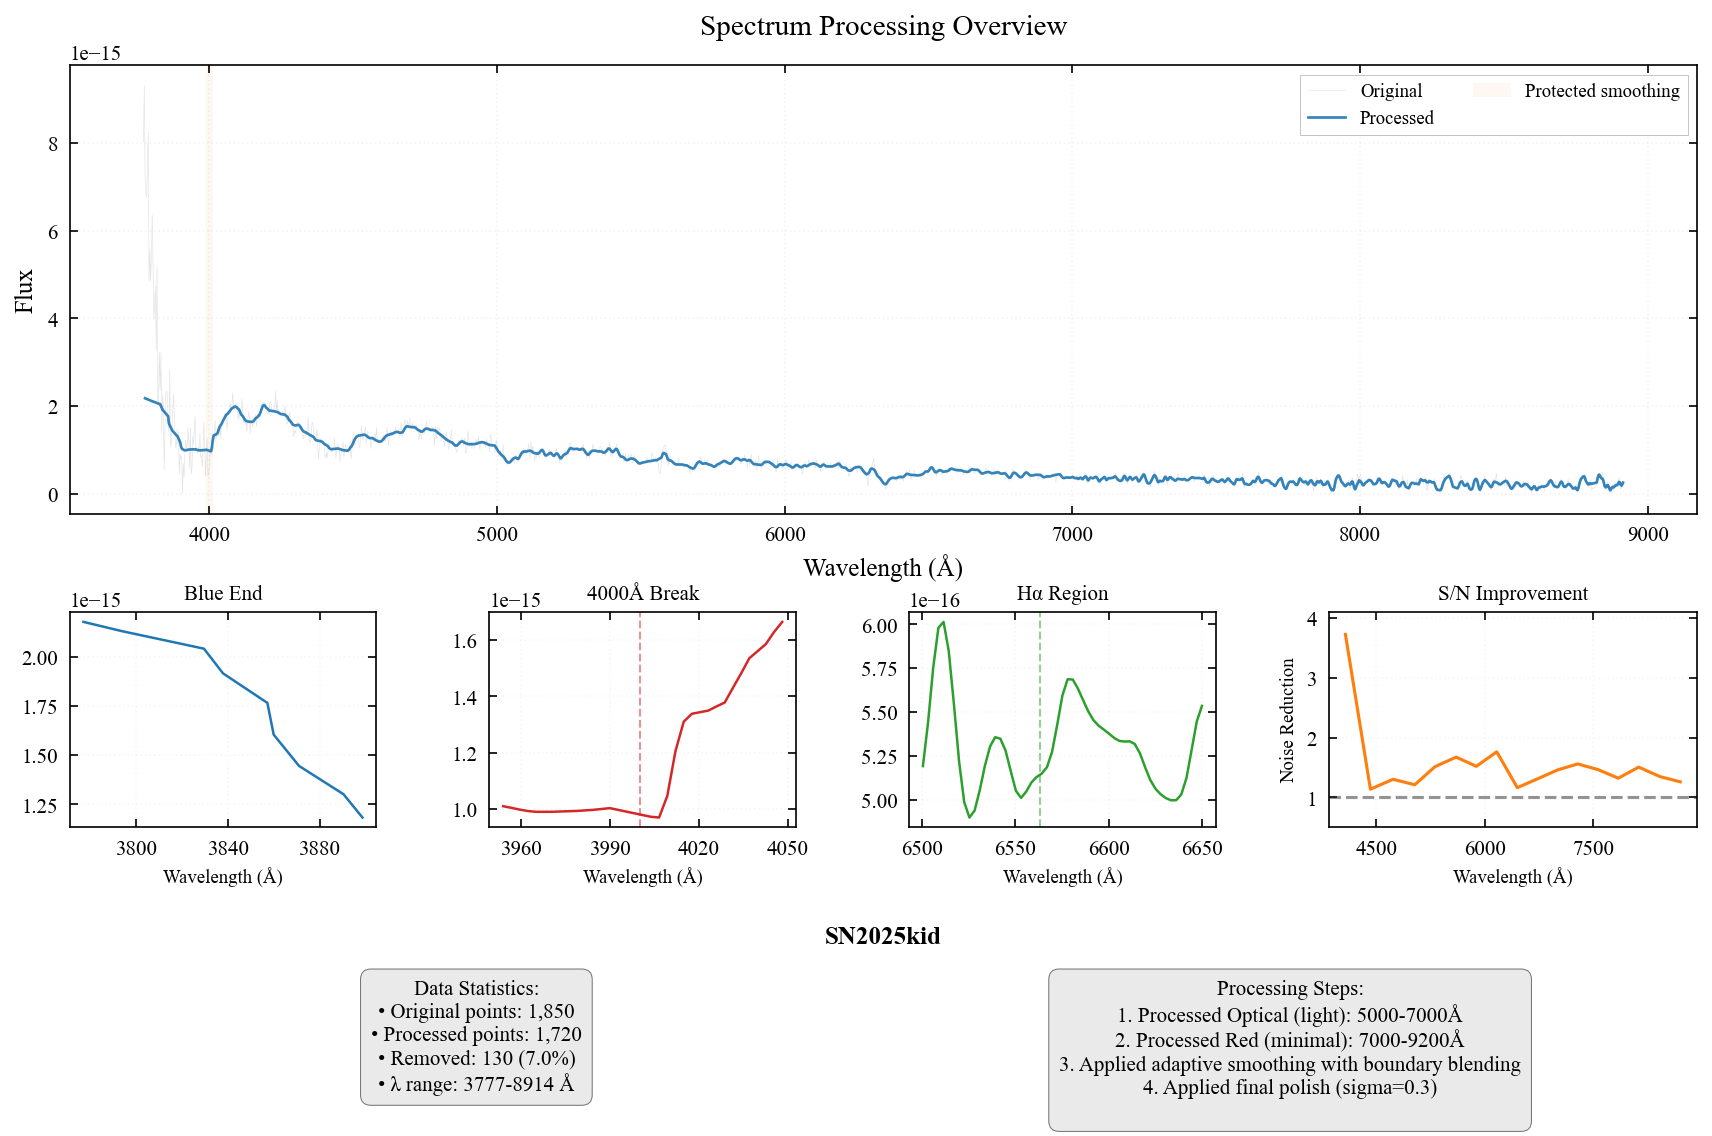

In [161]:
from matplotlib import rcParams
import matplotlib.ticker as ticker
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec

# 设置科学出版物风格
def setup_publication_style():
    """设置适合科学出版物的绘图风格"""
    # 使用经典的科学绘图风格
    plt.style.use(['seaborn-v0_8-paper', 'seaborn-v0_8-deep'])
    
    # 字体设置
    rcParams['font.family'] = 'serif'
    rcParams['font.serif'] = ['Times New Roman', 'DejaVu Serif']
    rcParams['font.size'] = 10
    rcParams['axes.labelsize'] = 11
    rcParams['axes.titlesize'] = 12
    rcParams['xtick.labelsize'] = 10
    rcParams['ytick.labelsize'] = 10
    rcParams['legend.fontsize'] = 9
    
    # 图形质量
    rcParams['figure.dpi'] = 150
    rcParams['savefig.dpi'] = 300
    rcParams['savefig.format'] = 'pdf'
    
    # 线条和标记
    rcParams['lines.linewidth'] = 1.5
    rcParams['lines.markersize'] = 4
    rcParams['axes.linewidth'] = 0.8
    
    # 刻度
    rcParams['xtick.major.size'] = 4
    rcParams['ytick.major.size'] = 4
    rcParams['xtick.minor.size'] = 2
    rcParams['ytick.minor.size'] = 2
    rcParams['xtick.major.width'] = 0.8
    rcParams['ytick.major.width'] = 0.8
    rcParams['xtick.minor.width'] = 0.6
    rcParams['ytick.minor.width'] = 0.6
    rcParams['xtick.direction'] = 'in'
    rcParams['ytick.direction'] = 'in'
    rcParams['xtick.top'] = True
    rcParams['ytick.right'] = True
    
    # 图例
    rcParams['legend.frameon'] = True
    rcParams['legend.framealpha'] = 0.9
    rcParams['legend.fancybox'] = False
    rcParams['legend.edgecolor'] = 'gray'

# 优雅的配色方案
class ColorScheme:
    """科学图表的优雅配色方案"""
    # 主色调
    primary_blue = '#1f77b4'
    primary_red = '#d62728'
    primary_green = '#2ca02c'
    primary_orange = '#ff7f0e'
    
    # 柔和色调
    soft_blue = '#4c8cbf'
    soft_red = '#e67c73'
    soft_green = '#5cb85c'
    soft_yellow = '#f0ad4e'
    
    # 灰度
    dark_gray = '#2b2b2b'
    medium_gray = '#595959'
    light_gray = '#b8b8b8'
    very_light_gray = '#e5e5e5'
    
    # 透明度
    alpha_fill = 0.2
    alpha_line = 0.8
    alpha_scatter = 0.6

def plot_elegant_spectrum_simple(wav_raw, flux_raw, wav_clean, flux_clean, 
                               processor=None, object_name="", save_path=None):
    """
    简洁优雅的光谱图 - 无残差版本，适合展示和演讲
    """
    setup_publication_style()
    colors = ColorScheme()
    
    # 单panel设计
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    # 原始数据（淡化显示）
    ax.plot(wav_raw, flux_raw, color=colors.light_gray, 
            linewidth=0.3, alpha=0.4, label='Original', rasterized=True)
    
    # 处理后数据
    ax.plot(wav_clean, flux_clean, color=colors.primary_blue, 
            linewidth=1.2, label='Processed', alpha=0.95)
    
    # 标记重要光谱特征
    spectral_features = {
        #'Ca K': (3933.7, colors.soft_red),
        #'Ca H': (3968.5, colors.soft_red),
        #'4000Å': (4000, colors.primary_red),
        #'Hδ': (4101.7, colors.soft_blue),
        #'Hβ': (4861.3, colors.soft_blue),
        #'Hα': (6562.8, colors.soft_blue)
    }
    
    # 优化的特征标记
    y_range = np.percentile(flux_clean, 95) - np.percentile(flux_clean, 5)
    y_top = np.percentile(flux_clean, 96)
    
    # 智能标签放置 - 避免重叠
    marked_positions = []
    
    for name, (wavelength, color) in spectral_features.items():
        if wav_clean.min() <= wavelength <= wav_clean.max():
            # 特征线
            ax.axvline(wavelength, color=color, linestyle=':', 
                      alpha=0.3, linewidth=0.8, zorder=1)
            
            # 计算标签位置，避免重叠
            label_y = y_top + 0.08*y_range
            for pos in marked_positions:
                if abs(wavelength - pos[0]) < 150:  # 150Å内认为会重叠
                    label_y = max(label_y, pos[1] + 0.04*y_range)
            
            marked_positions.append((wavelength, label_y))
            
            # 标签 - 直接文本，不用箭头
            ax.text(wavelength, label_y, name, 
                   ha='center', va='bottom', fontsize=7,
                   color=color, rotation=0)
    
    # 处理区域的优雅标记（可选）
    if processor and hasattr(processor, 'processing_regions'):
        for start, end, _, _, desc in processor.processing_regions:
            if '4000Å' in desc:
                ax.axvspan(start, end, alpha=0.06, color=colors.soft_yellow,
                          zorder=0)
    
    # 可选：在角落添加处理质量指标
    if processor:
        stats = processor.get_statistics()
        quality_text = f"Data quality:\nPoints removed: {stats['removal_rate']:.1f}%\nλ range: {stats['wavelength_range'][0]:.0f}-{stats['wavelength_range'][1]:.0f} Å"
        ax.text(0.02, 0.98, quality_text, transform=ax.transAxes,
               fontsize=7, va='top', color=colors.medium_gray,
               bbox=dict(boxstyle='round,pad=0.3', 
                       facecolor='white', alpha=0.8, 
                       edgecolor=colors.light_gray))
    
    # 样式设置
    ax.set_xlabel('Wavelength (Å)', fontsize=12)
    ax.set_ylabel('Flux (arbitrary units)', fontsize=12)
    ax.set_xlim(wav_clean.min(), wav_clean.max())
    
    # 动态y轴
    y_lower = np.percentile(flux_clean, 0.5)
    y_upper = np.percentile(flux_clean, 99.5)
    y_margin = (y_upper - y_lower) * 0.1
    ax.set_ylim(y_lower - y_margin, y_upper + y_margin)
    
    # 网格
    ax.grid(True, alpha=0.1, linestyle=':', linewidth=0.5)
    
    # 图例
    ax.legend(loc='upper right', frameon=True, 
             framealpha=0.95, edgecolor=colors.light_gray)
    
    # 标题
    if object_name:
        ax.set_title(f'Spectrum of {object_name}', fontsize=14, pad=15)
    
    # 次要刻度
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    
    plt.tight_layout()
    
    if save_path:
        if save_path.endswith('.pdf'):
            save_path_simple = save_path.replace('.pdf', '_simple.pdf')
        else:
            save_path_simple = save_path + '_simple'
        plt.savefig(save_path_simple, dpi=300, bbox_inches='tight',
                   facecolor='white', edgecolor='none')
    
    plt.show()
    return fig

def plot_elegant_spectrum_with_residuals(wav_raw, flux_raw, wav_clean, flux_clean, 
                                        processor=None, object_name="", save_path=None):
    """
    带残差图的科学版本 - 用于方法验证和质量控制
    原来的plot_elegant_spectrum函数内容
    """
    setup_publication_style()
    colors = ColorScheme()
    
    # 创建图形 - 稍微增加高度以避免拥挤
    fig, (ax_main, ax_residual) = plt.subplots(2, 1, figsize=(9, 7), 
                                               gridspec_kw={'height_ratios': [3, 1], 
                                                          'hspace': 0.08})
    
    # === 主图 ===
    # 原始数据（淡化显示）
    ax_main.plot(wav_raw, flux_raw, color=colors.light_gray, 
                linewidth=0.3, alpha=0.5, label='Original', rasterized=True)
    
    # 处理后数据（调整线宽，更细腻）
    ax_main.plot(wav_clean, flux_clean, color=colors.primary_blue, 
                linewidth=1.2, label='Processed', alpha=0.95)
    
    # 标记重要光谱特征 - 简化标记，避免拥挤
    spectral_features = {
        #'Ca K': (3933.7, colors.soft_red),
        #'Ca H': (3968.5, colors.soft_red),
        #'4000Å': (4000, colors.primary_red),
        #'Hδ': (4101.7, colors.soft_blue),
        #'Hβ': (4861.3, colors.soft_blue),
        #'Hα': (6562.8, colors.soft_blue)
    }
    
    # 添加特征标记 - 优化标签位置
    y_range = np.percentile(flux_clean, 95) - np.percentile(flux_clean, 5)
    y_top = np.percentile(flux_clean, 96)
    
    # 交替标签高度避免重叠
    label_heights = [0.08, 0.12, 0.08, 0.12, 0.08, 0.12]
    
    for i, (name, (wavelength, color)) in enumerate(spectral_features.items()):
        if wav_clean.min() <= wavelength <= wav_clean.max():
            ax_main.axvline(wavelength, color=color, linestyle=':', 
                          alpha=0.4, linewidth=0.8, zorder=1)
            
            # 优雅的标签
            ax_main.annotate(name, xy=(wavelength, y_top), 
                           xytext=(wavelength, y_top + label_heights[i % 6]*y_range),
                           ha='center', va='bottom', fontsize=7,
                           color=color, weight='normal',
                           arrowprops=dict(arrowstyle='-', color=color, 
                                         lw=0.4, alpha=0.4))
    
    # 处理区域的优雅标记
    if processor and hasattr(processor, 'processing_regions'):
        for start, end, _, _, desc in processor.processing_regions:
            if '4000Å' in desc:
                ax_main.axvspan(start, end, alpha=0.08, color=colors.soft_yellow,
                              zorder=0)
    
    # 设置主图样式
    ax_main.set_ylabel('Flux (arbitrary units)', fontsize=11)
    ax_main.set_xlim(wav_clean.min(), wav_clean.max())
    
    # 动态设置y轴范围
    y_lower = np.percentile(flux_clean, 1)
    y_upper = np.percentile(flux_clean, 99)
    y_margin = (y_upper - y_lower) * 0.1
    ax_main.set_ylim(y_lower - y_margin, y_upper + y_margin)
    
    # 添加网格
    ax_main.grid(True, alpha=0.15, linestyle=':', linewidth=0.5)
    
    # 图例
    ax_main.legend(loc='upper right', frameon=True, fancybox=False,
                  edgecolor=colors.medium_gray, framealpha=0.95)
    
    # 标题
    if object_name:
        ax_main.set_title(f'Spectrum of {object_name}', fontsize=12, pad=12)
    
    # 隐藏x轴标签（因为有残差图）
    ax_main.set_xticklabels([])
    
    # 添加次要刻度
    ax_main.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    ax_main.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    
    # === 残差图 ===
    # 计算残差
    from scipy.interpolate import interp1d
    f_interp = interp1d(wav_clean, flux_clean, bounds_error=False, 
                       fill_value=np.nan, kind='linear')
    flux_interp = f_interp(wav_raw)
    residuals = flux_raw - flux_interp
    valid = np.isfinite(residuals)
    
    # 残差散点图
    ax_residual.scatter(wav_raw[valid], residuals[valid], 
                       s=0.3, alpha=colors.alpha_scatter * 0.8, 
                       color=colors.medium_gray, rasterized=True)
    
    # 零线
    ax_residual.axhline(y=0, color=colors.dark_gray, linestyle='-', 
                       linewidth=0.8, alpha=0.8)
    
    # 残差统计
    rms = np.sqrt(np.mean(residuals[valid]**2))
    std = np.std(residuals[valid])
    
    # 添加±1σ区域
    ax_residual.fill_between(wav_clean, -std, std, 
                           alpha=colors.alpha_fill * 0.8, 
                           color=colors.soft_blue, 
                           label=f'±1σ = ±{std:.2e}')
    
    # 设置残差图样式
    ax_residual.set_xlabel('Wavelength (Å)', fontsize=11)
    ax_residual.set_ylabel('Residuals', fontsize=10)
    ax_residual.set_xlim(ax_main.get_xlim())
    ax_residual.set_ylim(-3*std, 3*std)
    
    # 网格
    ax_residual.grid(True, alpha=0.15, linestyle=':', linewidth=0.5)
    
    # 残差图图例
    ax_residual.legend(loc='upper right', fontsize=7)
    
    # 添加次要刻度
    ax_residual.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    ax_residual.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', 
                   facecolor='white', edgecolor='none')
    
    plt.show()
    return fig

def plot_elegant_spectrum(wav_raw, flux_raw, wav_clean, flux_clean, 
                         processor=None, object_name="", save_path=None,
                         show_residuals=False):
    """
    灵活的优雅光谱图 - 可选是否显示残差
    
    Parameters:
    -----------
    wav_raw, flux_raw : array-like
        原始波长和流量数据
    wav_clean, flux_clean : array-like
        处理后的波长和流量数据
    processor : object, optional
        处理器对象，包含处理信息
    object_name : str, optional
        天体名称
    save_path : str, optional
        保存路径
    show_residuals : bool, default=False
        是否显示残差图
        True: 显示残差图（科学分析）
        False: 仅显示光谱（优雅展示）
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        生成的图形对象
    """
    if show_residuals:
        # 调用带残差版本
        return plot_elegant_spectrum_with_residuals(
            wav_raw, flux_raw, wav_clean, flux_clean,
            processor, object_name, save_path
        )
    else:
        # 调用简化版本
        return plot_elegant_spectrum_simple(
            wav_raw, flux_raw, wav_clean, flux_clean,
            processor, object_name, save_path
        )

# 保持其他函数不变
def plot_feature_focus(wav_clean, flux_clean, 
                      feature_regions=None,
                      object_name="", save_path=None):
    """
    聚焦关键光谱特征的优美展示 - 改进布局避免拥挤
    """
    setup_publication_style()
    colors = ColorScheme()
    
    if feature_regions is None:
        feature_regions = [
            (3900, 4100, '4000Å Break', colors.primary_red),
            (4800, 4900, 'Hβ Region', colors.primary_blue),
            (6500, 6650, 'Hα Region', colors.primary_green)
        ]
    
    n_features = len(feature_regions)
    # 增加图的尺寸和间距
    fig = plt.figure(figsize=(14, 4.5))
    
    # 使用GridSpec以获得更好的控制
    gs = gridspec.GridSpec(1, n_features, figure=fig, wspace=0.35)
    axes = [fig.add_subplot(gs[0, i]) for i in range(n_features)]
    
    for ax, (wmin, wmax, title, color) in zip(axes, feature_regions):
        # 选择数据
        mask = (wav_clean >= wmin) & (wav_clean <= wmax)
        
        if np.any(mask):
            wav_region = wav_clean[mask]
            flux_region = flux_clean[mask]
            
            # 背景渐变 - 更淡
            ax.axvspan(wmin, wmax, alpha=0.03, color=color)
            
            # 主线
            ax.plot(wav_region, flux_region, color=color, 
                   linewidth=1.5, alpha=0.9)
            
            # 平滑的包络线 - 更淡
            from scipy.ndimage import gaussian_filter1d
            flux_smooth = gaussian_filter1d(flux_region, sigma=5)
            ax.plot(wav_region, flux_smooth, color=color, 
                   linewidth=0.8, alpha=0.2, linestyle='--')
            
            # 特定特征的垂直线
            if '4000Å' in title:
                ax.axvline(4000, color=color, linestyle=':', alpha=0.4, linewidth=1)
            elif 'Hβ' in title:
                ax.axvline(4861.3, color=color, linestyle=':', alpha=0.4, linewidth=1)
            elif 'Hα' in title:
                ax.axvline(6562.8, color=color, linestyle=':', alpha=0.4, linewidth=1)
            
            # 标题和标签
            ax.set_title(title, fontsize=11, color=color, pad=8, weight='normal')
            ax.set_xlabel('Wavelength (Å)', fontsize=10)
            ax.set_ylabel('Flux', fontsize=10)
            
            # 美化
            ax.grid(True, alpha=0.1, linestyle=':', linewidth=0.5)
            ax.set_xlim(wmin - 5, wmax + 5)  # 稍微扩展x轴范围
            
            # 动态y轴范围
            y_margin = (flux_region.max() - flux_region.min()) * 0.15
            ax.set_ylim(flux_region.min() - y_margin, 
                       flux_region.max() + y_margin)
            
            # 次要刻度
            ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
            ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
            
            # 减少刻度标签数量避免拥挤
            ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
            ax.yaxis.set_major_locator(ticker.MaxNLocator(5))
    
    # 总标题
    if object_name:
        fig.suptitle(f'{object_name} - Spectral Features', 
                    fontsize=13, y=1.03)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight',
                   facecolor='white', edgecolor='none')
    
    plt.show()
    return fig

def plot_processing_overview(wav_raw, flux_raw, wav_clean, flux_clean, 
                           processor, object_name="", save_path=None):
    """
    处理过程的综合展示 - 简化版本，避免信息过载
    """
    setup_publication_style()
    colors = ColorScheme()
    
    # 创建更宽松的布局
    fig = plt.figure(figsize=(14, 9))
    
    # 使用GridSpec创建更灵活的布局
    gs = gridspec.GridSpec(3, 4, figure=fig, 
                          height_ratios=[2.5, 1.2, 1],
                          width_ratios=[1, 1, 1, 1.2],
                          hspace=0.35, wspace=0.35)
    
    # 主光谱图（跨越整个顶部）
    ax_main = fig.add_subplot(gs[0, :])
    
    # 三个特征区域（第二行前三列）
    ax_blue = fig.add_subplot(gs[1, 0])
    ax_4000 = fig.add_subplot(gs[1, 1])
    ax_red = fig.add_subplot(gs[1, 2])
    
    # 噪声分析（第二行第四列）
    ax_noise = fig.add_subplot(gs[1, 3])
    
    # 统计信息（底部跨越所有列）
    ax_stats = fig.add_subplot(gs[2, :])
    
    # === 主光谱 ===
    ax_main.plot(wav_raw, flux_raw, color=colors.light_gray, 
                linewidth=0.3, alpha=0.4, rasterized=True, label='Original')
    ax_main.plot(wav_clean, flux_clean, color=colors.primary_blue, 
                linewidth=1.3, alpha=0.9, label='Processed')
    
    # 处理区域标记 - 使用图例而不是颜色区域
    if hasattr(processor, 'processing_regions'):
        # 只标记关键区域
        key_regions = [(3990, 4010, 'Protected'), (3600, 3990, 'Heavy'), (5000, 9200, 'Light')]
        region_colors = [colors.soft_yellow, colors.soft_red, colors.soft_green]
        
        for (start, end, label), color in zip(key_regions, region_colors):
            if start >= wav_clean.min() and end <= wav_clean.max():
                ax_main.axvspan(start, end, alpha=0.08, color=color, label=f'{label} smoothing')
    
    ax_main.set_xlabel('Wavelength (Å)', fontsize=12)
    ax_main.set_ylabel('Flux', fontsize=12)
    ax_main.set_title('Spectrum Processing Overview', fontsize=14, pad=15)
    ax_main.grid(True, alpha=0.15, linestyle=':')
    ax_main.legend(loc='upper right', ncol=2, fontsize=9)
    
    # === 特征区域 ===
    # 简化每个子图，只显示关键信息
    # 蓝端
    mask = (wav_clean >= 3600) & (wav_clean <= 3900)
    if np.any(mask):
        ax_blue.plot(wav_clean[mask], flux_clean[mask], 
                    color=colors.primary_blue, linewidth=1.2)
        ax_blue.set_title('Blue End', fontsize=10)
        ax_blue.grid(True, alpha=0.1, linestyle=':')
        ax_blue.set_xlabel('Wavelength (Å)', fontsize=9)
        ax_blue.xaxis.set_major_locator(ticker.MaxNLocator(4))
    
    # 4000Å
    mask = (wav_clean >= 3950) & (wav_clean <= 4050)
    if np.any(mask):
        ax_4000.plot(wav_clean[mask], flux_clean[mask], 
                    color=colors.primary_red, linewidth=1.2)
        ax_4000.axvline(4000, color=colors.primary_red, 
                       linestyle='--', alpha=0.5, linewidth=1)
        ax_4000.set_title('4000Å Break', fontsize=10)
        ax_4000.grid(True, alpha=0.1, linestyle=':')
        ax_4000.set_xlabel('Wavelength (Å)', fontsize=9)
        ax_4000.xaxis.set_major_locator(ticker.MaxNLocator(4))
    
    # 红端
    mask = (wav_clean >= 6500) & (wav_clean <= 6650)
    if np.any(mask):
        ax_red.plot(wav_clean[mask], flux_clean[mask], 
                   color=colors.primary_green, linewidth=1.2)
        ax_red.axvline(6563, color=colors.primary_green, 
                      linestyle='--', alpha=0.5, linewidth=1)
        ax_red.set_title('Hα Region', fontsize=10)
        ax_red.grid(True, alpha=0.1, linestyle=':')
        ax_red.set_xlabel('Wavelength (Å)', fontsize=9)
        ax_red.xaxis.set_major_locator(ticker.MaxNLocator(4))
    else:
        ax_red.text(0.5, 0.5, 'Hα region\nnot available', 
                   ha='center', va='center', transform=ax_red.transAxes,
                   fontsize=10, color=colors.medium_gray)
        ax_red.set_xticks([])
        ax_red.set_yticks([])
    
    # === 噪声分析 ===
    # 简化的S/N比较
    # 计算平均S/N改善
    window = 100
    snr_improvement = []
    wav_centers = []
    
    for i in range(0, len(wav_clean) - window, window):
        wav_center = wav_clean[i + window//2]
        wav_centers.append(wav_center)
        
        # 原始数据S/N
        mask_orig = (wav_raw >= wav_clean[i]) & (wav_raw < wav_clean[i + window])
        if np.sum(mask_orig) > 10:
            noise_orig = np.std(flux_raw[mask_orig])
            noise_proc = np.std(flux_clean[i:i+window])
            improvement = noise_orig / noise_proc if noise_proc > 0 else 1
            snr_improvement.append(improvement)
        else:
            snr_improvement.append(1)
    
    ax_noise.plot(wav_centers, snr_improvement, color=colors.primary_orange, 
                 linewidth=1.5)
    ax_noise.axhline(y=1, color=colors.dark_gray, linestyle='--', alpha=0.5)
    ax_noise.set_xlabel('Wavelength (Å)', fontsize=9)
    ax_noise.set_ylabel('Noise Reduction', fontsize=9)
    ax_noise.set_title('S/N Improvement', fontsize=10)
    ax_noise.grid(True, alpha=0.1, linestyle=':')
    ax_noise.set_ylim(0.5, max(snr_improvement)*1.1)
    ax_noise.xaxis.set_major_locator(ticker.MaxNLocator(4))
    
    # === 统计信息 ===
    ax_stats.axis('off')
    
    if processor:
        stats = processor.get_statistics()
        
        # 创建更清晰的统计布局
        # 左侧：数据统计
        stats_text1 = f"Data Statistics:\n"
        stats_text1 += f"• Original points: {stats['original_points']:,}\n"
        stats_text1 += f"• Processed points: {stats['processed_points']:,}\n"
        stats_text1 += f"• Removed: {stats['removed_points']} ({stats['removal_rate']:.1f}%)\n"
        stats_text1 += f"• λ range: {stats['wavelength_range'][0]:.0f}-{stats['wavelength_range'][1]:.0f} Å"
        
        # 右侧：处理步骤
        stats_text2 = f"Processing Steps:\n"
        for i, log in enumerate(processor.processing_log[-4:], 1):
            stats_text2 += f"{i}. {log}\n"
        
        # 标题
        if object_name:
            ax_stats.text(0.5, 0.9, object_name, transform=ax_stats.transAxes,
                         fontsize=12, ha='center', weight='bold')
        
        # 左右两列
        ax_stats.text(0.25, 0.7, stats_text1, transform=ax_stats.transAxes,
                     fontsize=10, verticalalignment='top', ha='center',
                     bbox=dict(boxstyle='round,pad=0.5', 
                             facecolor=colors.very_light_gray,
                             edgecolor=colors.medium_gray,
                             linewidth=0.5, alpha=0.8))
        
        ax_stats.text(0.75, 0.7, stats_text2, transform=ax_stats.transAxes,
                     fontsize=10, verticalalignment='top', ha='center',
                     bbox=dict(boxstyle='round,pad=0.5', 
                             facecolor=colors.very_light_gray,
                             edgecolor=colors.medium_gray,
                             linewidth=0.5, alpha=0.8))
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight',
                   facecolor='white', edgecolor='none')
    
    plt.show()
    return fig

# 使用示例
# 1. 优雅的主图 - 展示版本（无残差）
fig1a = plot_elegant_spectrum(wav1, flux1, wav_clean, flux_clean, 
                             processor=False,
                             object_name="SN2025kid",
                             show_residuals=False,  # 不显示残差
                             save_path="elegant_spectrum_simple.pdf")

# 2. 优雅的主图 - 科学版本（带残差）
fig1b = plot_elegant_spectrum(wav1, flux1, wav_clean, flux_clean, 
                             processor=processor,
                             object_name="SN2025kid",
                             show_residuals=True,   # 显示残差
                             save_path="elegant_spectrum_residuals.pdf")

# 3. 特征聚焦图
fig2 = plot_feature_focus(wav_clean, flux_clean,
                         object_name="SN2025kid",
                         save_path="spectral_features.pdf")

# 4. 综合展示图
fig3 = plot_processing_overview(wav1, flux1, wav_clean, flux_clean,
                              processor=processor,
                              object_name="SN2025kid",
                              save_path="processing_overview.pdf")

## Determination of Type

After obtaining the processed spectral data, we first determine the type.

We use https://gelato.tng.iac.es for the analysis, which requires us to input an ASCII file containing one column of evenly spaced wavelengths and one column of flux. This file is now generated using linear interpolation.

In [162]:
# 生成鉴别使用的ASCII文件
wav_min = wav_clean.min()
wav_max = wav_clean.max()
num_points = len(wav_clean)

# 生成等间距波长
wavelengths_uniform = np.linspace(wav_min, wav_max, num_points)

# 用线性插值获得对应的通量
flux_uniform = np.interp(wavelengths_uniform, wav_clean, flux_clean)

# 组合结果为两列
data = np.column_stack((wavelengths_uniform, flux_uniform))

# 保存为ASCII文件
np.savetxt('spectrum_output_for_GELATO.txt', data, fmt='%.30f')

print("ASCII文件已保存：spectrum_output_for_GELATO.txt")

ASCII文件已保存：spectrum_output_for_GELATO.txt


Using the host galaxy’s redshift of 0.0402 as the reference redshift for this supernova, the result identified by GELATO is 100% Type Ia, which is consistent with the result previously provided by Senior Researcher Huang.

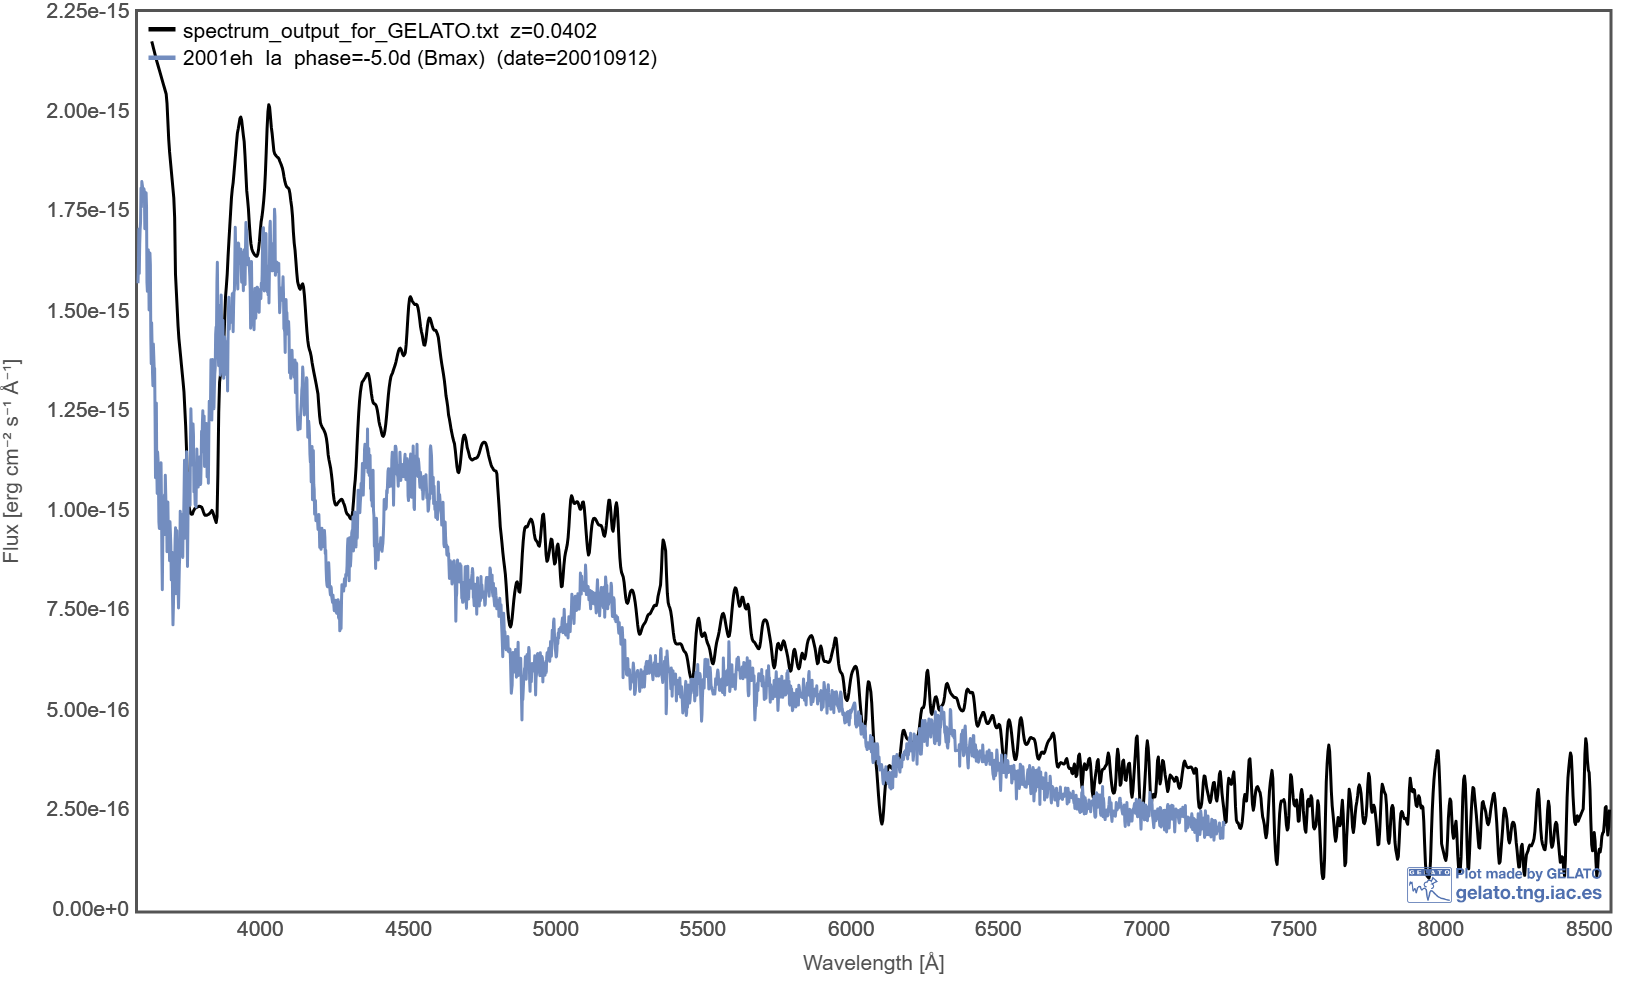

In [163]:
# 下面展示了GELATO比较的结果，以2001年超新星SN 2001eh为例
from IPython.display import Image
Image('gelatoplot_2001eh.png', width=600)

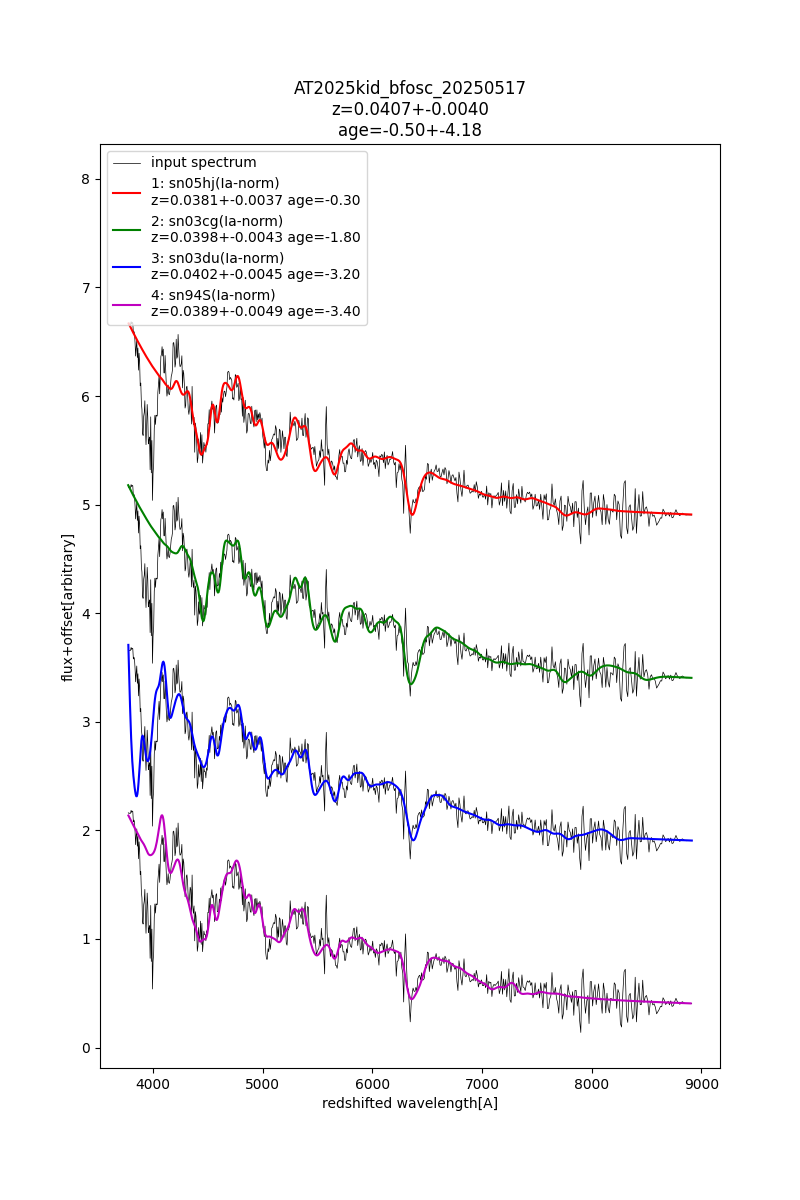

In [164]:
# 下面展示黄师兄提供的比较结果
Image('SN2025kid_bfosc_20250517_snid.png', width=600)

SN2025kid can be confidently classified as a Type Ia supernova; therefore, absorption line features are selected below to determine the redshift. The figure below is a reference chart for absorption lines.

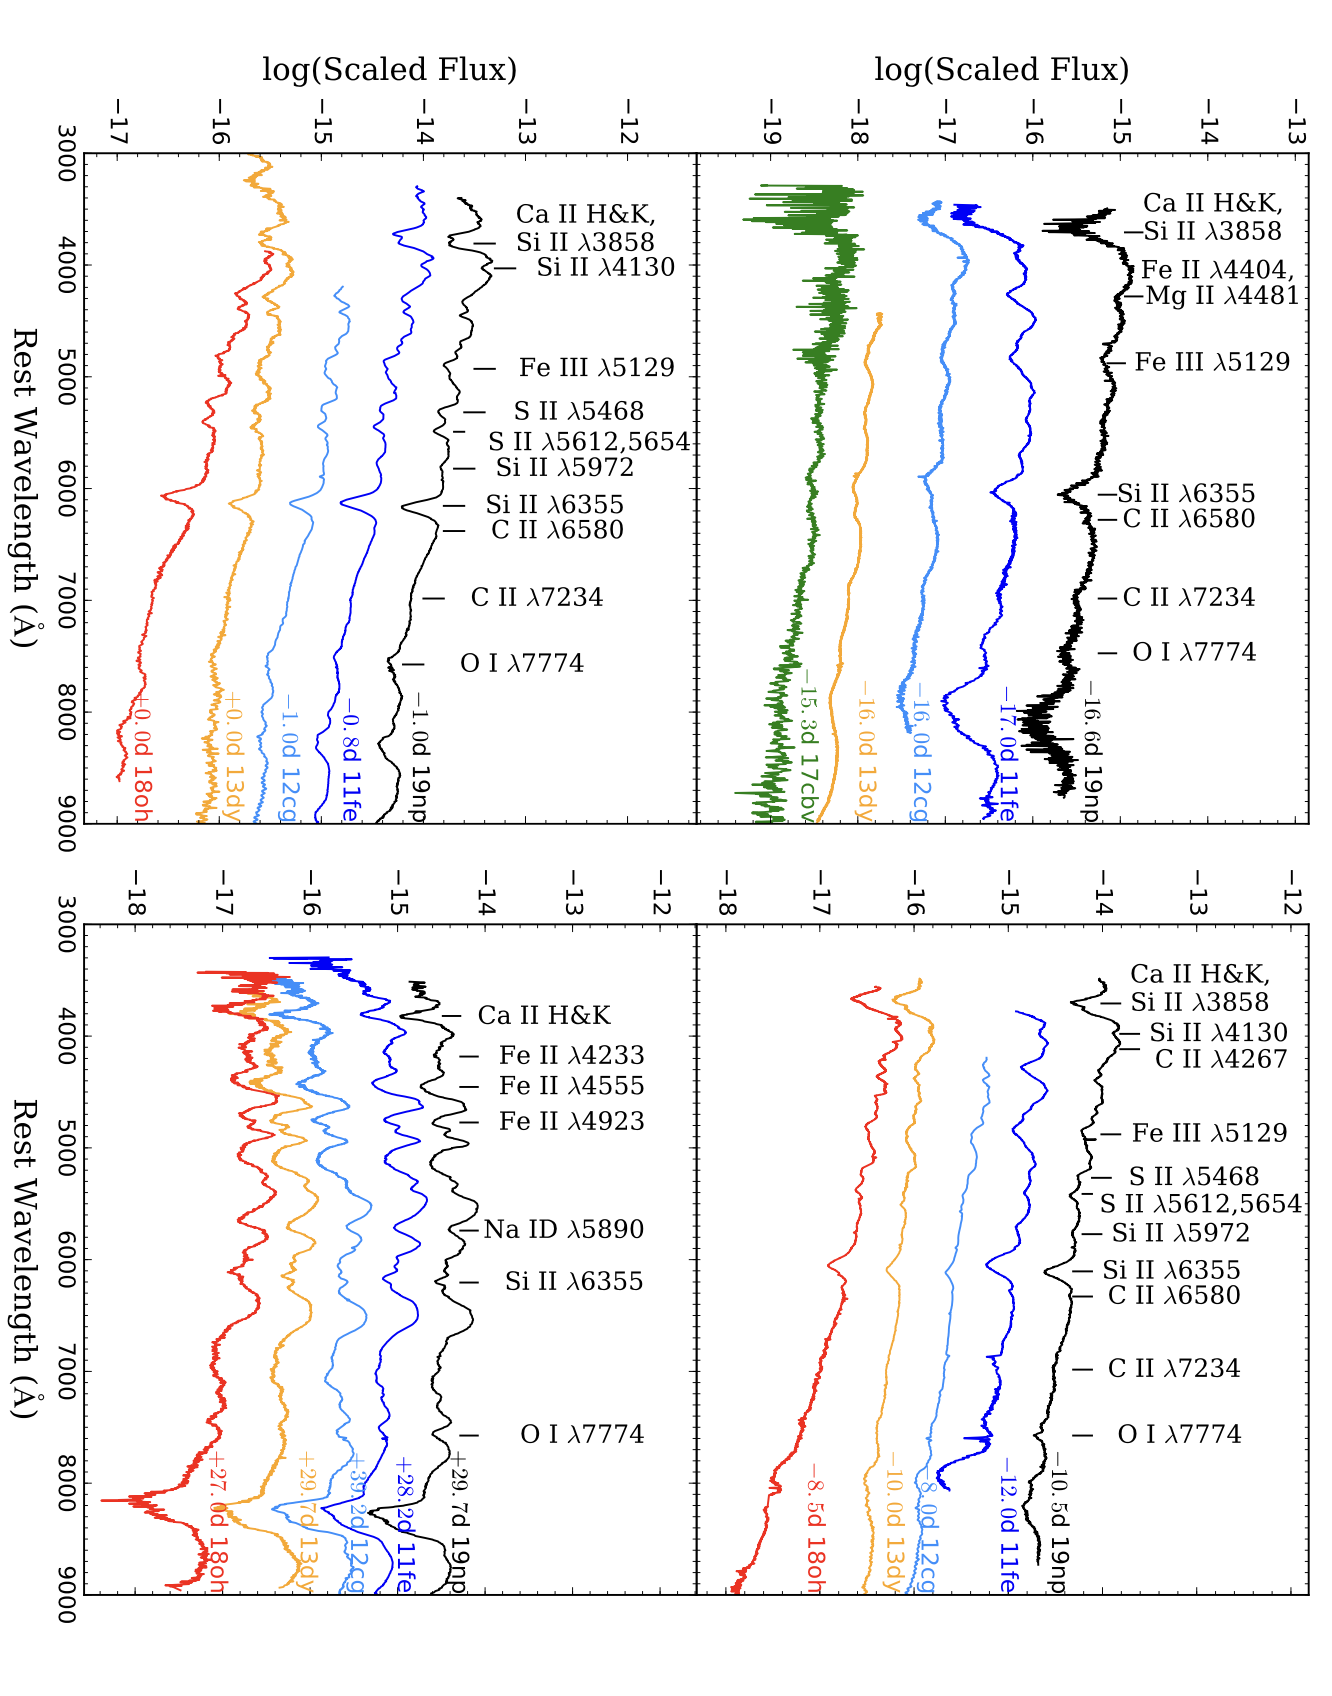

In [165]:
Image('example-lines.png', width=600)

## Redshift Measurement

### Construction of General Measurement Functions

Below is a general-purpose redshift measurement code; of course, we need to have an approximate understanding of the redshift range.

In [166]:
from matplotlib import rcParams
import matplotlib.ticker as ticker
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec
from scipy.stats import linregress
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
import warnings

# 设置科学出版物风格
def setup_publication_style():
    """设置适合科学出版物的绘图风格"""
    # 使用经典的科学绘图风格
    plt.style.use(['seaborn-v0_8-paper', 'seaborn-v0_8-deep'])
    
    # 字体设置
    rcParams['font.family'] = 'serif'
    rcParams['font.serif'] = ['Times New Roman', 'DejaVu Serif']
    rcParams['font.size'] = 10
    rcParams['axes.labelsize'] = 11
    rcParams['axes.titlesize'] = 12
    rcParams['xtick.labelsize'] = 10
    rcParams['ytick.labelsize'] = 10
    rcParams['legend.fontsize'] = 9
    
    # 图形质量
    rcParams['figure.dpi'] = 150
    rcParams['savefig.dpi'] = 300
    rcParams['savefig.format'] = 'pdf'
    
    # 线条和标记
    rcParams['lines.linewidth'] = 1.5
    rcParams['lines.markersize'] = 4
    rcParams['axes.linewidth'] = 0.8
    
    # 刻度
    rcParams['xtick.major.size'] = 4
    rcParams['ytick.major.size'] = 4
    rcParams['xtick.minor.size'] = 2
    rcParams['ytick.minor.size'] = 2
    rcParams['xtick.major.width'] = 0.8
    rcParams['ytick.major.width'] = 0.8
    rcParams['xtick.minor.width'] = 0.6
    rcParams['ytick.minor.width'] = 0.6
    rcParams['xtick.direction'] = 'in'
    rcParams['ytick.direction'] = 'in'
    rcParams['xtick.top'] = True
    rcParams['ytick.right'] = True
    
    # 图例
    rcParams['legend.frameon'] = True
    rcParams['legend.framealpha'] = 0.9
    rcParams['legend.fancybox'] = False
    rcParams['legend.edgecolor'] = 'gray'

# 优雅的配色方案
class ColorScheme:
    """科学图表的优雅配色方案"""
    # 主色调
    primary_blue = '#1f77b4'
    primary_red = '#d62728'
    primary_green = '#2ca02c'
    primary_orange = '#ff7f0e'
    
    # 柔和色调
    soft_blue = '#4c8cbf'
    soft_red = '#e67c73'
    soft_green = '#5cb85c'
    soft_yellow = '#f0ad4e'
    
    # 灰度
    dark_gray = '#2b2b2b'
    medium_gray = '#595959'
    light_gray = '#b8b8b8'
    very_light_gray = '#e5e5e5'
    
    # 透明度
    alpha_fill = 0.2
    alpha_line = 0.8
    alpha_scatter = 0.6

def gaussian(x, amplitude, center, width, offset):
    """高斯函数模型"""
    return amplitude * np.exp(-0.5 * ((x - center) / width)**2) + offset

def fit_continuum_multiple_methods(wav, flux, exclude_regions=None):
    """使用多种方法拟合连续谱"""
    # 创建掩码，排除谱线区域
    mask = np.ones(len(wav), dtype=bool)
    if exclude_regions:
        for region in exclude_regions:
            region_mask = (wav >= region[0]) & (wav <= region[1])
            mask &= ~region_mask
    
    wav_cont = wav[mask]
    flux_cont = flux[mask]
    
    if len(wav_cont) < 10:
        raise ValueError("连续谱数据点太少，无法进行可靠拟合")
    
    methods = {}
    
    # 方法1: 线性拟合
    slope, intercept, r_val, _, _ = linregress(wav_cont, flux_cont)
    linear_model = slope * wav + intercept
    methods['linear'] = {
        'model': linear_model,
        'params': [slope, intercept],
        'r_squared': r_val**2,
        'name': 'Linear Fit'
    }
    
    # 方法2: 二次多项式拟合
    if len(wav_cont) >= 3:
        poly2_coeffs = np.polyfit(wav_cont, flux_cont, 2)
        poly2_model = np.polyval(poly2_coeffs, wav)
        ss_res = np.sum((flux_cont - np.polyval(poly2_coeffs, wav_cont))**2)
        ss_tot = np.sum((flux_cont - np.mean(flux_cont))**2)
        r2_poly2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
        methods['poly2'] = {
            'model': poly2_model,
            'params': poly2_coeffs,
            'r_squared': r2_poly2,
            'name': 'Quadratic Fit'
        }
    
    # 方法3: 三次多项式拟合
    if len(wav_cont) >= 4:
        poly3_coeffs = np.polyfit(wav_cont, flux_cont, 3)
        poly3_model = np.polyval(poly3_coeffs, wav)
        ss_res = np.sum((flux_cont - np.polyval(poly3_coeffs, wav_cont))**2)
        r2_poly3 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
        methods['poly3'] = {
            'model': poly3_model,
            'params': poly3_coeffs,
            'r_squared': r2_poly3,
            'name': 'Cubic Fit'
        }
    
    # 方法4: 样条插值
    if len(wav_cont) >= 5:
        try:
            spline = UnivariateSpline(wav_cont, flux_cont, s=len(wav_cont)*0.1)
            spline_model = spline(wav)
            ss_res = np.sum((flux_cont - spline(wav_cont))**2)
            r2_spline = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
            methods['spline'] = {
                'model': spline_model,
                'params': spline,
                'r_squared': r2_spline,
                'name': 'Spline Fit'
            }
        except:
            pass
    
    return methods, wav_cont, flux_cont

def auto_set_analysis_regions(rest_wavelength, expected_redshift=0.0, 
                            line_width_guess=30, continuum_width=100):
    """根据静止波长自动设置分析区域"""
    # 根据红移调整观测波长
    observed_wavelength = rest_wavelength * (1 + expected_redshift)
    
    # 设置分析范围（谱线中心±200Å）
    analysis_left = observed_wavelength - 200
    analysis_right = observed_wavelength + 200
    
    # 设置谱线区域（观测波长±line_width_guess）
    line_left = observed_wavelength - line_width_guess
    line_right = observed_wavelength + line_width_guess
    line_regions = [(line_left, line_right)]
    
    # 设置连续谱区域（谱线两侧各continuum_width宽度）
    cont_left1 = analysis_left
    cont_right1 = line_left - 10
    cont_left2 = line_right + 10
    cont_right2 = analysis_right
    
    continuum_regions = [(cont_left1, cont_right1), (cont_left2, cont_right2)]
    
    return {
        'analysis_left': analysis_left,
        'analysis_right': analysis_right,
        'line_regions': line_regions,
        'continuum_regions': continuum_regions,
        'observed_wavelength_guess': observed_wavelength
    }

def universal_redshift_measurement(wav_clean, flux_clean, 
                                 line_name, rest_wavelength,
                                 expected_redshift=0.0,
                                 line_width_guess=30,
                                 continuum_width=100,
                                 analysis_left=None, analysis_right=None,
                                 line_regions=None, continuum_regions=None,
                                 continuum_method='auto',
                                 line_type='absorption',
                                 plot=True):
    """通用谱线红移测量函数 - 科学出版物风格"""
    
    print(f"{line_name} {rest_wavelength:.1f}Å 谱线红移分析")
    print("="*60)
    
    # 自动设置分析区域（如果未手动指定）
    if any(param is None for param in [analysis_left, analysis_right, line_regions, continuum_regions]):
        print(f"根据静止波长 {rest_wavelength:.1f}Å 自动设置分析区域...")
        auto_regions = auto_set_analysis_regions(rest_wavelength, expected_redshift, 
                                                line_width_guess, continuum_width)
        
        if analysis_left is None:
            analysis_left = auto_regions['analysis_left']
        if analysis_right is None:
            analysis_right = auto_regions['analysis_right']
        if line_regions is None:
            line_regions = auto_regions['line_regions']
        if continuum_regions is None:
            continuum_regions = auto_regions['continuum_regions']
    
    print(f"分析参数:")
    print(f"  谱线: {line_name} {rest_wavelength:.1f}Å ({line_type})")
    print(f"  分析范围: {analysis_left:.1f}-{analysis_right:.1f}Å")
    print(f"  谱线区域: {line_regions}")
    print(f"  连续谱区域: {continuum_regions}")
    
    # 1. 选择分析波长范围
    mask_range = (wav_clean >= analysis_left) & (wav_clean <= analysis_right)
    fit_wav = wav_clean[mask_range]
    fit_flux = flux_clean[mask_range]
    
    if len(fit_wav) == 0:
        raise ValueError(f"在指定波长范围 {analysis_left:.1f}-{analysis_right:.1f}Å 内没有找到数据！")
    
    print(f"  找到 {len(fit_wav)} 个数据点")
    
    # 2. 连续谱拟合
    print("\n连续谱拟合:")
    try:
        methods, wav_cont_selected, flux_cont_selected = fit_continuum_multiple_methods(
            fit_wav, fit_flux, line_regions)
    except ValueError as e:
        print(f"错误: {e}")
        return None
    
    # 选择最佳拟合方法
    if continuum_method == 'auto':
        best_method = max(methods.keys(), key=lambda k: methods[k]['r_squared'])
        print(f"  自动选择: {methods[best_method]['name']} (R²={methods[best_method]['r_squared']:.4f})")
    else:
        if continuum_method in methods:
            best_method = continuum_method
            print(f"  使用指定方法: {methods[best_method]['name']}")
        else:
            print(f"  指定方法 {continuum_method} 不可用，自动选择最佳方法")
            best_method = max(methods.keys(), key=lambda k: methods[k]['r_squared'])
    
    best_continuum = methods[best_method]['model']
    
    # 3. 归一化光谱
    norm_flux = fit_flux / best_continuum
    
    # 4. 谱线拟合
    print(f"\n{line_name} {rest_wavelength:.1f}Å 谱线拟合:")
    
    # 寻找谱线中心的初始猜测
    line_mask = (fit_wav >= line_regions[0][0]) & (fit_wav <= line_regions[0][1])
    if np.sum(line_mask) == 0:
        raise ValueError("谱线区域内没有数据点！")
    
    line_flux_region = norm_flux[line_mask]
    line_wav_region = fit_wav[line_mask]
    
    if line_type == 'absorption':
        extreme_idx = np.argmin(line_flux_region)
        amplitude_guess = -0.3
        bounds_amp = (-np.inf, 0)
    else:
        extreme_idx = np.argmax(line_flux_region)
        amplitude_guess = 0.3
        bounds_amp = (0, np.inf)
    
    line_center_guess = line_wav_region[extreme_idx]
    width_guess = line_width_guess / 2.35
    
    print(f"  初始猜测: 中心={line_center_guess:.2f}Å, 类型={line_type}")
    
    # 高斯拟合参数设置
    guess_gauss = [amplitude_guess, line_center_guess, width_guess, 1.0]
    bounds_gauss = ((bounds_amp[0], line_center_guess - 100, 1, 0.5), 
                   (bounds_amp[1], line_center_guess + 100, 50, 1.5))
    
    try:
        popt_gauss, pcov_gauss = curve_fit(gaussian, fit_wav, norm_flux, 
                                          p0=guess_gauss, bounds=bounds_gauss)
        gauss_fit = gaussian(fit_wav, *popt_gauss)
        
        # 计算拟合质量
        residuals = norm_flux - gauss_fit
        chi2 = np.sum(residuals**2)
        reduced_chi2 = chi2 / (len(fit_wav) - len(popt_gauss))
        
        # 计算红移
        observed_wavelength = popt_gauss[1]
        wavelength_error = np.sqrt(pcov_gauss[1,1])
        redshift = observed_wavelength / rest_wavelength - 1
        redshift_error = wavelength_error / rest_wavelength
        
        # 计算径向速度
        c = 299792.458  # km/s
        velocity = redshift * c
        velocity_error = redshift_error * c
        
        print(f"  拟合成功！")
        print(f"  观测中心: {observed_wavelength:.3f} ± {wavelength_error:.3f}Å")
        print(f"  红移: z = {redshift:.5f} ± {redshift_error:.5f}")
        print(f"  径向速度: v = {velocity:.1f} ± {velocity_error:.1f} km/s")
        print(f"  约化χ²: {reduced_chi2:.4f}")
        
        # 科学出版物风格绘图
        if plot:
            setup_publication_style()
            colors = ColorScheme()
            
            # 创建图形使用GridSpec进行精确布局控制
            fig = plt.figure(figsize=(16, 12))
            gs = gridspec.GridSpec(3, 3, figure=fig, 
                                 height_ratios=[1.2, 1.2, 0.8],
                                 width_ratios=[1, 1, 1],
                                 hspace=0.3, wspace=0.25)
            
            # 1. 原始光谱和区域标记 (左上)
            ax1 = fig.add_subplot(gs[0, 0])
            ax1.plot(fit_wav, fit_flux, color=colors.primary_blue, 
                    linewidth=1.2, alpha=0.9, label='Original Spectrum')
            ax1.axvline(x=rest_wavelength, color=colors.primary_orange, 
                       linestyle='--', alpha=0.8, linewidth=1.5,
                       label=f'Rest {rest_wavelength:.1f}A')
            
            # 标记各个区域
            for i, region in enumerate(line_regions):
                label = 'Line Region' if i == 0 else None
                ax1.axvspan(region[0], region[1], alpha=colors.alpha_fill, 
                           color=colors.primary_red, label=label)
            for i, region in enumerate(continuum_regions):
                label = 'Continuum Region' if i == 0 else None
                ax1.axvspan(region[0], region[1], alpha=colors.alpha_fill*0.7, 
                           color=colors.primary_green, label=label)
            
            ax1.set_xlabel('Wavelength (Å)')
            ax1.set_ylabel('Flux')
            ax1.set_title(f'(a) {line_name} {rest_wavelength:.1f}Å - Original Spectrum')
            ax1.legend(loc='best',fontsize=7)
            ax1.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
            ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
            ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
            
            # 2. 连续谱拟合比较 (中上)
            ax2 = fig.add_subplot(gs[0, 1])
            ax2.plot(fit_wav, fit_flux, color=colors.dark_gray, 
                    linewidth=1.0, alpha=0.7, label='Original Spectrum')
            
            # 标记连续谱数据点
            for region in continuum_regions:
                region_mask = (fit_wav >= region[0]) & (fit_wav <= region[1])
                ax2.scatter(fit_wav[region_mask], fit_flux[region_mask], 
                           s=8, alpha=0.6, color=colors.primary_green, 
                           label='Continuous Spectrum Points' if region == continuum_regions[0] else "")
            
            # 绘制不同的拟合方法
            method_colors = [colors.primary_red, colors.primary_blue, 
                           colors.soft_green, colors.primary_orange]
            for i, (method_name, method_data) in enumerate(methods.items()):
                linestyle = '-' if method_name == best_method else '--'
                alpha = 1.0 if method_name == best_method else 0.7
                linewidth = 2.0 if method_name == best_method else 1.2
                ax2.plot(fit_wav, method_data['model'], linestyle, 
                        color=method_colors[i % len(method_colors)], 
                        linewidth=linewidth, alpha=alpha,
                        label=f"{method_data['name']} (R²={method_data['r_squared']:.3f})")
            
            ax2.set_xlabel('Wavelength (Å)')
            ax2.set_ylabel('Flux')
            ax2.set_title('(b) Comparison of Continuous Spectrum Fitting Methods')
            ax2.legend(loc='best', fontsize=7)
            ax2.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
            ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
            ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
            
            # 3. 归一化光谱 (右上)
            ax3 = fig.add_subplot(gs[0, 2])
            ax3.plot(fit_wav, norm_flux, color=colors.primary_blue, 
                    linewidth=1.2, label='Normalized Spectrum')
            ax3.axhline(y=1, color=colors.primary_red, linestyle='--', 
                       alpha=0.6, linewidth=1.5, label='Continuous Spectrum Level')
            ax3.axvline(x=rest_wavelength, color=colors.primary_orange, 
                       linestyle='--', alpha=0.8, linewidth=1.5,
                       label=f'Rest Wavelength {rest_wavelength:.1f}Å')
            
            for region in line_regions:
                ax3.axvspan(region[0], region[1], alpha=colors.alpha_fill, 
                           color=colors.primary_red)
            
            ax3.set_xlabel('Wavelength (Å)')
            ax3.set_ylabel('Normalized Flux')
            ax3.set_title(f'(c) Normalized Spectrum\n({methods[best_method]["name"]})')
            ax3.legend(loc='best',fontsize=7)
            ax3.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
            ax3.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
            ax3.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
            
            # 4. 高斯拟合结果 (左下)
            ax4 = fig.add_subplot(gs[1, 0])
            ax4.plot(fit_wav, norm_flux, color=colors.dark_gray, 
                    linewidth=1.0, alpha=0.8, label='Normalized Spectrum')
            ax4.plot(fit_wav, gauss_fit, color=colors.primary_red, 
                    linewidth=2.0, label='Gaussian Fit')
            ax4.axvline(x=observed_wavelength, color=colors.primary_red, 
                       linestyle=':', alpha=0.9, linewidth=2.0,
                       label=f'Observation Center: {observed_wavelength:.2f}Å')
            ax4.axvline(x=rest_wavelength, color=colors.primary_orange, 
                       linestyle=':', alpha=0.9, linewidth=2.0,
                       label=f'Rest Wavelength: {rest_wavelength:.1f}Å')
            
            ax4.axvspan(line_regions[0][0], line_regions[0][1], 
                       alpha=colors.alpha_fill*0.5, color=colors.primary_red)
            ax4.set_xlabel('Wavelength (Å)')
            ax4.set_ylabel('Normalized Flux')
            ax4.set_title(f'(d) {line_name} {rest_wavelength:.1f}Å Gaussian Fit')
            ax4.legend(loc='best', fontsize=6)
            ax4.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
            ax4.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
            ax4.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
            
            # 5. 拟合残差 (中下)
            ax5 = fig.add_subplot(gs[1, 1])
            ax5.plot(fit_wav, residuals, color=colors.soft_green, 
                    linewidth=1.2, alpha=0.8, label='Residuals')
            ax5.axhline(y=0, color=colors.primary_red, linestyle='--', 
                       alpha=0.6, linewidth=1.5)
            
            # 计算残差的标准差
            residual_std = np.std(residuals)
            ax5.axhline(y=residual_std, color=colors.primary_orange, 
                       linestyle=':', alpha=0.6, linewidth=1.2, 
                       label=f'±1σ ({residual_std:.3f})')
            ax5.axhline(y=-residual_std, color=colors.primary_orange, 
                       linestyle=':', alpha=0.6, linewidth=1.2)
            
            ax5.set_xlabel('Wavelength (Å)')
            ax5.set_ylabel('Residuals')
            ax5.set_title('(e) Fitting Residuals Analysis')
            ax5.legend(loc='best',fontsize=7)
            ax5.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
            ax5.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
            ax5.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
            
            # 6. 红移结果可视化 (右下)
            ax6 = fig.add_subplot(gs[1, 2])
            # 绘制红移效应示意图
            rest_line_pos = [rest_wavelength, rest_wavelength]
            obs_line_pos = [observed_wavelength, observed_wavelength]
            y_range = [0.8, 1.2]
            
            ax6.plot(rest_line_pos, y_range, color=colors.primary_orange, 
                    linewidth=3, alpha=0.8, label=f'Rest Wavelength\n{rest_wavelength:.1f}Å')
            ax6.plot(obs_line_pos, y_range, color=colors.primary_red, 
                    linewidth=3, alpha=0.8, label=f'Observational Wavelength\n{observed_wavelength:.1f}Å')
            
            # 双向箭头显示红移
            ax6.annotate('', xy=(observed_wavelength, 1.0), 
                        xytext=(rest_wavelength, 1.0),
                        arrowprops=dict(arrowstyle='<->', 
                                      color=colors.primary_blue, lw=2))
            
            # 红移标签
            mid_wavelength = (rest_wavelength + observed_wavelength) / 2
            ax6.text(mid_wavelength, 1.05, f'Δλ = {observed_wavelength - rest_wavelength:.1f}Å\nz = {redshift:.5f}', 
                    ha='center', va='bottom', fontsize=10, 
                    bbox=dict(boxstyle='round,pad=0.3', 
                            facecolor=colors.very_light_gray, alpha=0.8))
            
            ax6.set_xlabel('Wavelength (Å)')
            ax6.set_ylabel('Normalized Flux')
            ax6.set_title('(f) Illustration of the Redshift Effect')
            ax6.legend(loc='best',fontsize=7)
            ax6.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
            ax6.set_ylim(0.7, 1.3)
            
            # 质量评估
            
            quality_text = f"Fit Quality Assessment: "
            if methods[best_method]['r_squared'] > 0.95 and reduced_chi2 < 2.0:
                quality_text += "Excellent"
                quality_color = colors.primary_green
                quality_status = "Excellent"
            elif methods[best_method]['r_squared'] > 0.90 and reduced_chi2 < 5.0:
                quality_text += "Good"
                quality_color = colors.soft_yellow
                quality_status = "Good"
            else:
                quality_text += "Needs Improvement"
                quality_color = colors.primary_red
                quality_status = "Needs Improvement"

            # 增加输出功能 - 打印详细结果摘要
            print("\n" + "="*70)
            print(f"REDSHIFT ANALYSIS SUMMARY - {line_name} {rest_wavelength:.1f}Å")
            print("="*70)
            print(f"Observed Wavelength: {observed_wavelength:.3f} ± {wavelength_error:.3f} Å")
            print(f"Rest Wavelength: {rest_wavelength:.1f} Å")
            print(f"Redshift: z = {redshift:.5f} ± {redshift_error:.5f}")
            print(f"Radial Velocity: {velocity:.1f} ± {velocity_error:.1f} km/s")
            print(f"Line Width (FWHM): {abs(popt_gauss[2])*2.35:.1f} Å")
            print(f"Continuum Method: {methods[best_method]['name']} (R² = {methods[best_method]['r_squared']:.4f})")
            print(f"Reduced χ²: {reduced_chi2:.4f}")
            print(f"Fit Quality: {quality_status}")
            print("="*70)
            
            # 设置总标题
            fig.suptitle(f'{line_name} {rest_wavelength:.1f}Å Redshift Analysis Results', 
                        fontsize=16, weight='bold', y=0.95)
            
            plt.show()
        
        return {
            'redshift': redshift,
            'redshift_error': redshift_error,
            'observed_wavelength': observed_wavelength,
            'wavelength_error': wavelength_error,
            'rest_wavelength': rest_wavelength,
            'line_name': line_name,
            'line_type': line_type,
            'continuum_method': methods[best_method]['name'],
            'continuum_r_squared': methods[best_method]['r_squared'],
            'reduced_chi_squared': reduced_chi2,
            'velocity_km_s': velocity,
            'velocity_error_km_s': velocity_error,
            'line_width_fwhm_angstrom': abs(popt_gauss[2]) * 2.35,
            'fit_params': popt_gauss,
            'fit_covariance': pcov_gauss,
            'analysis_regions': {
                'analysis_range': (analysis_left, analysis_right),
                'line_regions': line_regions,
                'continuum_regions': continuum_regions
            }
        }
        
    except Exception as e:
        print(f"拟合失败: {e}")
        return None

# 预定义的常用谱线库
COMMON_LINES = {
    'Si_II_4267': {'name': 'Si II', 'rest_wavelength': 4267.0, 'type': 'absorption'},
    'Si_II_4130': {'name': 'Si II', 'rest_wavelength': 4130.0, 'type': 'absorption'},
    'Si_II_3858': {'name': 'Si II', 'rest_wavelength': 3858.0, 'type': 'absorption'},
    'H_alpha': {'name': 'H-α', 'rest_wavelength': 6562.8, 'type': 'emission'},
    'H_beta': {'name': 'H-β', 'rest_wavelength': 4861.3, 'type': 'emission'},
    'H_gamma': {'name': 'H-γ', 'rest_wavelength': 4340.5, 'type': 'emission'},
    'Ca_II_K': {'name': 'Ca II K', 'rest_wavelength': 3933.7, 'type': 'absorption'},
    'Ca_II_H': {'name': 'Ca II H', 'rest_wavelength': 3968.5, 'type': 'absorption'},
    'Mg_II_2798': {'name': 'Mg II', 'rest_wavelength': 2798.0, 'type': 'absorption'},
    'Fe_II_5169': {'name': 'Fe II', 'rest_wavelength': 5169.0, 'type': 'absorption'},
}

def quick_line_analysis(wav_clean, flux_clean, line_key, **kwargs):
    """使用预定义谱线进行快速分析"""
    if line_key not in COMMON_LINES:
        print(f"未知谱线: {line_key}")
        print(f"可用谱线: {list(COMMON_LINES.keys())}")
        return None
    
    line_info = COMMON_LINES[line_key]
    return universal_redshift_measurement(
        wav_clean, flux_clean,
        line_name=line_info['name'],
        rest_wavelength=line_info['rest_wavelength'],
        line_type=line_info['type'],
        **kwargs
    )

# 使用示例
def usage_examples():
    """使用示例"""
    print("使用示例")
    print("="*50)
    print("\n1. Si II 4267Å 基本分析:")
    print("results = universal_redshift_measurement(wav_clean, flux_clean, 'Si II', 4267.0)")
    
    print("\n2. 使用预定义谱线:")
    print("results = quick_line_analysis(wav_clean, flux_clean, 'Si_II_4267')")
    
    print("\n3. 关闭绘图（仅获得结果）:")
    print("results = universal_redshift_measurement(wav_clean, flux_clean, 'Si II', 4267.0, plot=False)")

usage_examples()

使用示例

1. Si II 4267Å 基本分析:
results = universal_redshift_measurement(wav_clean, flux_clean, 'Si II', 4267.0)

2. 使用预定义谱线:
results = quick_line_analysis(wav_clean, flux_clean, 'Si_II_4267')

3. 关闭绘图（仅获得结果）:
results = universal_redshift_measurement(wav_clean, flux_clean, 'Si II', 4267.0, plot=False)


### Measuring Redshift Using Specific Spectral Lines

Here, I select four absorption lines with relatively prominent features as representatives for redshift calculation.

#### Redshift Analysis in the Fe II 4233.0 Å Spectral Line

Fe II 4233.0Å 谱线红移分析
根据静止波长 4233.0Å 自动设置分析区域...
分析参数:
  谱线: Fe II 4233.0Å (absorption)
  分析范围: 4202.3-4602.3Å
  谱线区域: [(4302.32, 4502.32)]
  连续谱区域: [(4202.32, 4292.32), (4512.32, 4602.32)]
  找到 119 个数据点

连续谱拟合:
  自动选择: Cubic Fit (R²=0.9773)

Fe II 4233.0Å 谱线拟合:
  初始猜测: 中心=4424.06Å, 类型=absorption
  拟合成功！
  观测中心: 4433.031 ± 1.837Å
  红移: z = 0.04726 ± 0.00043
  径向速度: v = 14166.8 ± 130.1 km/s
  约化χ²: 0.0015

REDSHIFT ANALYSIS SUMMARY - Fe II 4233.0Å
Observed Wavelength: 4433.031 ± 1.837 Å
Rest Wavelength: 4233.0 Å
Redshift: z = 0.04726 ± 0.00043
Radial Velocity: 14166.8 ± 130.1 km/s
Line Width (FWHM): 117.5 Å
Continuum Method: Cubic Fit (R² = 0.9773)
Reduced χ²: 0.0015
Fit Quality: Excellent


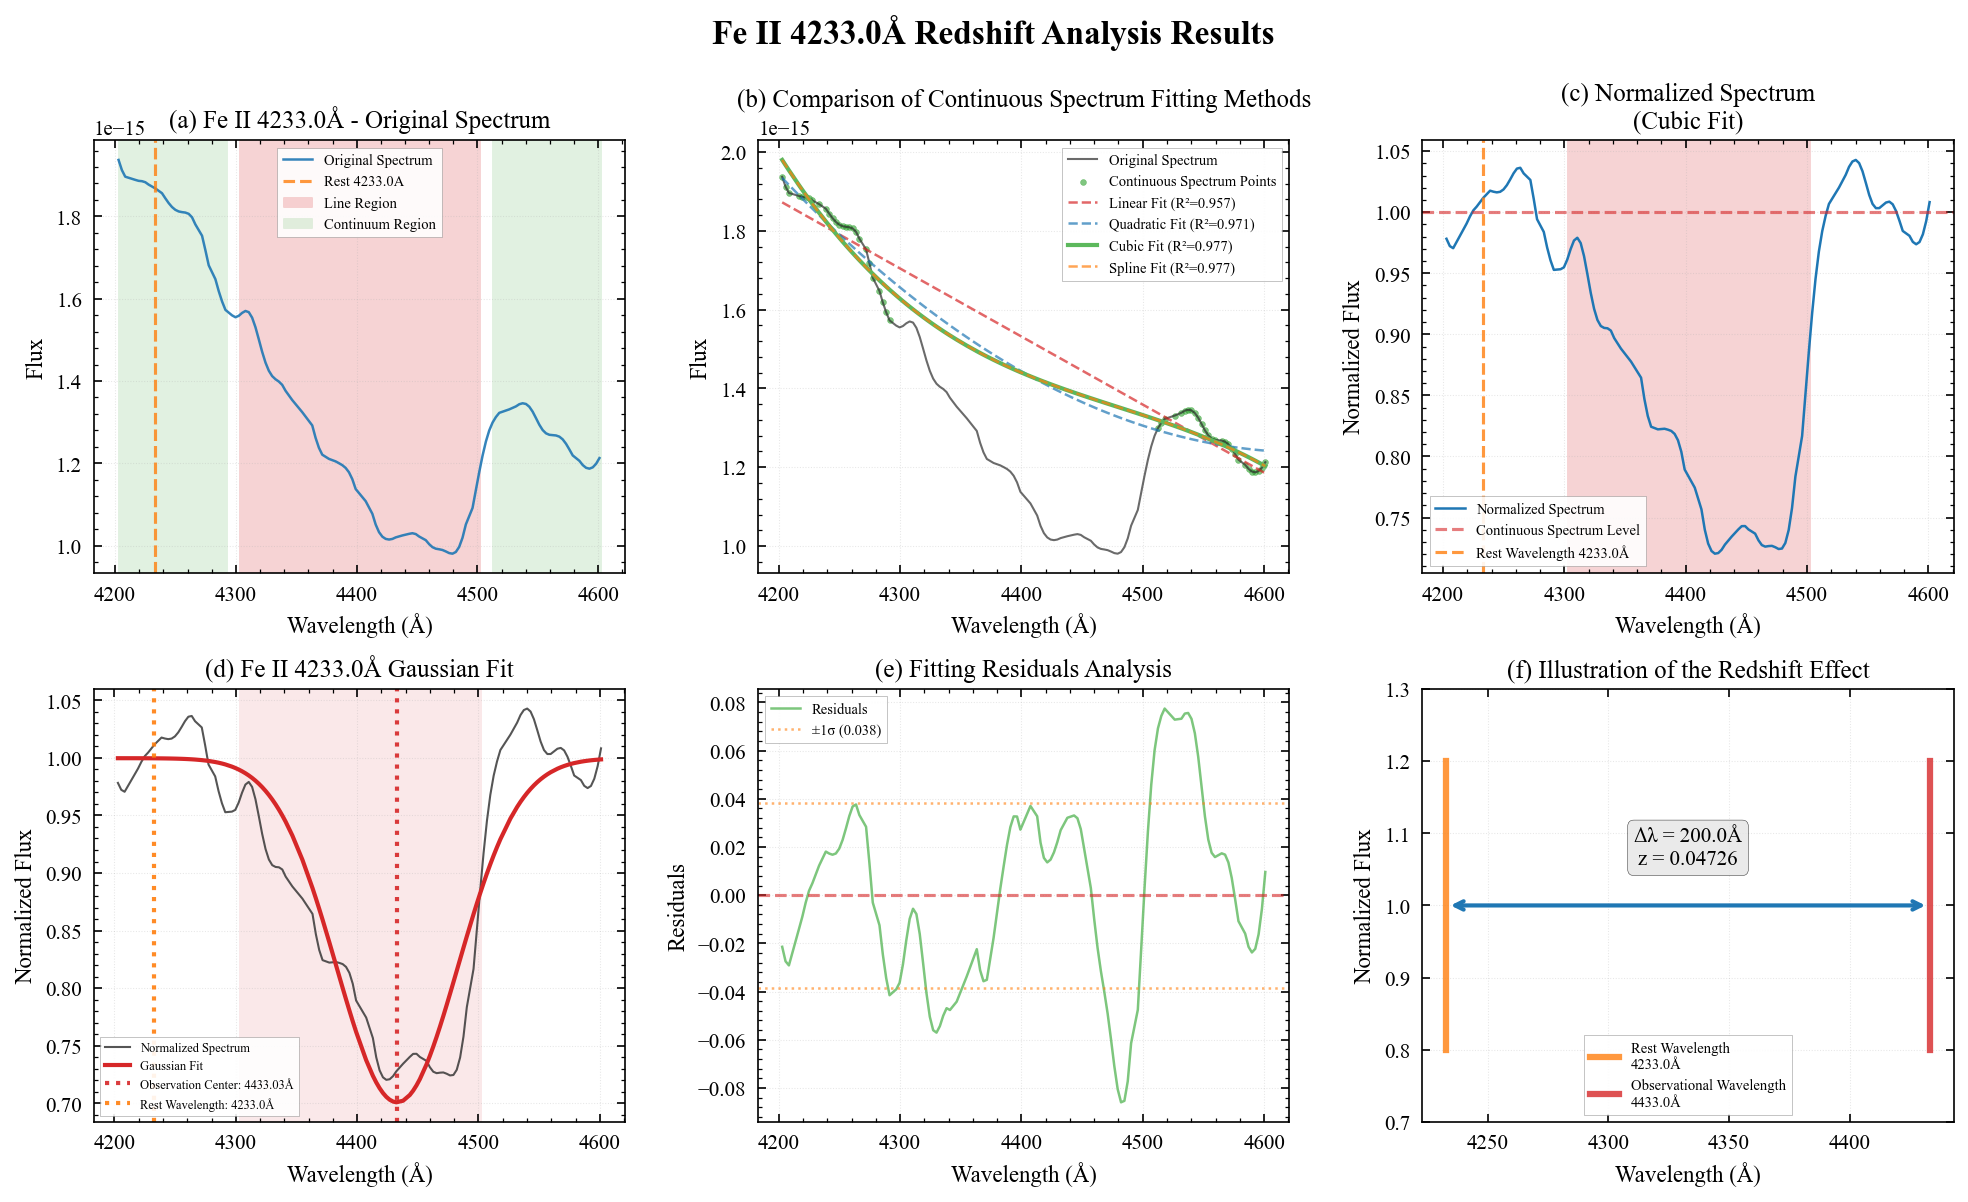

In [167]:
results = universal_redshift_measurement(
    wav_clean, flux_clean,
    line_name='Fe II', rest_wavelength=4233.0,
    expected_redshift=0.04,  # 如果你知道大概红移
    line_width_guess=100,     # 根据光谱分辨率调整
)

#### Redshift Analysis of the Si II 3858.0Å Spectral Line

Si II 3858.0Å 谱线红移分析
根据静止波长 3858.0Å 自动设置分析区域...
分析参数:
  谱线: Si II 3858.0Å (absorption)
  分析范围: 3812.3-4212.3Å
  谱线区域: [(3912.32, 4112.32)]
  连续谱区域: [(3812.32, 3902.32), (4122.32, 4212.32)]
  找到 90 个数据点

连续谱拟合:
  使用指定方法: Linear Fit

Si II 3858.0Å 谱线拟合:
  初始猜测: 中心=4006.55Å, 类型=absorption
  拟合成功！
  观测中心: 3959.993 ± 3.371Å
  红移: z = 0.02644 ± 0.00087
  径向速度: v = 7925.5 ± 262.0 km/s
  约化χ²: 0.0096

REDSHIFT ANALYSIS SUMMARY - Si II 3858.0Å
Observed Wavelength: 3959.993 ± 3.371 Å
Rest Wavelength: 3858.0 Å
Redshift: z = 0.02644 ± 0.00087
Radial Velocity: 7925.5 ± 262.0 km/s
Line Width (FWHM): 112.4 Å
Continuum Method: Linear Fit (R² = 0.3181)
Reduced χ²: 0.0096
Fit Quality: Needs Improvement


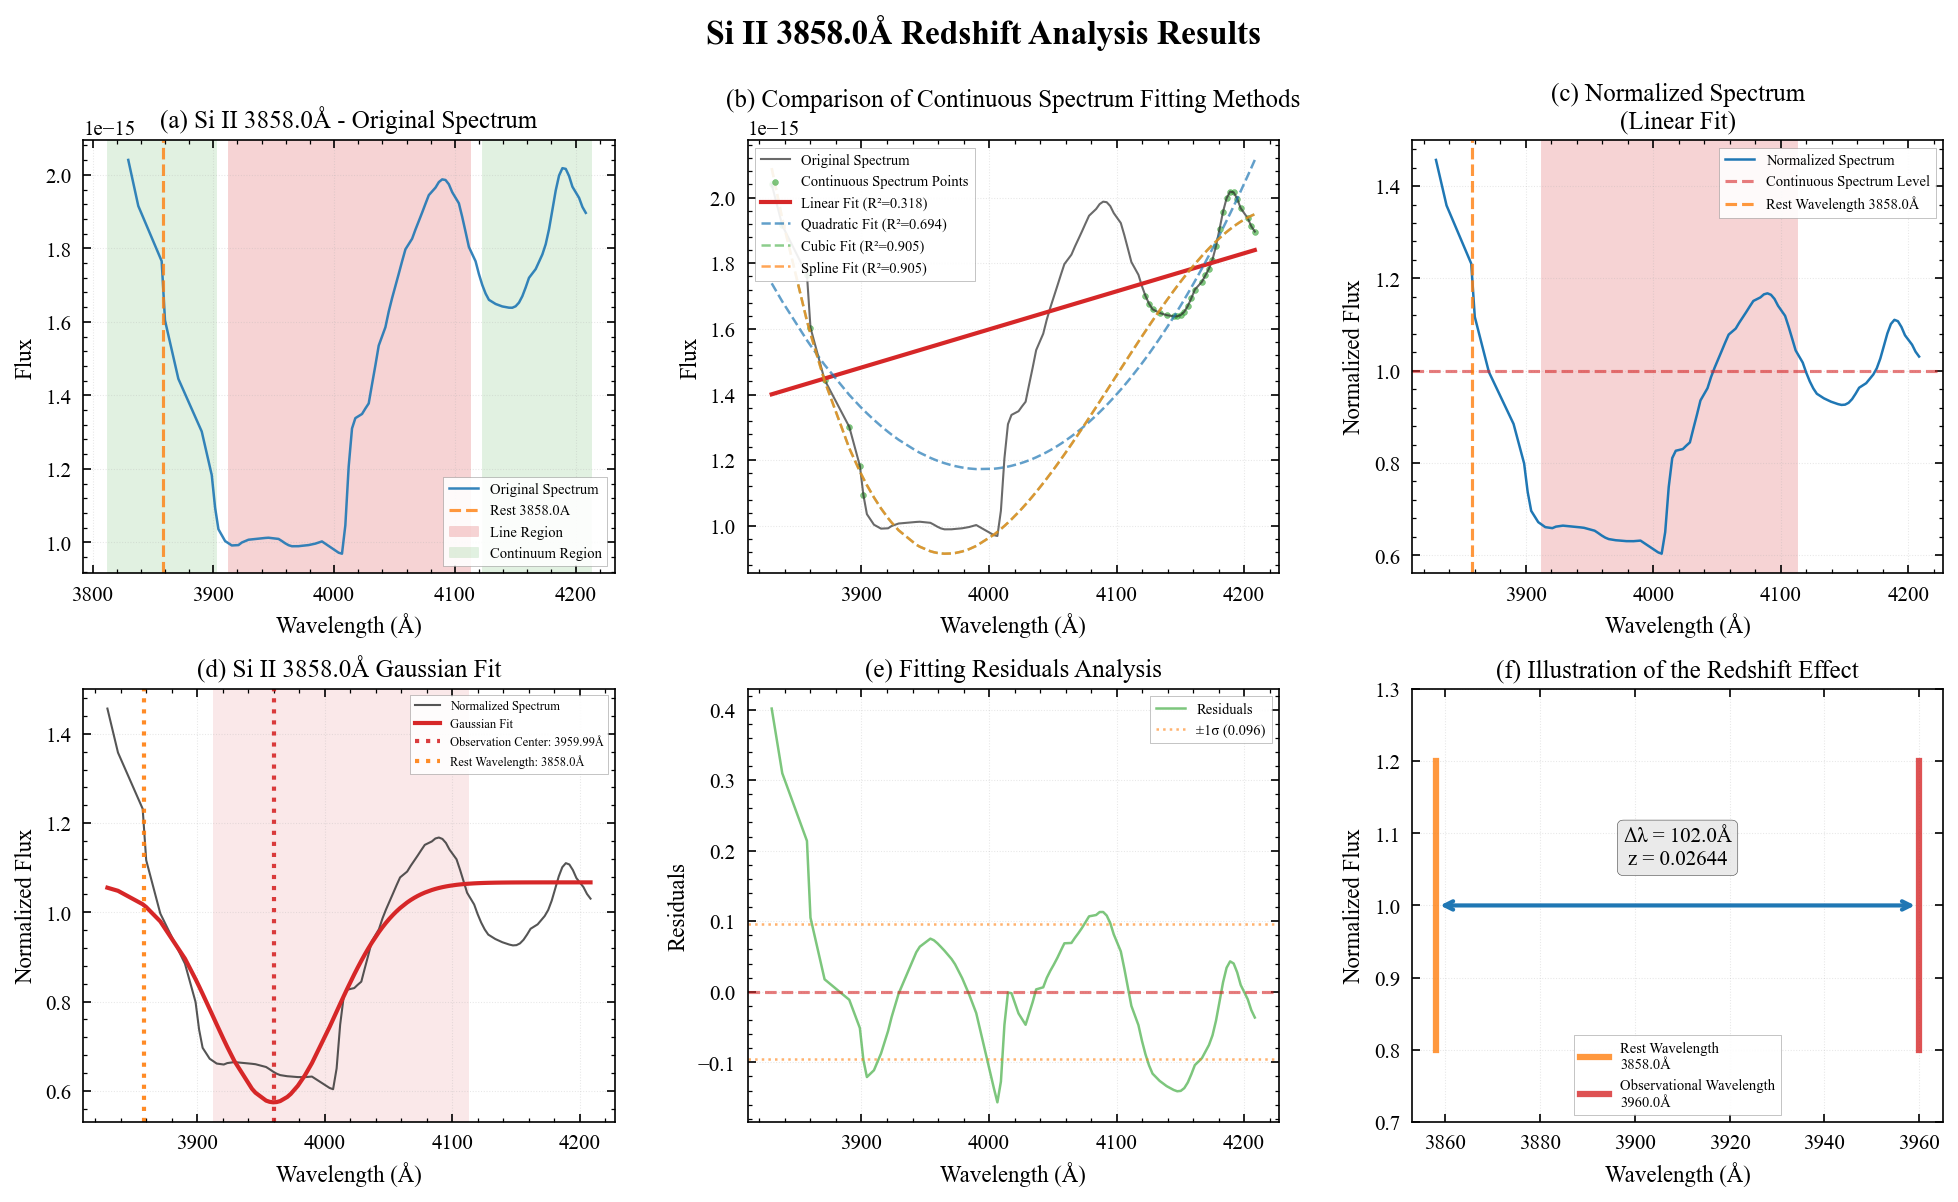

In [168]:
results = universal_redshift_measurement(
    wav_clean, flux_clean,
    line_name='Si II', rest_wavelength=3858,
    expected_redshift=0.04,  # 如果你知道大概红移
    line_width_guess=100,     # 根据光谱分辨率调整
    continuum_method='linear',  # 使用线性作为连续谱拟合方法
)

For the spectral line near 4000 Å, where this absorption feature is most prominent, we can visually observe from the original spectral image and assume that its redshifted absorption peak is located at 4000 Å. As a rough estimate, we can directly calculate the redshift as: $$ z = (4000 - 3858)/(3858) \approx 0.0368 $$ This value is clearly much closer to a reasonable redshift (using the host galaxy as a reference), and the difference can be attributed to possible gas outflow velocities. This also serves as additional evidence supporting the validity of both the spectral processing method and the redshift measurement.

 #### Redshift Analysis in the Fe II 4923.0 Å Spectral Line

Fe II 4923.0Å 谱线红移分析
根据静止波长 4923.0Å 自动设置分析区域...
分析参数:
  谱线: Fe II 4923.0Å (absorption)
  分析范围: 4919.9-5319.9Å
  谱线区域: [(5069.92, 5169.92)]
  连续谱区域: [(4900, 5000), (5100, 5300)]
  找到 141 个数据点

连续谱拟合:
  自动选择: Cubic Fit (R²=0.7022)

Fe II 4923.0Å 谱线拟合:
  初始猜测: 中心=5073.82Å, 类型=absorption
  拟合成功！
  观测中心: 5039.903 ± 2.642Å
  红移: z = 0.02375 ± 0.00054
  径向速度: v = 7119.0 ± 160.9 km/s
  约化χ²: 0.0061

REDSHIFT ANALYSIS SUMMARY - Fe II 4923.0Å
Observed Wavelength: 5039.903 ± 2.642 Å
Rest Wavelength: 4923.0 Å
Redshift: z = 0.02375 ± 0.00054
Radial Velocity: 7119.0 ± 160.9 km/s
Line Width (FWHM): 33.4 Å
Continuum Method: Cubic Fit (R² = 0.7022)
Reduced χ²: 0.0061
Fit Quality: Needs Improvement


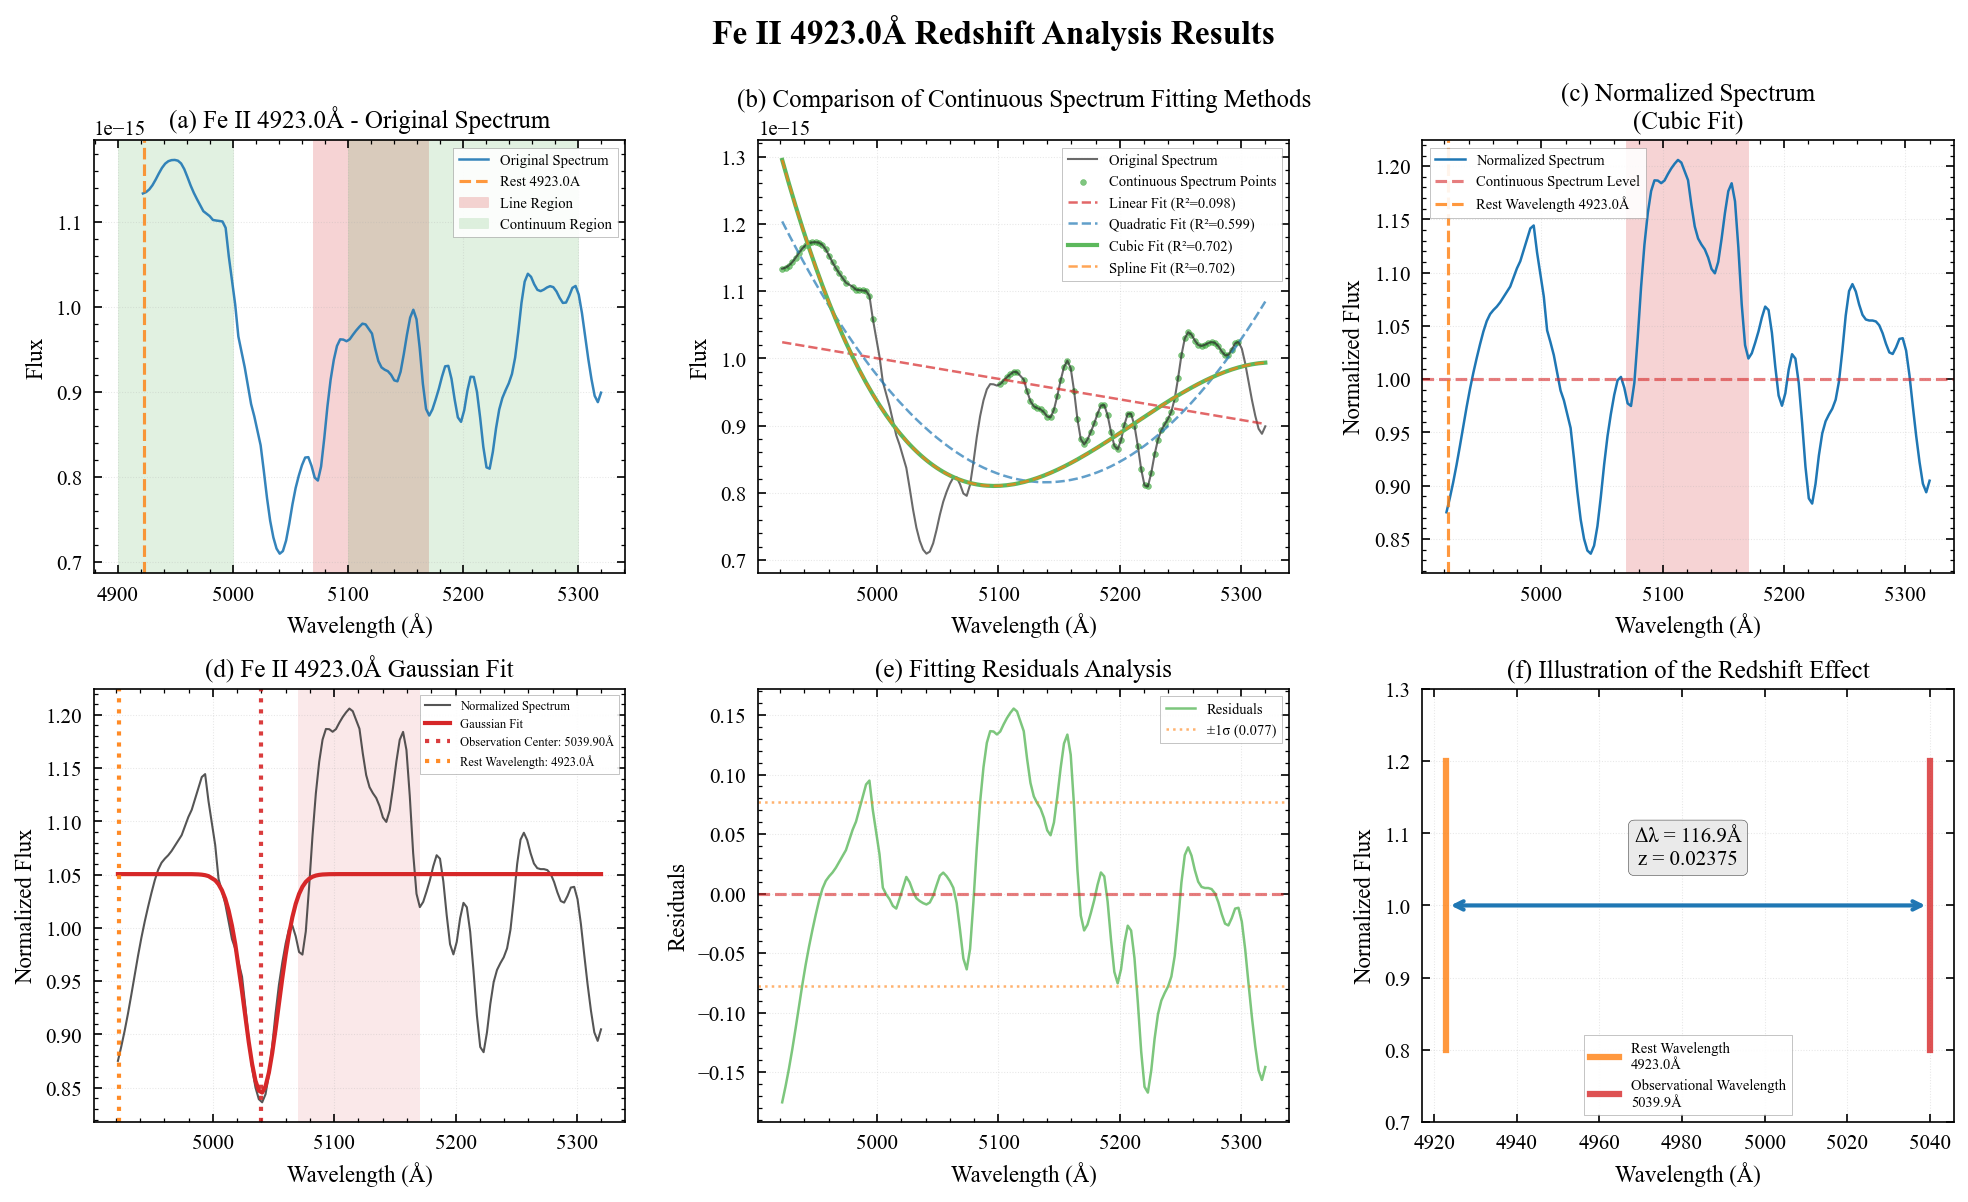

In [169]:
results = universal_redshift_measurement(
    wav_clean, flux_clean,
    line_name='Fe II', rest_wavelength=4923,
    expected_redshift=0.04,  # 如果你知道大概红移
    line_width_guess=50,     # 根据光谱分辨率调整
    continuum_regions=[(4900, 5000), (5100, 5300)],  # 手动指定连续谱区域
)

#### Redshift Analysis of the Si II 5972.0 Å Spectral Line

Si II 5972.0Å 谱线红移分析
根据静止波长 5972.0Å 自动设置分析区域...
分析参数:
  谱线: Si II 5972.0Å (absorption)
  分析范围: 5900.0-6300.0Å
  谱线区域: [(6160.88, 6260.88)]
  连续谱区域: [(5900, 6000), (6100, 6300)]
  找到 141 个数据点

连续谱拟合:
  自动选择: Cubic Fit (R²=0.7202)

Si II 5972.0Å 谱线拟合:
  初始猜测: 中心=6226.80Å, 类型=absorption
  拟合成功！
  观测中心: 6224.494 ± 1.919Å
  红移: z = 0.04228 ± 0.00032
  径向速度: v = 12675.1 ± 96.3 km/s
  约化χ²: 0.0026

REDSHIFT ANALYSIS SUMMARY - Si II 5972.0Å
Observed Wavelength: 6224.494 ± 1.919 Å
Rest Wavelength: 5972.0 Å
Redshift: z = 0.04228 ± 0.00032
Radial Velocity: 12675.1 ± 96.3 km/s
Line Width (FWHM): 17.6 Å
Continuum Method: Cubic Fit (R² = 0.7202)
Reduced χ²: 0.0026
Fit Quality: Needs Improvement


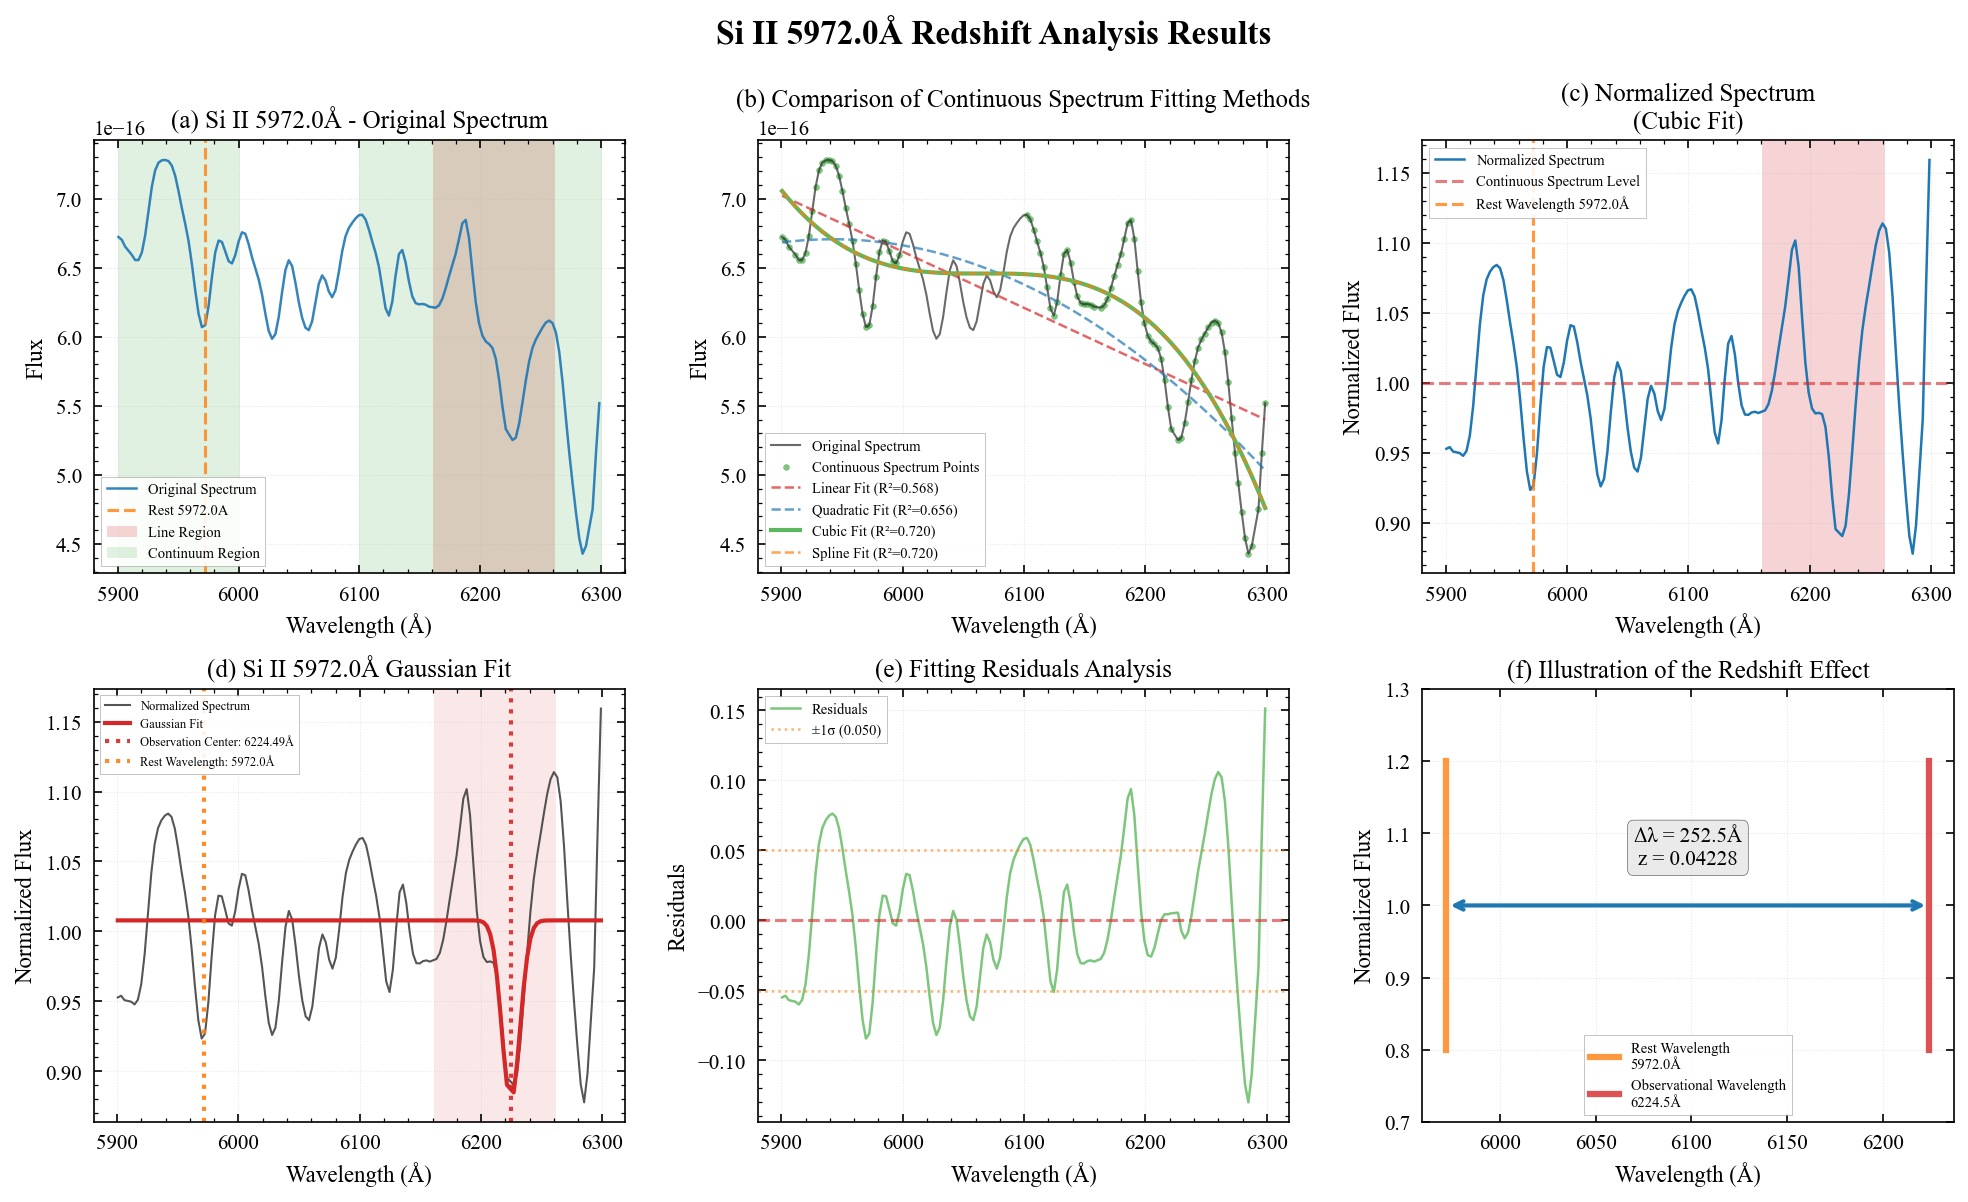

In [170]:
results = universal_redshift_measurement(
    wav_clean, flux_clean,
    line_name='Si II', rest_wavelength=5972,
    expected_redshift=0.04,  # 如果你知道大概红移
    line_width_guess=50,     # 根据光谱分辨率调整
    continuum_regions=[(5900, 6000), (6100, 6300)],  # 手动指定连续谱区域
    analysis_left=5900, analysis_right=6300,  # 手动指定分析范围
)



#### Conclusions of Redshift

Based on the redshift measurements of the four representative absorption lines above, we find that the fits for the Fe II 4233.0 Å Spectral Line and the Si II 5972.0 Å Spectral Line are relatively good. Their measured values are close to the "standard value" of z = 0.0407, which also approximates the reference redshift of the host galaxy. In contrast, the fits for the Si II 3858.0 Å Spectral Line and the Fe II 4923.0 Å Spectral Line are generally mediocre, with their redshift values clustered around 0.025.

The cause for the poorer fitting of these two spectral lines may be that along the line of sight between us and the target host galaxy (z = 0.0407), there could exist an unrelated gas cloud, dwarf galaxy, or the outskirts of another galaxy. This intervening system would have a cosmological redshift of approximately z ~ 0.025. Alternatively, it is possible that at the time of the supernova explosion, the gas generating these spectral lines was ejected toward us from the host galaxy at a very high velocity. Relative to the systemic redshift of the host galaxy, this would appear as a blueshift. We can estimate the relative velocity offset: the shift from z = 0.0407 to z = 0.025 corresponds to a blueshift velocity of approximately  
$$ (0.0407 - 0.025)\times c \approx 4710\, \mathrm{km/s} $$
Such a velocity could be more plausible in scenarios involving active galactic nuclei or intense starburst activity. Therefore, I am inclined to attribute these observations either to possible interference from an intervening system or to lower signal-to-noise ratios in these spectral lines.

Additionally, when examining the detailed profiles of the absorption line peaks, it is evident that each absorption feature exhibits varying degrees of line broadening. This broadening may arise from velocity dispersion, as mentioned above, or other line broadening mechanisms. However, given the limitations in the amount of observational data, the observation schedule, and my data analysis capabilities, I am currently unable to definitively determine the physical causes behind the mediocre fits of certain lines or any common underlying characteristics.